FARS2023 PERSON-LEVEL FATALITY PREDICTION
============================================================================
##Author: Jesus W Avalos Quizhpi
###Date: December 2025
============================================================================

Goals:
1. Run Random Forest, LightGBM, and XGBoost models to predict fatalities among participants in Motor-vehicle crashes using FARS 2023 datasets.
3. Reports F1-Score, ROC-AUC, and Confusion Matrix for each model
5. Saves comprehensive results to Google Drive

In [ ]:
# Install required packages
!pip install -q scikit-learn pandas numpy matplotlib seaborn lightgbm xgboost optuna joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 4.4 MB/s eta 0:00:00


In [ ]:
# ============================================================================
# 1: LIBRARIES & SETUP
# ============================================================================
import warnings
warnings.filterwarnings('ignore')

# Libraries
import random
import hashlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import joblib
from datetime import datetime


from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score,
    precision_score, recall_score, f1_score, confusion_matrix,
    roc_curve, precision_recall_curve
)

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


import optuna
from optuna.samplers import TPESampler

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


# Configure display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

Mounted at /content/drive


In [ ]:
# ============================================================================
# 2: GENERATE 10 RANDOM SEEDS FROM INPUT STRING
# ============================================================================

def md5_hash(input_string):
    """Generate an MD5 hash from a given string
    Args:
      input_string: The string to hash.
    Returns:
      The MD5 hash as a hexadecimal string.
  """
    md5_hasher = hashlib.md5()
    md5_hasher.update(input_string.encode('utf-8'))
    return md5_hasher.hexdigest()

# Generate seeds from "PLANETEARTH"
input_string = "PLANETEARTH"
hashed_value = md5_hash(input_string)
seed_base = int(hashed_value, 16)

print(f"Input String: '{input_string}'")
print(f"MD5 Hash: {hashed_value}")
print(f"Base Seed: {seed_base}")

# Generate 10 random seeds
random.seed(seed_base)
RANDOM_SEEDS = [random.randint(0, 2**31-1) for _ in range(10)]

print(f"\n5 Random Seeds Generated:")
for i, seed in enumerate(RANDOM_SEEDS, 1):
    print(f"  Seed {i}: {seed}")



Input String: 'PLANETEARTH'
MD5 Hash: 891309412315c817d99554947406caac
Base Seed: 182203076765220940304188608711018072748

5 Random Seeds Generated:
  Seed 1: 640619102
  Seed 2: 1616531643
  Seed 3: 1886502974
  Seed 4: 915101968
  Seed 5: 1330353286
  Seed 6: 1238364284
  Seed 7: 2011418682
  Seed 8: 1354128445
  Seed 9: 1202834428
  Seed 10: 2054179773


In [ ]:
# Save seeds to Google Drive
#seed_output_path = '/content/drive/My Drive/FARS2023_seeds-PLANETEARTH-DEC2025.txt'
#with open(seed_output_path, 'w') as f:
#    f.write(f"FARS2023 Random Seeds - Generated: {datetime.now()}\n")
#    f.write(f"Input String: {input_string}\n")
#    f.write(f"MD5 Hash: {hashed_value}\n")
#    f.write(f"Base Seed: {seed_base}\n\n")
#    f.write("10 Random Seeds:\n")
#    for i, seed in enumerate(RANDOM_SEEDS, 1):
#        f.write(f"Seed {i}: {seed}\n")

#print(f"\n✓ Seeds saved to: {seed_output_path}\n")


In [ ]:
# ============================================================================
# 3: HELPER FUNCTIONS
# ============================================================================

def print_section(title):
    """Print formatted section header"""
    print(f"\n{'='*80}\n{title}\n{'='*80}\n")

def evaluate_model(y_true, y_pred, y_pred_proba):
    """Calculate all evaluation metrics"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    return {
        'ROC-AUC': roc_auc_score(y_true, y_pred_proba),
        'F1-Score': f1_score(y_true, y_pred, zero_division=0),
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'TP': int(tp), 'TN': int(tn), 'FP': int(fp), 'FN': int(fn)
    }

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix", save_path=None):
    """Plot and save confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Survived', 'Died'],
                yticklabels=['Survived', 'Died'])

    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)

    total = cm.sum()
    for i in range(2):
        for j in range(2):
            pct = 100 * cm[i, j] / total
            plt.text(j + 0.5, i + 0.7, f'({pct:.1f}%)',
                    ha='center', va='center', fontsize=9, color='gray')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"  ✓ Saved: {save_path}")
    plt.show()

    return cm

def to_binary(df, col, condition, default=0):
    """Convert column to binary based on condition"""
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        return condition(df[col]).astype(int)
    return default



In [ ]:
# ============================================================================
# 4: DATA LOADING
# ============================================================================

print_section("DATA LOADING")

from google.colab import files

print("Upload 4 CSV files: accident.csv, person.csv, vehicle.csv, weather.csv\n")
uploaded = files.upload()

print("\nLoading files...")
acc = pd.read_csv('accident.csv').drop_duplicates(subset='ST_CASE')
per = pd.read_csv('person.csv').drop_duplicates(subset=['ST_CASE', 'VEH_NO', 'PER_NO'])
veh = pd.read_csv('vehicle.csv').drop_duplicates(subset=['ST_CASE', 'VEH_NO'])
wx = pd.read_csv('weather.csv').drop_duplicates(subset='ST_CASE')

for df in [acc, per, veh, wx]:
    df.columns = df.columns.str.lower()

print(f"✓ Loaded: {len(acc):,} crashes, {len(per):,} persons, {len(veh):,} vehicles\n")



DATA LOADING

Upload 4 CSV files: accident.csv, person.csv, vehicle.csv, weather.csv



Saving weather.csv to weather.csv
Saving vehicle.csv to vehicle.csv
Saving person.csv to person.csv
Saving accident.csv to accident.csv

Loading files...
✓ Loaded: 37,654 crashes, 92,400 persons, 58,319 vehicles



In [ ]:
# Injury severity variable
print(per['inj_sev'].value_counts().sort_index())
print(per['inj_sevname'].value_counts())


inj_sev
0    24145
1     6563
2     9611
3     9515
4    40901
5      195
6        2
9     1468
Name: count, dtype: int64
inj_sevname
Fatal Injury (K)                40901
No Apparent Injury (O)          24145
Suspected Minor Injury (B)       9611
Suspected Serious Injury (A)     9515
Possible Injury (C)              6563
Unknown/Not Reported             1468
Injured, Severity Unknown         195
Died Prior to Crash                 2
Name: count, dtype: int64


Excluding the value “Died Prior to Crash” from the target variable, as these individuals were not alive at the time of the crash and thus do not contribute to the prediction of fatality resulting from the crash event itself.

In [ ]:
# ============================================================================
# 5: TARGET VARIABLE
# ============================================================================

print_section("TARGET VARIABLE")

per['died'] = (per['inj_sev'] == 4).astype(int)
per.loc[per['inj_sev'] == 6, 'died'] = np.nan

na_count = per['died'].isna().sum()
valid = per['died'].dropna()

print(f"Total: {len(per):,}")
print(f"Died:     {int(valid.sum()):,} ({100*valid.sum()/len(valid):.1f}%)")
print(f"Survived: {int((valid==0).sum()):,} ({100*(valid==0).sum()/len(valid):.1f}%)")
print(f"NA:       {na_count:,}")


TARGET VARIABLE

Total: 92,400
Died:     40,901 (44.3%)
Survived: 51,497 (55.7%)
NA:       2


In [ ]:
# ============================================================================
# 6: MERGE DATASETS
# ============================================================================

print_section("MERGING DATASETS")

per_full = (per
    .merge(veh, on=['st_case', 'veh_no'], how='left', suffixes=('', '_veh'))
    .merge(acc, on='st_case', how='left', suffixes=('', '_acc'))
    .merge(wx, on='st_case', how='left', suffixes=('', '_wx')))

print(f"✓ Merged: {per_full.shape[0]:,} rows × {per_full.shape[1]:,} columns")


MERGING DATASETS

✓ Merged: 92,400 rows × 411 columns


In [ ]:
# Will focus study on motor-vehicle occupants to be able to analyze seating & restraints features.
per_full['MV_occupant'] = np.where(per_full['devtype'].isin([998, 999]), np.nan, per_full['devtype'].isna().astype(float))

# df will be dataset for modelling and feature engineering
df = per_full[per_full['MV_occupant'] == 1].copy()


In [ ]:
# ============================================================================
# 7: FEATURE ENGINEERING - BINARY CONVERSION (DONE ONCE)
# ============================================================================
print_section("FEATURE ENGINEERING")

print("Converting features to binary (0 or 1)...")

# Person characteristics
df['senior'] = np.where(df['age'].isin([998, 999]), np.nan, (df['age'] >= 65).astype(float)) #1 >18+
df['sex'] = np.where(df['sex'].isin([8, 9]), np.nan, (df['sex'] == 1).astype(float)) #1 Male

# Seating & restraints & Airbag
df['seat_pos'] = np.where(df['seat_pos'].isin([98, 99]), np.nan, df['seat_pos'].isin([11,12,13,18,19]).astype(float)) #1 frontseat #0 otherpos
df['rest_use'] = np.where(df['rest_use'].isin([98, 99]), np.nan, np.where(df['rest_use'] == 20, 0, 1).astype(float)) #1 = restrain used, 0 = none used
df['airbag_dep'] = np.where(df['air_bag'].isin([98, 99]), np.nan,np.where(df['air_bag'] == 20, 0, 1)) #1 deployed #0 none deployed


# Vehicle type
df['motorcycle'] = np.where(df['helm_use'].isin([98, 99]), np.nan,np.where(df['helm_use'] == 20, 0, 1))
df['newcar'] = np.where(df['mod_year'].isin([9998, 9999]), np.nan, np.where(df['mod_year'] > 2020, 1, 0)) #New car #1 newer tahn 2020, #older or 2020
df['rollover'] = np.where(df['rollover'].isin([8]), np.nan, np.where(df['rollover'] == 3, 1, 0)) #1 Rollover  #0 No
df['fire_exp'] = to_binary(df, 'fire_exp', lambda x: x == 1)
df['damaged'] = np.where(df['deformed'].isin([8, 9]), np.nan, np.where(df['deformed'] != 0, 1, 0)) #1 Veh Damaged, #0 Not damaged

# Crash characteristics
df['winter'] = to_binary(df, 'month', lambda x: x.isin([12,1,2])) #1 Winter
df['weekend'] = to_binary(df, 'day_week', lambda x: x.isin([1,6,7])) #1 Weekend
df['rural'] = np.where(df['rur_urb'].isin([6, 8, 9]), np.nan, np.where(df['rur_urb'] == 1, 1, 0)) #1 Rural, #0 Urban
df['interstate'] = np.where(df['route'].isin([96, 99]), np.nan, np.where(df['route'] == 1, 1, 0)) #1 Interstate, #0 Other

# Environmental
df['clear'] = np.where(df['weather'].isin([98, 99]), np.nan, np.where(df['weather'] == 1, 1, 0)) #1 clear, #0 not clear: rain, snow, cloudy, windy
df['daylight'] = np.where(df['lgt_cond'].isin([8, 9]), np.nan, np.where(df['lgt_cond'] == 1, 1, 0)) #1 daylight, #0 dark
df['noworkzone'] = to_binary(df, 'wrk_zone', lambda x: x == 0) #1 no Workzone

# Road characteristics
df['wayoverspeed'] = np.where(df['vspd_lim'].isna() | df['vspd_lim'].isin([98, 99]), np.nan, np.where(df['vspd_lim'] > 65, 1, 0)) #1 speed over 70mph, #0 speed less or equal to 70 mph
df['twoway'] = np.where(df['vtrafway'].isna() | df['vtrafway'].isin([8, 9]), np.nan, np.where(df['vtrafway'] == 1, 1, 0)) #1 Two way not divided, #0 Others
df['curve'] = np.where(df['valign'].isna() | df['valign'].isin([0, 8, 9]), np.nan, np.where(df['valign'] != 1, 1, 0)) #1 Curve, #0 Straigh roadway alignment
df['notleveled'] = np.where(df['vprofile'].isna() | df['vprofile'].isin([0, 8, 9]), np.nan, np.where(df['vprofile'] != 1, 1, 0)) #1 Curve, #0 Straigh roadway alignment
df['drysurf'] = np.where(df['vsurcond'].isna() | df['vsurcond'].isin([0, 98, 99]), np.nan, np.where(df['vsurcond'] == 1, 1, 0)) #1 dry surface, #0 Other: Wet, snow, sand, ice/frost, etc.
df['novtrafcon'] = np.where(df['vtrafcon'].isna() | df['vtrafcon'].isin([97, 99]), np.nan, np.where(df['vtrafcon'] == 0, 1, 0)) #1 No traffic control or sign, #0 Other: Yes some type of sign, signal or traffic control
df['intersection'] = np.where(df['typ_int'].isna() | df['typ_int'].isin([98, 99]), np.nan, np.where(df['typ_int'] != 1, 1, 0)) #1 Intersection, #0 Not an intersection

# Crash type
df['frontaltaletalcrash'] = np.where(df['acc_config'].isna() | df['acc_config'].isin([998, 999, 0, 000]), np.nan, np.where(df['acc_config'].isin([301, 302, 303, 304, 305, 306]), 1, 0)) #1 Same Trafficway, Opposite Direction, #0 not frontal crash

# Vehicles & Persons involved
df['more1veh'] = to_binary(df, 've_total', lambda x: x > 1) #1 more than 1 veh involved. #0 only 1 veh involved

# Driver characteristics
df['l_suspended'] = np.where(df['l_status'].isna(), np.nan, np.where(df['l_status'].isin([1, 2, 4]), 1, 0)) #1 Suspended/Revoked/Cancelled/Denied #2: Others
df['past_crashes'] = np.where(df['prev_acc'].isna() | df['prev_acc'].isin([99, 998]), np.nan, np.where(~df['prev_acc'].isin([0, 98]), 1, 0)) #1 no past crashes, #0 involved
df['DWI_convictions'] = np.where(df['prev_dwi'].isna() | df['prev_dwi'].isin([99, 998]), np.nan, np.where(df['prev_dwi'] != 0, 1, 0)) #1 DWI convictions #0 No DWI convictions
df['Speed_convictions'] = np.where(df['prev_spd'].isna() | df['prev_spd'].isin([99, 998]), np.nan, np.where(df['prev_spd'] != 0, 1, 0)) #1 Speed convictions #0 No Speed convictions

#print(df['Speed_convictions'].value_counts(dropna=False))

print(f"✓ Feature engineering completed")




print("\n" + "="*80)
print("BINARY FEATURES SUMMARY")
print("="*80 + "\n")

# Map binary features to original FARS variables
feature_mapping = {
    'senior': 'age', 'sex': 'sex', 'seat_pos': 'seat_pos', 'rest_use': 'rest_use',
    'airbag_dep': 'air_bag', 'motorcycle': 'helm_use', 'newcar': 'mod_year',
    'rollover': 'rollover', 'fire_exp': 'fire_exp', 'damaged': 'deformed', 'winter': 'month',
    'weekend': 'day_week', 'rural': 'rur_urb', 'interstate': 'route',
    'clear': 'weather', 'daylight': 'lgt_cond', 'noworkzone': 'wrk_zone',
    'wayoverspeed': 'vspd_lim', 'twoway': 'vtrafway', 'curve': 'valign',
    'notleveled': 'vprofile', 'drysurf': 'vsurcond', 'novtrafcon': 'vtrafcon',
    'intersection': 'typ_int', 'frontaltaletalcrash': 'acc_config', 'more1veh': 've_total',
    'l_suspended': 'l_status', 'past_crashes': 'prev_acc', 'DWI_convictions': 'prev_dwi',
    'Speed_convictions': 'prev_spd'
}

summary_data = []
for feat, fars_var in feature_mapping.items():
    if feat in df.columns:
        vc = df[feat].value_counts(dropna=False)
        summary_data.append({
            'Binary Feature': feat,
            'FARS Variable': fars_var,
            '0': int(vc.get(0.0, 0)),
            '1': int(vc.get(1.0, 0)),
            'NaN': int(df[feat].isna().sum())
        })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))
print(f"\nTotal Features: {len(feature_mapping)}")
print(f"Valid Samples: {len(df):,}\n")



FEATURE ENGINEERING

Converting features to binary (0 or 1)...
✓ Feature engineering completed

BINARY FEATURES SUMMARY

     Binary Feature FARS Variable     0     1   NaN
             senior           age 69922 10930  2261
                sex           sex 26683 54521  1909
           seat_pos      seat_pos 10697 71284  1132
           rest_use      rest_use 25357 48800  8956
         airbag_dep       air_bag 40819 37205  5089
         motorcycle      helm_use 75359  7358   396
             newcar      mod_year 70726 10400  1987
           rollover      rollover 63403 12871  6839
           fire_exp      fire_exp 80093  3020     0
            damaged      deformed  1266 79901  1946
             winter         month 64248 18865     0
            weekend      day_week 41837 41276     0
              rural       rur_urb 49252 33310   551
         interstate         route 70080 11931  1102
              clear       weather 18676 61682  2755
           daylight      lgt_cond 42380 40383 

In [ ]:
# ============================================================================
# 8: FEATURE SELECTION - WHITELIST
# ============================================================================

print_section("FEATURE SELECTION")
features = [
    'senior', 'sex', 'seat_pos', 'rest_use', 'airbag_dep', 'motorcycle', 'newcar',
    'rollover', 'fire_exp', 'damaged', 'winter', 'weekend', 'rural', 'interstate', 'clear',
    'daylight', 'noworkzone', 'wayoverspeed', 'twoway', 'curve', 'notleveled',
    'drysurf', 'novtrafcon', 'intersection', 'frontaltaletalcrash', 'more1veh',
    'l_suspended', 'past_crashes', 'DWI_convictions', 'Speed_convictions', 'died'
]

available = [col for col in features if col in df.columns]
per_clean = df[available].copy()


print(f"✓ Selected {len(available)} features including target variable")



FEATURE SELECTION

✓ Selected 31 features including target variable


In [ ]:
# ============================================================================
# EXPORT TO CSV - GOOGLE COLAB WITH GOOGLE DRIVE
# ============================================================================

from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Select features and export directly
csv_filename = 'FARS_31variables_analysis.csv'
drive_path = f'/content/drive/My Drive/{csv_filename}'

available = [col for col in features if col in df.columns]
df[available].to_csv(drive_path, index=False)

print(f"\n{'='*80}")
print("EXPORT SUMMARY")
print(f"{'='*80}")
print(f"✓ File: {csv_filename}")
print(f"✓ Rows: {len(df):,}")
print(f"✓ Columns: {len(available)}")
print(f"✓ Size: {os.path.getsize(drive_path) / 1024**2:.2f} MB")
print(f"✓ Location: Google Drive > My Drive > {csv_filename}")


Mounted at /content/drive

EXPORT SUMMARY
✓ File: FARS_31variables_analysis.csv
✓ Rows: 83,113
✓ Columns: 31
✓ Size: 8.75 MB
✓ Location: Google Drive > My Drive > FARS_31variables_analysis.csv


In [ ]:
# ============================================================================
# 9: PREPARE BASE DATA
# ============================================================================

print_section("DATA PREPARATION")

y_all = per_clean['died'].values
X_all = per_clean.drop(columns=['died'])

# Remove constant columns
constant_cols = [col for col in X_all.columns if X_all[col].nunique() == 1]
if constant_cols:
    X_all = X_all.drop(columns=constant_cols)
    print(f"✓ Removed {len(constant_cols)} constant columns")

print(f"✓ Final: {X_all.shape[1]} features, {X_all.shape[0]:,} samples")



DATA PREPARATION

✓ Final: 30 features, 83,113 samples


In [ ]:
# ============================================================================
# 10: SINGLE-SEED MODEL TRAINING SETUP
# ============================================================================

print_section("SINGLE-SEED MODEL TRAINING")

# Use first seed from PLANETEARTH generation
TRAINING_SEED = RANDOM_SEEDS[0]  # 640619102

print(f"Training Seed: {TRAINING_SEED}")
print(f"Models to Train: Random Forest, LightGBM, XGBoost")
print(f"Hyperparameter Optimization: Optuna with 10 trials per model")
print(f"Evaluation Metrics: ROC-AUC, F1-Score, Accuracy, Precision, Recall")

# Set all random seeds for reproducibility
np.random.seed(TRAINING_SEED)
random.seed(TRAINING_SEED)

print(f"\n✓ Random seeds set for reproducible training")


SINGLE-SEED MODEL TRAINING

Training Seed: 640619102
Models to Train: Random Forest, LightGBM, XGBoost
Hyperparameter Optimization: Optuna with 10 trials per model
Evaluation Metrics: ROC-AUC, F1-Score, Accuracy, Precision, Recall

✓ Random seeds set for reproducible training


In [ ]:
# ============================================================================
# 11: TRAIN-TEST SPLIT
# ============================================================================

print_section("TRAIN-TEST SPLIT")

# Check for missing values
print("Checking for missing values...")
print(f"  X_all NaN count: {X_all.isnull().sum().sum()}")
print(f"  y_all NaN count: {np.isnan(y_all).sum()}")

# Create mask for valid target values ONLY
# Keep samples with missing features - XGBoost/LightGBM handle them natively
valid_mask = ~np.isnan(y_all)

# Filter both X and y using the SAME mask (based only on y missingness)
X_all_clean = X_all[valid_mask]
y_all_clean = y_all[valid_mask]

n_removed = len(X_all) - len(X_all_clean)
if n_removed > 0:
    print(f"\n✓ Removed {n_removed:,} samples with missing TARGET (y) values ({100*n_removed/len(X_all):.2f}%)")
    print(f"✓ Kept samples with missing FEATURES (X) - models handle these natively")
    print(f"✓ Clean dataset: {len(X_all_clean):,} samples")
else:
    print(f"\n✓ No missing target values found")
    print(f"✓ Dataset: {len(X_all_clean):,} samples")

# Check remaining missing values after filtering
print(f"\nAfter filtering:")
print(f"  X_all_clean NaN count: {X_all_clean.isnull().sum().sum()}")
print(f"  y_all_clean NaN count: {np.isnan(y_all_clean).sum()}")

# Perform train-test split on clean data
X_train, X_test, y_train, y_test = train_test_split(
    X_all_clean, y_all_clean,
    test_size=0.2,
    random_state=TRAINING_SEED,
    stratify=y_all_clean
)

print(f"\nTraining Set:   {X_train.shape[0]:,} samples ({100*X_train.shape[0]/len(X_all_clean):.1f}%)")
print(f"Testing Set:    {X_test.shape[0]:,} samples ({100*X_test.shape[0]/len(X_all_clean):.1f}%)")
print(f"\nTarget Distribution:")
print(f"  Training - Died: {y_train.sum():,} ({100*y_train.mean():.1f}%)")
print(f"  Training - Survived: {(y_train==0).sum():,} ({100*(1-y_train.mean()):.1f}%)")
print(f"  Testing  - Died: {y_test.sum():,} ({100*y_test.mean():.1f}%)")
print(f"  Testing  - Survived: {(y_test==0).sum():,} ({100*(1-y_test.mean()):.1f}%)")
print(f"\n✓ Stratified split maintains class distribution")
print(f"✓ Feature missing values retained (XGBoost/LightGBM compatible)")


TRAIN-TEST SPLIT

Checking for missing values...
  X_all NaN count: 98404
  y_all NaN count: 2

✓ Removed 2 samples with missing TARGET (y) values (0.00%)
✓ Kept samples with missing FEATURES (X) - models handle these natively
✓ Clean dataset: 83,111 samples

After filtering:
  X_all_clean NaN count: 98403
  y_all_clean NaN count: 0

Training Set:   66,488 samples (80.0%)
Testing Set:    16,623 samples (20.0%)

Target Distribution:
  Training - Died: 25,714.0 (38.7%)
  Training - Survived: 40,774 (61.3%)
  Testing  - Died: 6,429.0 (38.7%)
  Testing  - Survived: 10,194 (61.3%)

✓ Stratified split maintains class distribution
✓ Feature missing values retained (XGBoost/LightGBM compatible)


In [ ]:
# ============================================================================
# 12: RANDOM FOREST - HYPERPARAMETER TUNING
# ============================================================================

print_section("RANDOM FOREST - HYPERPARAMETER TUNING")

print("Starting Optuna optimization with 10 trials...\n")

def objective_rf(trial):
    """Objective function for Random Forest hyperparameter optimization"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=100),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'class_weight': 'balanced',
        'random_state': TRAINING_SEED,
        'n_jobs': -1
    }

    # 5-fold stratified cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=TRAINING_SEED)
    model = RandomForestClassifier(**params)

    scores = cross_validate(
        model, X_train, y_train, cv=cv,
        scoring='average_precision',
        n_jobs=-1
    )

    return scores['test_score'].mean()

# Create and run Optuna study
study_rf = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=TRAINING_SEED)
)

study_rf.optimize(objective_rf, n_trials=10, show_progress_bar=True)

print(f"\n{'='*80}")
print(f"✓ Optimization Complete")
print(f"✓ Best PR-AUC: {study_rf.best_value:.4f}")
print(f"{'='*80}")
print(f"\nBest Hyperparameters:")
for param, value in study_rf.best_params.items():
    print(f"  {param:20s}: {value}")

# Store best parameters
best_rf_params = study_rf.best_params.copy()
best_rf_params['class_weight'] = 'balanced'
best_rf_params['random_state'] = TRAINING_SEED
best_rf_params['n_jobs'] = -1

# Clean up memory
gc.collect()

[I 2025-12-02 13:57:20,825] A new study created in memory with name: no-name-a503b57f-3c0f-4d38-9b48-bc1c00a010fa



RANDOM FOREST - HYPERPARAMETER TUNING

Starting Optuna optimization with 10 trials...



  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-02 14:08:19,582] Trial 0 finished with value: 0.7968665070060681 and parameters: {'n_estimators': 500, 'max_depth': 43, 'min_samples_split': 13, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 0 with value: 0.7968665070060681.
[I 2025-12-02 14:09:08,353] Trial 1 finished with value: 0.8064561464510982 and parameters: {'n_estimators': 200, 'max_depth': 13, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 0.8064561464510982.
[I 2025-12-02 14:09:38,733] Trial 2 finished with value: 0.8034069937827664 and parameters: {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 0.8064561464510982.
[I 2025-12-02 14:10:08,182] Trial 3 finished with value: 0.8066383525857242 and parameters: {'n_estimators': 100, 'max_depth': 47, 'min_samples_split': 3, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 3 with value: 0.80663835258572

754

In [ ]:
# ============================================================================
# 13: RANDOM FOREST - MODEL TRAINING & EVALUATION
# ============================================================================

print_section("RANDOM FOREST - MODEL TRAINING")

print("Training Random Forest with optimized hyperparameters...\n")

# Train final model
rf_model = RandomForestClassifier(**best_rf_params)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluate model
rf_metrics = evaluate_model(y_test, y_pred_rf, y_pred_proba_rf)

print("✓ Training Complete\n")
print(f"{'='*80}")
print("RANDOM FOREST PERFORMANCE")
print(f"{'='*80}")
print(f"ROC-AUC:    {rf_metrics['ROC-AUC']:.4f}")
print(f"F1-Score:   {rf_metrics['F1-Score']:.4f}")
print(f"Accuracy:   {rf_metrics['Accuracy']:.4f}")
print(f"Precision:  {rf_metrics['Precision']:.4f}")
print(f"Recall:     {rf_metrics['Recall']:.4f}")
print(f"\nConfusion Matrix:")
print(f"  TN: {rf_metrics['TN']:,} | FP: {rf_metrics['FP']:,}")
print(f"  FN: {rf_metrics['FN']:,} | TP: {rf_metrics['TP']:,}")
print(f"{'='*80}")


RANDOM FOREST - MODEL TRAINING

Training Random Forest with optimized hyperparameters...

✓ Training Complete

RANDOM FOREST PERFORMANCE
ROC-AUC:    0.8705
F1-Score:   0.7351
Accuracy:   0.7870
Precision:  0.7082
Recall:     0.7642

Confusion Matrix:
  TN: 8,170 | FP: 2,024
  FN: 1,516 | TP: 4,913



RANDOM FOREST - DETAILED VISUALIZATION & ANALYSIS

Generating feature importance analysis...



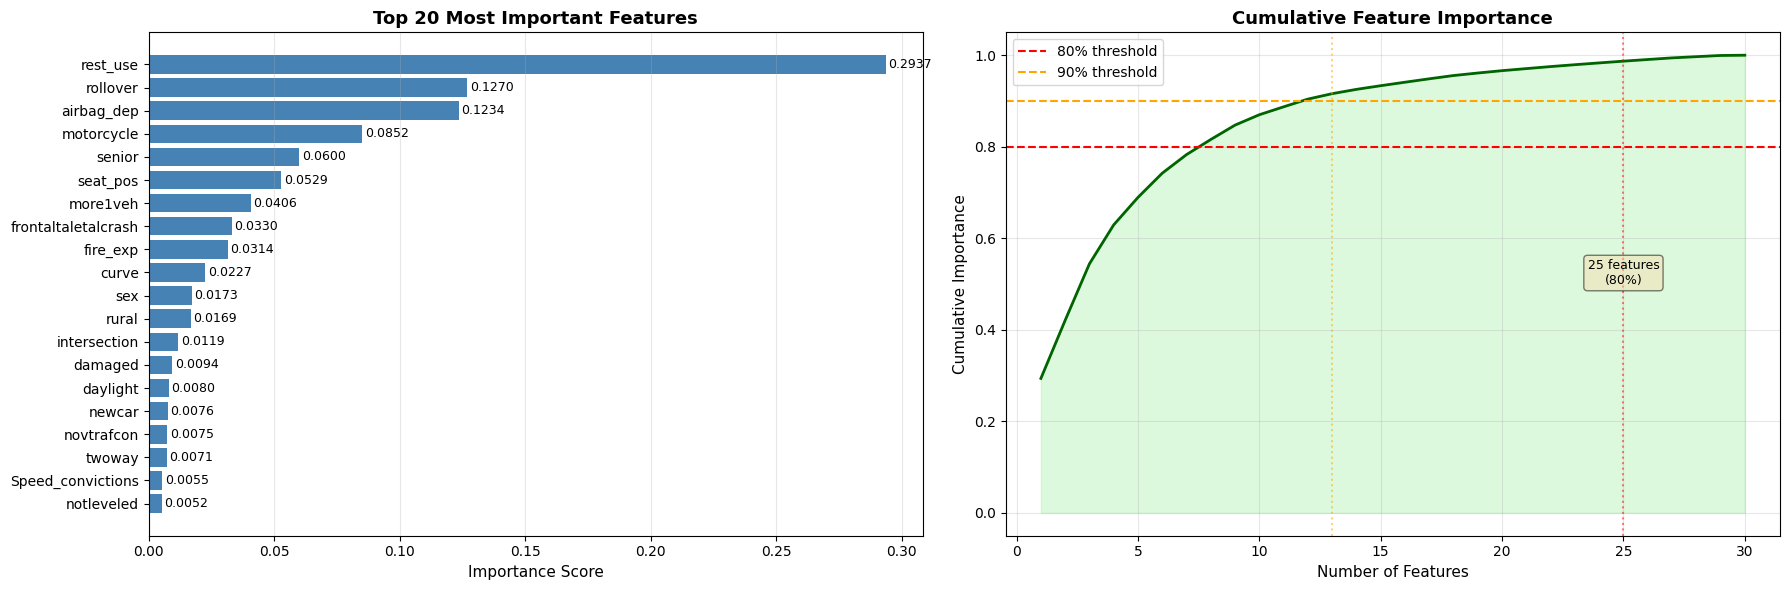

✓ Top 5 features: rest_use, rollover, airbag_dep, motorcycle, senior
✓ Features needed for 80% importance: 25/30
✓ Features needed for 90% importance: 13/30

Generating ROC and Precision-Recall curves...



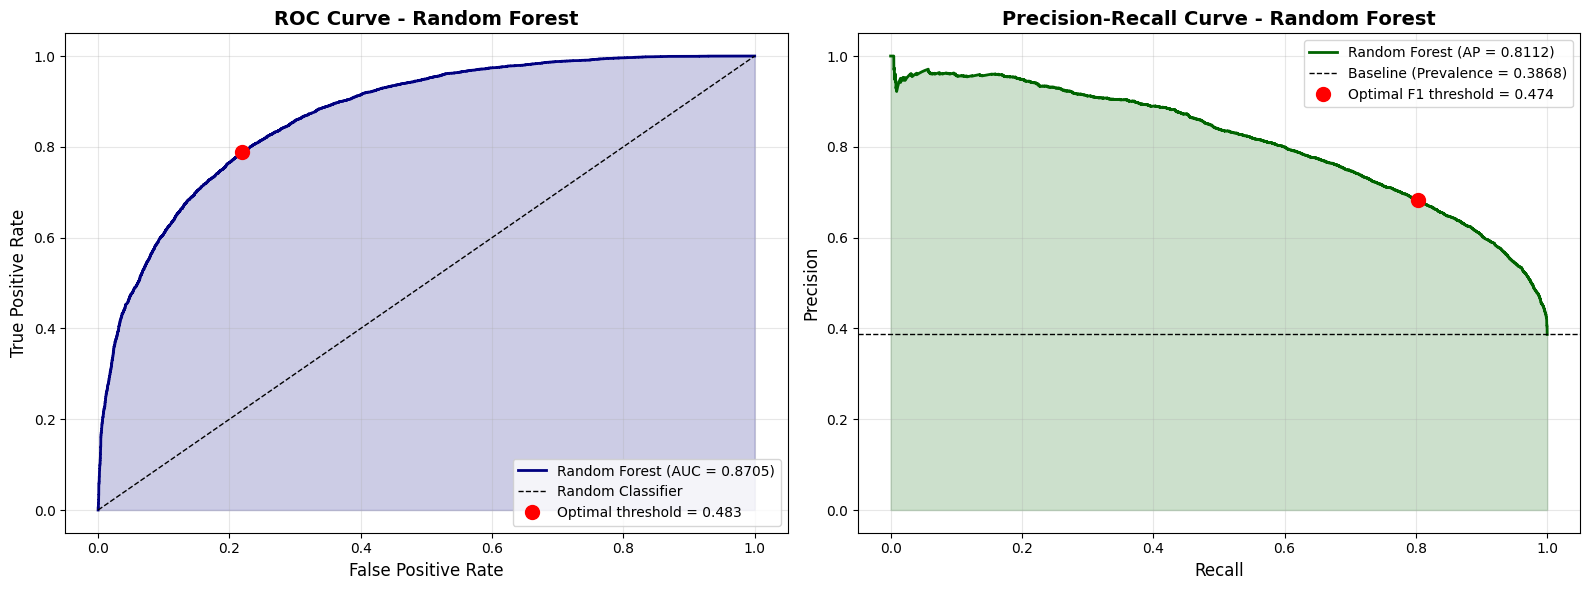

✓ ROC-AUC: 0.8705
✓ Precision-Recall AUC: 0.8112
✓ Optimal ROC threshold: 0.4827 (maximizes TPR-FPR)
✓ Optimal F1 threshold: 0.4739 (maximizes F1-Score)

Generating detailed confusion matrix...



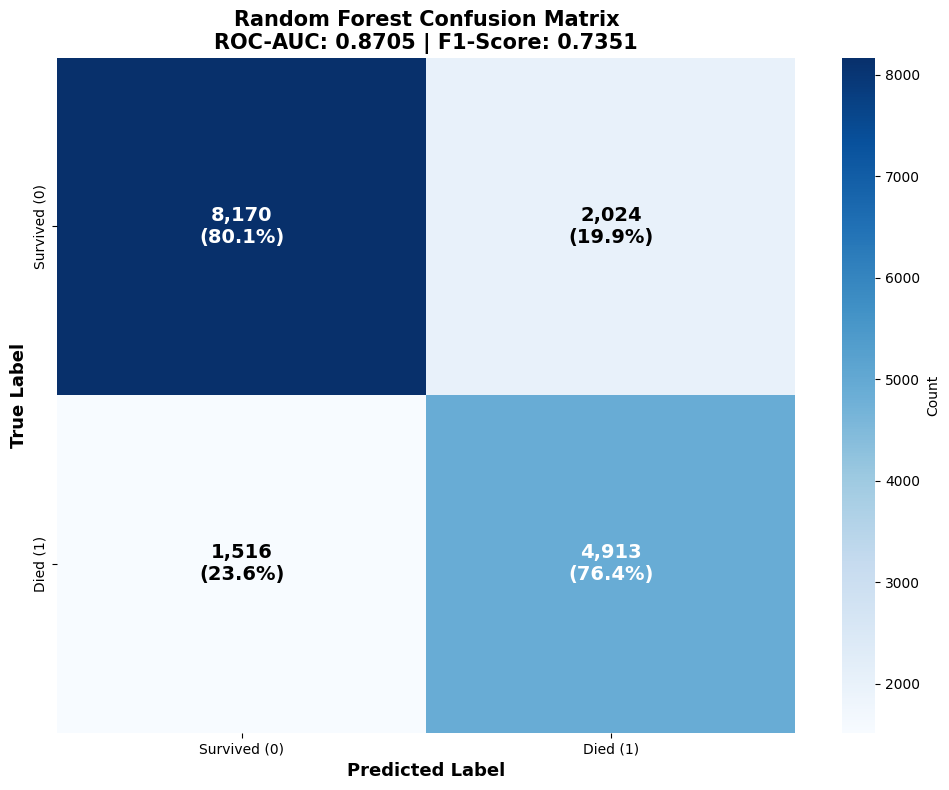

Confusion Matrix Breakdown:
  True Negatives (TN):  8,170 - Correctly predicted survivors
  False Positives (FP): 2,024 - Survivors incorrectly predicted as died
  False Negatives (FN): 1,516 - Deaths incorrectly predicted as survived
  True Positives (TP):  4,913 - Correctly predicted deaths

Additional Metrics:
  Sensitivity (Recall): 0.7642 - % of actual deaths correctly identified
  Specificity:          0.8015 - % of actual survivors correctly identified
  PPV (Precision):      0.7082 - % of predicted deaths that actually died
  NPV:                  0.8435 - % of predicted survivors that actually survived

Analyzing prediction probability distributions...



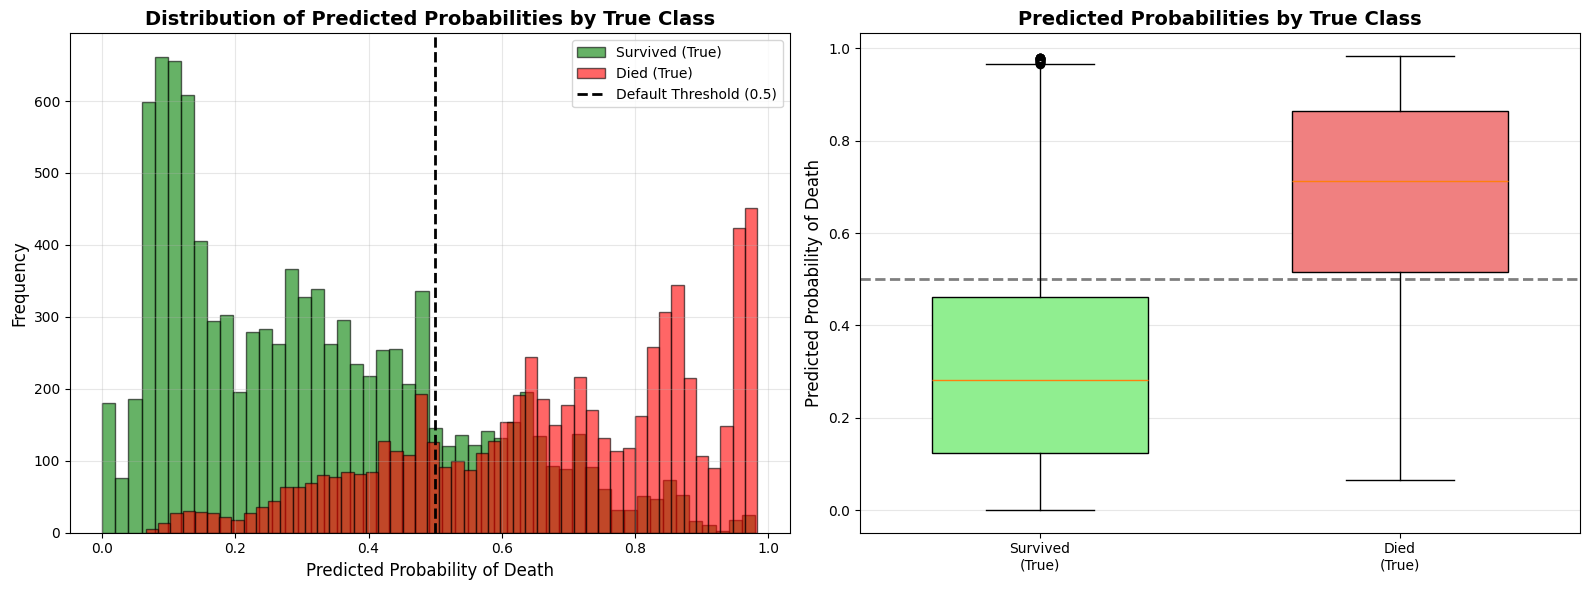

Probability Distribution Statistics:
  Survived (True) - Mean: 0.3160, Std: 0.2177
  Died (True)     - Mean: 0.6829, Std: 0.2206
  Separation:       0.3669

✓ Good separation indicates model can distinguish between classes

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Survived     0.8435    0.8015    0.8219     10194
        Died     0.7082    0.7642    0.7351      6429

    accuracy                         0.7870     16623
   macro avg     0.7759    0.7828    0.7785     16623
weighted avg     0.7912    0.7870    0.7884     16623


RANDOM FOREST MODEL SUMMARY
               Metric  Value
              ROC-AUC 0.8705
               PR-AUC 0.8112
             F1-Score 0.7351
             Accuracy 0.7870
            Precision 0.7082
               Recall 0.7642
          Specificity 0.8015
                  PPV 0.7082
                  NPV 0.8435
Optimal ROC Threshold 0.4827
 Optimal F1 Threshold 0.4739

✓ Random Forest detailed analysis complete!


In [ ]:
# ============================================================================
# 13B: RANDOM FOREST - DETAILED VISUALIZATION & ANALYSIS
# ============================================================================

print_section("RANDOM FOREST - DETAILED VISUALIZATION & ANALYSIS")

# ----------------------------------------------------------------------------
# 1. FEATURE IMPORTANCE ANALYSIS
# ----------------------------------------------------------------------------
print("Generating feature importance analysis...\n")

# Get feature importances
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 features
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Bar plot - Top 20
top_20 = feature_importance.head(20)
axes[0].barh(range(len(top_20)), top_20['importance'].values, color='steelblue')
axes[0].set_yticks(range(len(top_20)))
axes[0].set_yticklabels(top_20['feature'].values)
axes[0].invert_yaxis()
axes[0].set_xlabel('Importance Score', fontsize=11)
axes[0].set_title('Top 20 Most Important Features', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(top_20.iterrows()):
    axes[0].text(row['importance'] + 0.001, i, f"{row['importance']:.4f}",
                va='center', fontsize=9)

# Cumulative importance
feature_importance_sorted = feature_importance.sort_values('importance', ascending=False)
cumsum = feature_importance_sorted['importance'].cumsum()
axes[1].plot(range(1, len(cumsum)+1), cumsum, linewidth=2, color='darkgreen')
axes[1].axhline(y=0.8, color='red', linestyle='--', label='80% threshold')
axes[1].axhline(y=0.9, color='orange', linestyle='--', label='90% threshold')
axes[1].fill_between(range(1, len(cumsum)+1), cumsum, alpha=0.3, color='lightgreen')
axes[1].set_xlabel('Number of Features', fontsize=11)
axes[1].set_ylabel('Cumulative Importance', fontsize=11)
axes[1].set_title('Cumulative Feature Importance', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Find features needed for 80% and 90%
n_80 = (cumsum >= 0.8).idxmax() + 1
n_90 = (cumsum >= 0.9).idxmax() + 1
axes[1].axvline(x=n_80, color='red', linestyle=':', alpha=0.5)
axes[1].axvline(x=n_90, color='orange', linestyle=':', alpha=0.5)
axes[1].text(n_80, 0.5, f'{n_80} features\n(80%)', ha='center', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"✓ Top 5 features: {', '.join(feature_importance.head(5)['feature'].values)}")
print(f"✓ Features needed for 80% importance: {n_80}/{len(feature_importance)}")
print(f"✓ Features needed for 90% importance: {n_90}/{len(feature_importance)}\n")

# ----------------------------------------------------------------------------
# 2. ROC CURVE & PRECISION-RECALL CURVE
# ----------------------------------------------------------------------------
print("Generating ROC and Precision-Recall curves...\n")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba_rf)
roc_auc = roc_auc_score(y_test, y_pred_proba_rf)

axes[0].plot(fpr, tpr, linewidth=2, label=f'Random Forest (AUC = {roc_auc:.4f})', color='navy')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[0].fill_between(fpr, tpr, alpha=0.2, color='navy')
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve - Random Forest', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(alpha=0.3)

# Add optimal threshold point
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds_roc[optimal_idx]
axes[0].plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=10,
            label=f'Optimal threshold = {optimal_threshold:.3f}')
axes[0].legend(loc='lower right', fontsize=10)

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba_rf)
pr_auc = average_precision_score(y_test, y_pred_proba_rf)

axes[1].plot(recall, precision, linewidth=2, label=f'Random Forest (AP = {pr_auc:.4f})', color='darkgreen')
axes[1].axhline(y=y_test.mean(), color='k', linestyle='--', linewidth=1,
                label=f'Baseline (Prevalence = {y_test.mean():.4f})')
axes[1].fill_between(recall, precision, alpha=0.2, color='darkgreen')
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve - Random Forest', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(alpha=0.3)

# Add F1-optimal threshold point
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)
optimal_f1_idx = np.argmax(f1_scores)
axes[1].plot(recall[optimal_f1_idx], precision[optimal_f1_idx], 'ro', markersize=10,
            label=f'Optimal F1 threshold = {thresholds_pr[optimal_f1_idx]:.3f}')
axes[1].legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

print(f"✓ ROC-AUC: {roc_auc:.4f}")
print(f"✓ Precision-Recall AUC: {pr_auc:.4f}")
print(f"✓ Optimal ROC threshold: {optimal_threshold:.4f} (maximizes TPR-FPR)")
print(f"✓ Optimal F1 threshold: {thresholds_pr[optimal_f1_idx]:.4f} (maximizes F1-Score)\n")

# ----------------------------------------------------------------------------
# 3. CONFUSION MATRIX WITH DETAILED ANNOTATIONS
# ----------------------------------------------------------------------------
print("Generating detailed confusion matrix...\n")

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

cm = confusion_matrix(y_test, y_pred_rf)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create annotated heatmap
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Survived (0)', 'Died (1)'],
            yticklabels=['Survived (0)', 'Died (1)'],
            cbar_kws={'label': 'Count'})

# Add detailed annotations
for i in range(2):
    for j in range(2):
        count = cm[i, j]
        percentage = cm_normalized[i, j] * 100
        text = f'{count:,}\n({percentage:.1f}%)'
        ax.text(j + 0.5, i + 0.5, text, ha='center', va='center',
               fontsize=14, fontweight='bold',
               color='white' if cm[i, j] > cm.max() / 2 else 'black')

ax.set_ylabel('True Label', fontsize=13, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=13, fontweight='bold')
ax.set_title(f'Random Forest Confusion Matrix\nROC-AUC: {roc_auc:.4f} | F1-Score: {rf_metrics["F1-Score"]:.4f}',
            fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
ppv = tp / (tp + fp)  # Positive Predictive Value
npv = tn / (tn + fn)  # Negative Predictive Value

print(f"Confusion Matrix Breakdown:")
print(f"  True Negatives (TN):  {tn:,} - Correctly predicted survivors")
print(f"  False Positives (FP): {fp:,} - Survivors incorrectly predicted as died")
print(f"  False Negatives (FN): {fn:,} - Deaths incorrectly predicted as survived")
print(f"  True Positives (TP):  {tp:,} - Correctly predicted deaths")
print(f"\nAdditional Metrics:")
print(f"  Sensitivity (Recall): {sensitivity:.4f} - % of actual deaths correctly identified")
print(f"  Specificity:          {specificity:.4f} - % of actual survivors correctly identified")
print(f"  PPV (Precision):      {ppv:.4f} - % of predicted deaths that actually died")
print(f"  NPV:                  {npv:.4f} - % of predicted survivors that actually survived\n")

# ----------------------------------------------------------------------------
# 4. PREDICTION DISTRIBUTION ANALYSIS
# ----------------------------------------------------------------------------
print("Analyzing prediction probability distributions...\n")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribution of predicted probabilities by true class
axes[0].hist(y_pred_proba_rf[y_test == 0], bins=50, alpha=0.6, label='Survived (True)',
            color='green', edgecolor='black')
axes[0].hist(y_pred_proba_rf[y_test == 1], bins=50, alpha=0.6, label='Died (True)',
            color='red', edgecolor='black')
axes[0].axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Default Threshold (0.5)')
axes[0].set_xlabel('Predicted Probability of Death', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Predicted Probabilities by True Class', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Box plot comparison
data_to_plot = [
    y_pred_proba_rf[y_test == 0],
    y_pred_proba_rf[y_test == 1]
]
bp = axes[1].boxplot(data_to_plot, labels=['Survived\n(True)', 'Died\n(True)'],
                     patch_artist=True, widths=0.6)
bp['boxes'][0].set_facecolor('lightgreen')
bp['boxes'][1].set_facecolor('lightcoral')
axes[1].axhline(y=0.5, color='black', linestyle='--', linewidth=2, alpha=0.5)
axes[1].set_ylabel('Predicted Probability of Death', fontsize=12)
axes[1].set_title('Predicted Probabilities by True Class', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate separation metrics
mean_prob_died = y_pred_proba_rf[y_test == 1].mean()
mean_prob_survived = y_pred_proba_rf[y_test == 0].mean()
std_prob_died = y_pred_proba_rf[y_test == 1].std()
std_prob_survived = y_pred_proba_rf[y_test == 0].std()

print(f"Probability Distribution Statistics:")
print(f"  Survived (True) - Mean: {mean_prob_survived:.4f}, Std: {std_prob_survived:.4f}")
print(f"  Died (True)     - Mean: {mean_prob_died:.4f}, Std: {std_prob_died:.4f}")
print(f"  Separation:       {abs(mean_prob_died - mean_prob_survived):.4f}")
print(f"\n✓ Good separation indicates model can distinguish between classes\n")

# ----------------------------------------------------------------------------
# 5. CLASSIFICATION REPORT
# ----------------------------------------------------------------------------
print("="*80)
print("CLASSIFICATION REPORT")
print("="*80)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_rf, target_names=['Survived', 'Died'], digits=4))

# ----------------------------------------------------------------------------
# 6. MODEL SUMMARY TABLE
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("RANDOM FOREST MODEL SUMMARY")
print("="*80)

summary_data = {
    'Metric': [
        'ROC-AUC', 'PR-AUC', 'F1-Score', 'Accuracy', 'Precision', 'Recall',
        'Specificity', 'PPV', 'NPV', 'Optimal ROC Threshold', 'Optimal F1 Threshold'
    ],
    'Value': [
        f"{roc_auc:.4f}",
        f"{pr_auc:.4f}",
        f"{rf_metrics['F1-Score']:.4f}",
        f"{rf_metrics['Accuracy']:.4f}",
        f"{rf_metrics['Precision']:.4f}",
        f"{rf_metrics['Recall']:.4f}",
        f"{specificity:.4f}",
        f"{ppv:.4f}",
        f"{npv:.4f}",
        f"{optimal_threshold:.4f}",
        f"{thresholds_pr[optimal_f1_idx]:.4f}"
    ]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))
print("="*80)

# Store extended metrics for later comparison
rf_metrics_extended = {
    **rf_metrics,
    'PR-AUC': pr_auc,
    'Specificity': specificity,
    'PPV': ppv,
    'NPV': npv,
    'Optimal_ROC_Threshold': optimal_threshold,
    'Optimal_F1_Threshold': thresholds_pr[optimal_f1_idx]
}

print("\n✓ Random Forest detailed analysis complete!")


RANDOM FOREST - VALIDATION CURVES & PREDICTION ANALYSIS

Creating validation set for performance tracking...

Dataset Split:
  Training:   53,190 samples (64.0%)
  Validation: 13,298 samples (16.0%)
  Testing:    16,623 samples (20.0%)

Performance Across Sets:
  Train      - ROC-AUC: 0.8809, F1: 0.7465
  Validation - ROC-AUC: 0.8677, F1: 0.7324
  Test       - ROC-AUC: 0.8702, F1: 0.7349


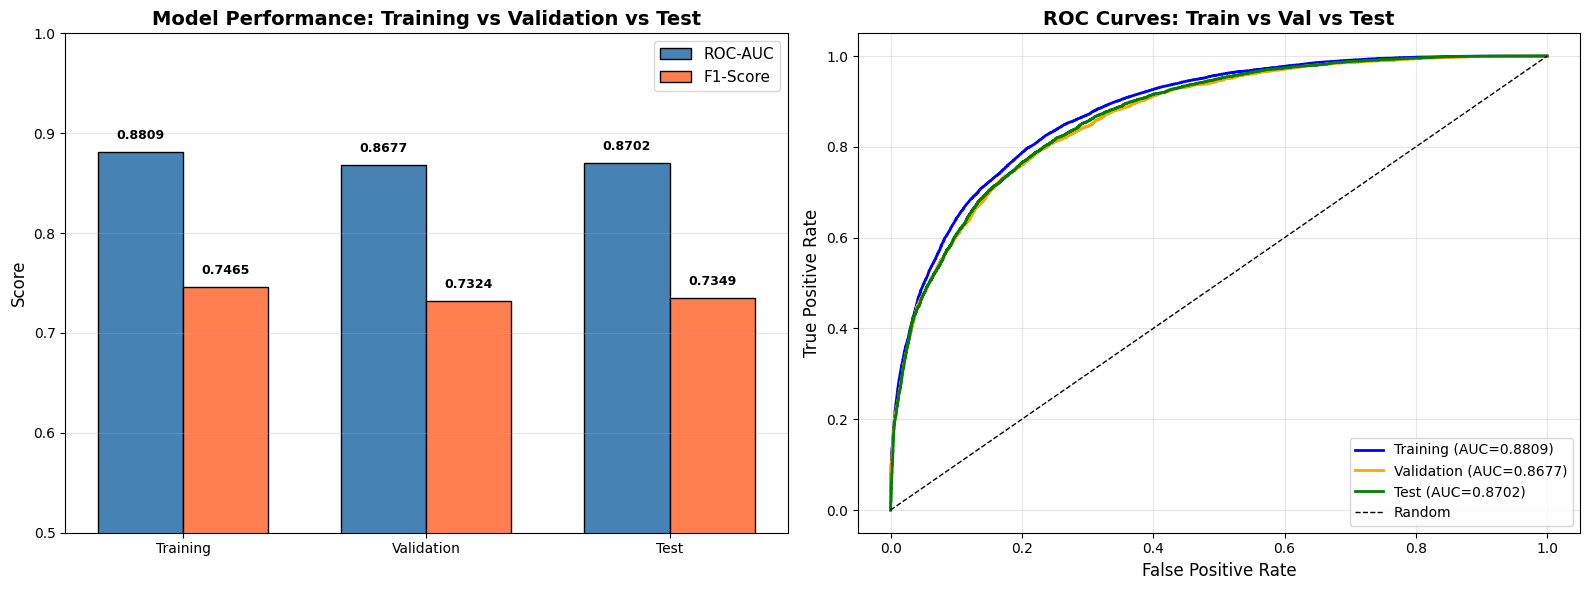


✓ Acceptable generalization (train-test gap: 0.0107)

Generating validation curves for key hyperparameters...

  Computing validation curve for max_depth...
  Computing validation curve for n_estimators...
  Computing validation curve for min_samples_split...
  Computing validation curve for min_samples_leaf...


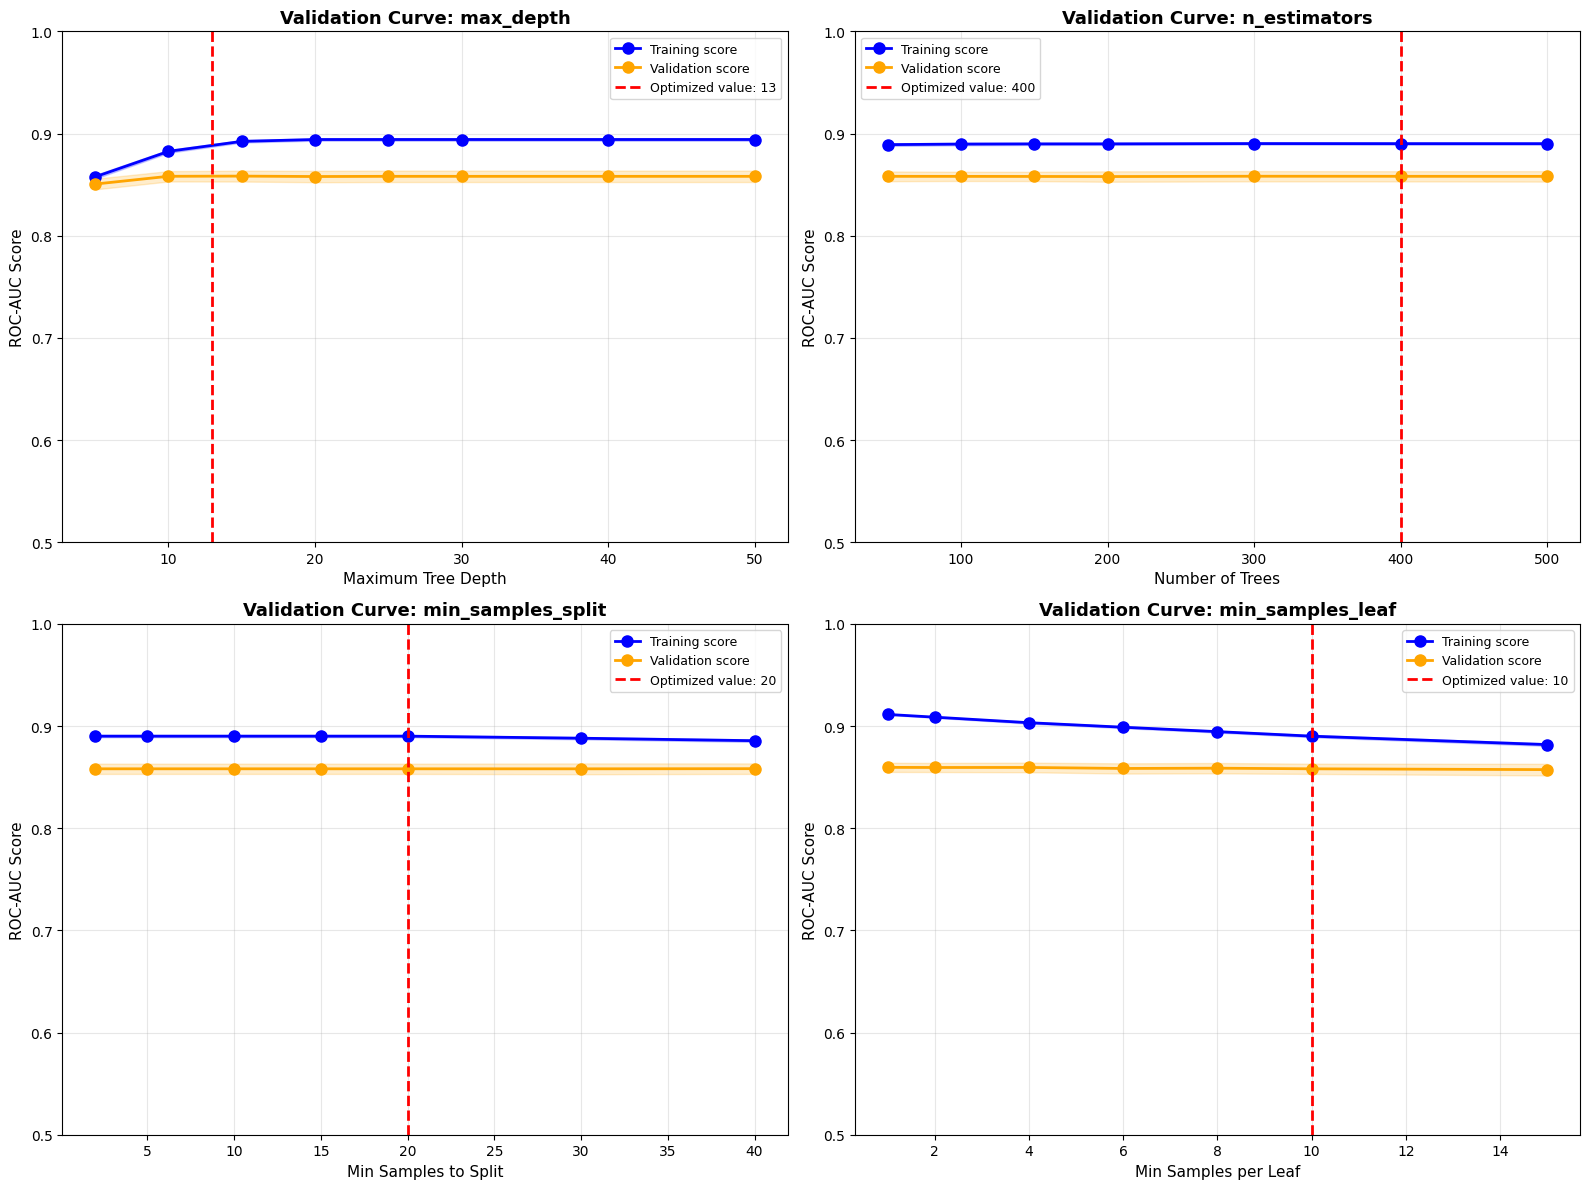


✓ Validation curves show how performance varies with each hyperparameter
✓ Gap between training and validation indicates overfitting tendency

Generating Predicted vs Actual comparison analysis...



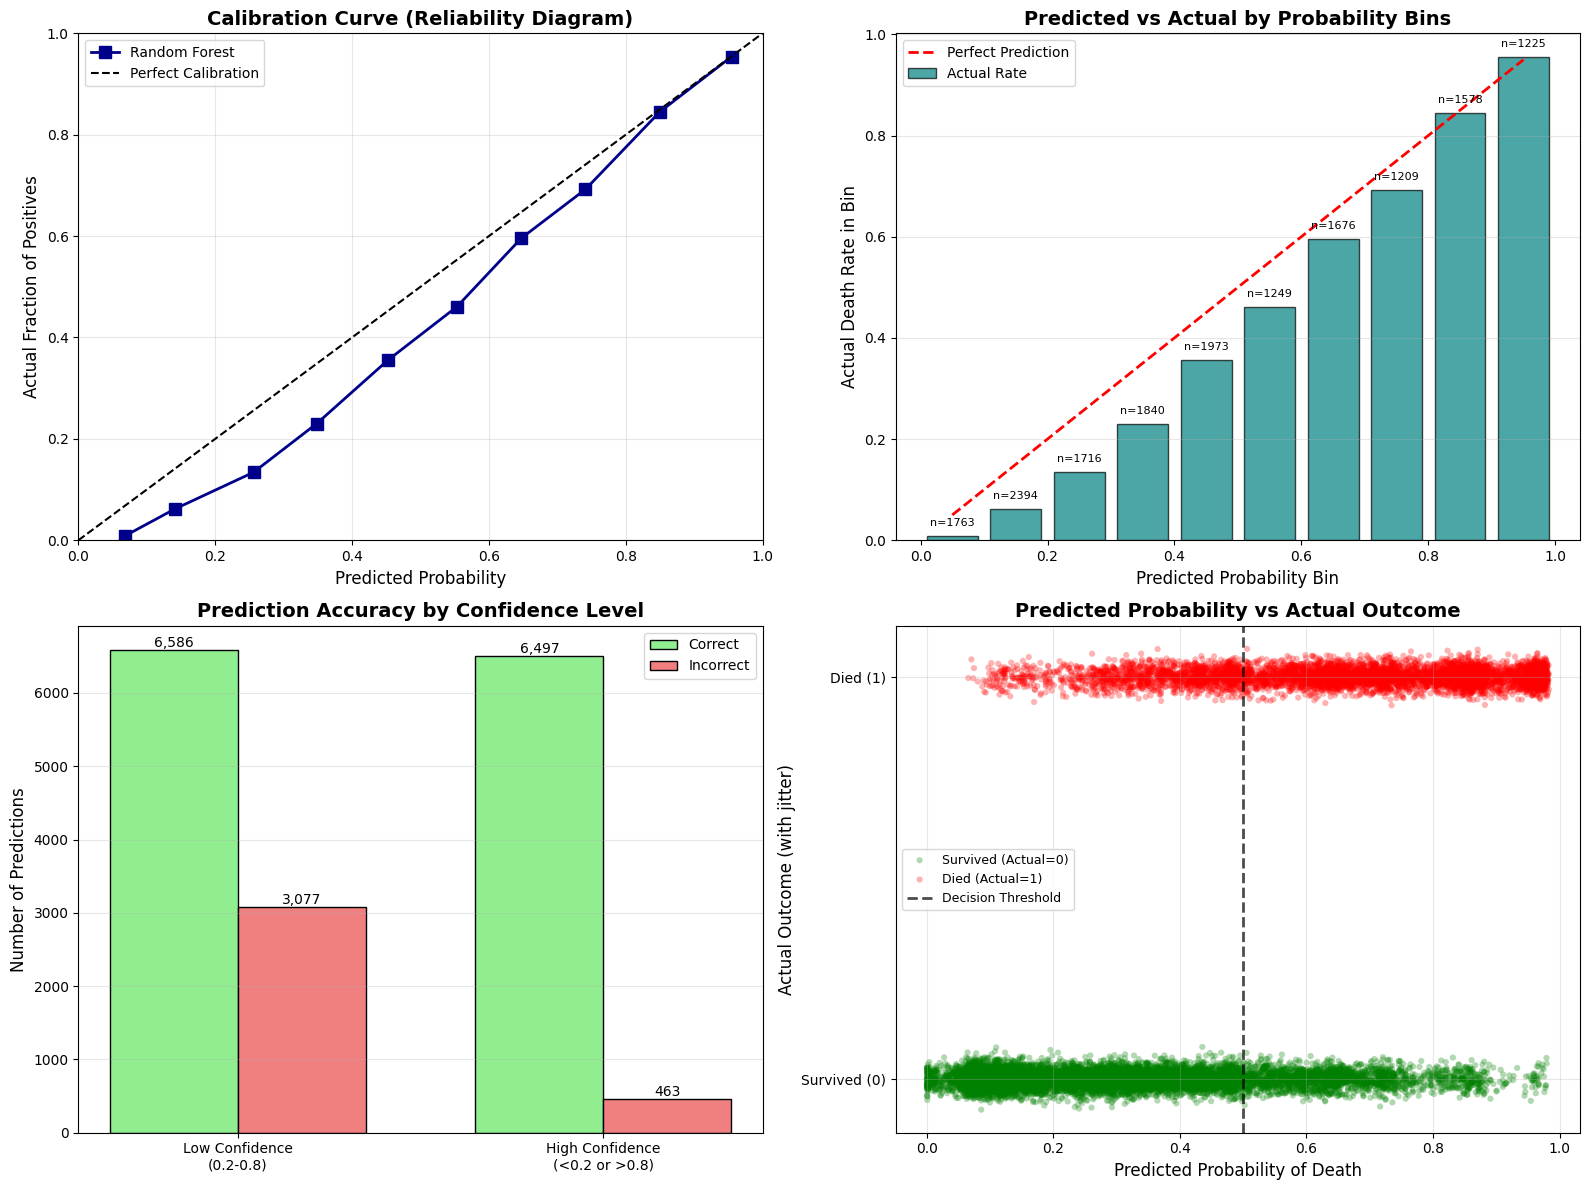

Calibration Metrics:
  Brier Score: 0.1480 (lower is better, 0=perfect)
  Expected Calibration Error: 0.0674

Prediction Confidence Breakdown:
  High Confidence Predictions: 6,960 (41.9%)
    - Correct: 6,497 (93.3%)
    - Incorrect: 463 (6.7%)
  Low Confidence Predictions: 9,663 (58.1%)
    - Correct: 6,586 (68.2%)
    - Incorrect: 3,077 (31.8%)

✓ All validation and prediction comparison visualizations complete!


In [ ]:
# ============================================================================
# 13C: RANDOM FOREST - VALIDATION CURVES & PREDICTION ANALYSIS
# ============================================================================

print_section("RANDOM FOREST - VALIDATION CURVES & PREDICTION ANALYSIS")

# ----------------------------------------------------------------------------
# 1. TRAIN-VALIDATION-TEST SPLIT FOR VALIDATION SET ANALYSIS
# ----------------------------------------------------------------------------
print("Creating validation set for performance tracking...\n")

# Split training data into train and validation
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,  # 20% of training data for validation
    random_state=TRAINING_SEED,
    stratify=y_train
)

print(f"Dataset Split:")
print(f"  Training:   {X_train_sub.shape[0]:,} samples ({100*X_train_sub.shape[0]/len(X_all_clean):.1f}%)")
print(f"  Validation: {X_val.shape[0]:,} samples ({100*X_val.shape[0]/len(X_all_clean):.1f}%)")
print(f"  Testing:    {X_test.shape[0]:,} samples ({100*X_test.shape[0]/len(X_all_clean):.1f}%)")

# Train model on training subset
rf_model_val = RandomForestClassifier(**best_rf_params)
rf_model_val.fit(X_train_sub, y_train_sub)

# Predictions on all three sets
y_pred_proba_train = rf_model_val.predict_proba(X_train_sub)[:, 1]
y_pred_proba_val = rf_model_val.predict_proba(X_val)[:, 1]
y_pred_proba_test_val = rf_model_val.predict_proba(X_test)[:, 1]

# Calculate metrics for all sets
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

train_roc = roc_auc_score(y_train_sub, y_pred_proba_train)
val_roc = roc_auc_score(y_val, y_pred_proba_val)
test_roc = roc_auc_score(y_test, y_pred_proba_test_val)

train_f1 = f1_score(y_train_sub, (y_pred_proba_train >= 0.5).astype(int))
val_f1 = f1_score(y_val, (y_pred_proba_val >= 0.5).astype(int))
test_f1 = f1_score(y_test, (y_pred_proba_test_val >= 0.5).astype(int))

print(f"\nPerformance Across Sets:")
print(f"  Train      - ROC-AUC: {train_roc:.4f}, F1: {train_f1:.4f}")
print(f"  Validation - ROC-AUC: {val_roc:.4f}, F1: {val_f1:.4f}")
print(f"  Test       - ROC-AUC: {test_roc:.4f}, F1: {test_f1:.4f}")

# Visualization: Performance across datasets
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart comparison
datasets = ['Training', 'Validation', 'Test']
roc_scores = [train_roc, val_roc, test_roc]
f1_scores = [train_f1, val_f1, test_f1]

x = np.arange(len(datasets))
width = 0.35

bars1 = axes[0].bar(x - width/2, roc_scores, width, label='ROC-AUC', color='steelblue', edgecolor='black')
bars2 = axes[0].bar(x + width/2, f1_scores, width, label='F1-Score', color='coral', edgecolor='black')

axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Model Performance: Training vs Validation vs Test', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(datasets)
axes[0].legend(fontsize=11)
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0.5, 1.0])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# ROC curves for all three sets
from sklearn.metrics import roc_curve

fpr_train, tpr_train, _ = roc_curve(y_train_sub, y_pred_proba_train)
fpr_val, tpr_val, _ = roc_curve(y_val, y_pred_proba_val)
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test_val)

axes[1].plot(fpr_train, tpr_train, linewidth=2, label=f'Training (AUC={train_roc:.4f})', color='blue')
axes[1].plot(fpr_val, tpr_val, linewidth=2, label=f'Validation (AUC={val_roc:.4f})', color='orange')
axes[1].plot(fpr_test, tpr_test, linewidth=2, label=f'Test (AUC={test_roc:.4f})', color='green')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('ROC Curves: Train vs Val vs Test', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right', fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Check for overfitting
if train_roc - test_roc > 0.05:
    print(f"\n⚠️  Warning: Possible overfitting detected (train-test gap: {train_roc - test_roc:.4f})")
elif train_roc - test_roc < 0.01:
    print(f"\n✓ Good generalization (train-test gap: {train_roc - test_roc:.4f})")
else:
    print(f"\n✓ Acceptable generalization (train-test gap: {train_roc - test_roc:.4f})")

print()

# ----------------------------------------------------------------------------
# 2. VALIDATION CURVES - HYPERPARAMETER SENSITIVITY ANALYSIS
# ----------------------------------------------------------------------------
print("Generating validation curves for key hyperparameters...\n")

from sklearn.model_selection import validation_curve

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

# Hyperparameters to test
param_configs = [
    {
        'param_name': 'max_depth',
        'param_range': [5, 10, 15, 20, 25, 30, 40, 50],
        'title': 'Validation Curve: max_depth',
        'xlabel': 'Maximum Tree Depth'
    },
    {
        'param_name': 'n_estimators',
        'param_range': [50, 100, 150, 200, 300, 400, 500],
        'title': 'Validation Curve: n_estimators',
        'xlabel': 'Number of Trees'
    },
    {
        'param_name': 'min_samples_split',
        'param_range': [2, 5, 10, 15, 20, 30, 40],
        'title': 'Validation Curve: min_samples_split',
        'xlabel': 'Min Samples to Split'
    },
    {
        'param_name': 'min_samples_leaf',
        'param_range': [1, 2, 4, 6, 8, 10, 15],
        'title': 'Validation Curve: min_samples_leaf',
        'xlabel': 'Min Samples per Leaf'
    }
]

for idx, config in enumerate(param_configs):
    print(f"  Computing validation curve for {config['param_name']}...")

    # Use a subset for faster computation
    sample_size = min(10000, len(X_train_sub))
    X_sample = X_train_sub.iloc[:sample_size] if hasattr(X_train_sub, 'iloc') else X_train_sub[:sample_size]
    y_sample = y_train_sub[:sample_size]

    # Get base parameters and update for this test
    base_params = best_rf_params.copy()
    base_params.pop(config['param_name'], None)  # Remove the parameter being tested

    train_scores, val_scores = validation_curve(
        RandomForestClassifier(**base_params),
        X_sample, y_sample,
        param_name=config['param_name'],
        param_range=config['param_range'],
        cv=3,  # 3-fold for speed
        scoring='roc_auc',
        n_jobs=-1
    )

    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)

    # Plot
    axes[idx].plot(config['param_range'], train_mean, 'o-', color='blue',
                   label='Training score', linewidth=2, markersize=8)
    axes[idx].fill_between(config['param_range'],
                           train_mean - train_std, train_mean + train_std,
                           alpha=0.2, color='blue')

    axes[idx].plot(config['param_range'], val_mean, 'o-', color='orange',
                   label='Validation score', linewidth=2, markersize=8)
    axes[idx].fill_between(config['param_range'],
                           val_mean - val_std, val_mean + val_std,
                           alpha=0.2, color='orange')

    # Mark optimal value from hyperparameter tuning
    if config['param_name'] in best_rf_params:
        optimal_val = best_rf_params[config['param_name']]
        axes[idx].axvline(x=optimal_val, color='red', linestyle='--', linewidth=2,
                         label=f'Optimized value: {optimal_val}')

    axes[idx].set_xlabel(config['xlabel'], fontsize=11)
    axes[idx].set_ylabel('ROC-AUC Score', fontsize=11)
    axes[idx].set_title(config['title'], fontsize=13, fontweight='bold')
    axes[idx].legend(loc='best', fontsize=9)
    axes[idx].grid(alpha=0.3)
    axes[idx].set_ylim([0.5, 1.0])

plt.tight_layout()
plt.show()

print("\n✓ Validation curves show how performance varies with each hyperparameter")
print("✓ Gap between training and validation indicates overfitting tendency\n")

# ----------------------------------------------------------------------------
# 3. PREDICTED VS ACTUAL COMPARISON - CALIBRATION & RELIABILITY
# ----------------------------------------------------------------------------
print("Generating Predicted vs Actual comparison analysis...\n")

from sklearn.calibration import calibration_curve

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 3A. Calibration Curve (Reliability Diagram)
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba_rf, n_bins=10, strategy='uniform')

axes[0, 0].plot(prob_pred, prob_true, 's-', linewidth=2, markersize=8,
                label='Random Forest', color='darkblue')
axes[0, 0].plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
axes[0, 0].set_xlabel('Predicted Probability', fontsize=12)
axes[0, 0].set_ylabel('Actual Fraction of Positives', fontsize=12)
axes[0, 0].set_title('Calibration Curve (Reliability Diagram)', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_xlim([0, 1])
axes[0, 0].set_ylim([0, 1])

# 3B. Predicted Probability vs Actual Outcome (Binned)
bins = np.linspace(0, 1, 11)
bin_centers = (bins[:-1] + bins[1:]) / 2
actual_by_bin = []
counts_by_bin = []

for i in range(len(bins)-1):
    mask = (y_pred_proba_rf >= bins[i]) & (y_pred_proba_rf < bins[i+1])
    if mask.sum() > 0:
        actual_by_bin.append(y_test[mask].mean())
        counts_by_bin.append(mask.sum())
    else:
        actual_by_bin.append(0)
        counts_by_bin.append(0)

axes[0, 1].bar(bin_centers, actual_by_bin, width=0.08, alpha=0.7,
               color='teal', edgecolor='black', label='Actual Rate')
axes[0, 1].plot(bin_centers, bin_centers, 'r--', linewidth=2, label='Perfect Prediction')
axes[0, 1].set_xlabel('Predicted Probability Bin', fontsize=12)
axes[0, 1].set_ylabel('Actual Death Rate in Bin', fontsize=12)
axes[0, 1].set_title('Predicted vs Actual by Probability Bins', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(alpha=0.3, axis='y')

# Add count labels
for i, (center, count) in enumerate(zip(bin_centers, counts_by_bin)):
    if count > 0:
        axes[0, 1].text(center, actual_by_bin[i] + 0.02, f'n={count}',
                       ha='center', fontsize=8, rotation=0)

# 3C. Prediction Confidence Analysis
correct_predictions = (y_pred_rf == y_test)
confident_correct = np.abs(y_pred_proba_rf - 0.5) >= 0.3  # High confidence threshold

confidence_data = pd.DataFrame({
    'Correct': correct_predictions,
    'Confident': confident_correct,
    'Probability': y_pred_proba_rf
})

# Group by confidence and correctness
low_conf_correct = ((confidence_data['Confident'] == False) & (confidence_data['Correct'] == True)).sum()
low_conf_incorrect = ((confidence_data['Confident'] == False) & (confidence_data['Correct'] == False)).sum()
high_conf_correct = ((confidence_data['Confident'] == True) & (confidence_data['Correct'] == True)).sum()
high_conf_incorrect = ((confidence_data['Confident'] == True) & (confidence_data['Correct'] == False)).sum()

categories = ['Low Confidence\n(0.2-0.8)', 'High Confidence\n(<0.2 or >0.8)']
correct_counts = [low_conf_correct, high_conf_correct]
incorrect_counts = [low_conf_incorrect, high_conf_incorrect]

x = np.arange(len(categories))
width = 0.35

bars1 = axes[1, 0].bar(x - width/2, correct_counts, width, label='Correct',
                       color='lightgreen', edgecolor='black')
bars2 = axes[1, 0].bar(x + width/2, incorrect_counts, width, label='Incorrect',
                       color='lightcoral', edgecolor='black')

axes[1, 0].set_ylabel('Number of Predictions', fontsize=12)
axes[1, 0].set_title('Prediction Accuracy by Confidence Level', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(categories)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(axis='y', alpha=0.3)

# Add percentage labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height):,}', ha='center', va='bottom', fontsize=10)

# 3D. Scatter plot - Predicted Probability vs Actual (with jitter)
np.random.seed(TRAINING_SEED)
jitter = np.random.normal(0, 0.02, size=len(y_test))

axes[1, 1].scatter(y_pred_proba_rf[y_test == 0], y_test[y_test == 0] + jitter[y_test == 0],
                  alpha=0.3, s=20, c='green', label='Survived (Actual=0)', edgecolors='none')
axes[1, 1].scatter(y_pred_proba_rf[y_test == 1], y_test[y_test == 1] + jitter[y_test == 1],
                  alpha=0.3, s=20, c='red', label='Died (Actual=1)', edgecolors='none')
axes[1, 1].axvline(x=0.5, color='black', linestyle='--', linewidth=2, alpha=0.7, label='Decision Threshold')
axes[1, 1].set_xlabel('Predicted Probability of Death', fontsize=12)
axes[1, 1].set_ylabel('Actual Outcome (with jitter)', fontsize=12)
axes[1, 1].set_title('Predicted Probability vs Actual Outcome', fontsize=14, fontweight='bold')
axes[1, 1].set_yticks([0, 1])
axes[1, 1].set_yticklabels(['Survived (0)', 'Died (1)'])
axes[1, 1].legend(fontsize=9, loc='center left')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print calibration statistics
from sklearn.metrics import brier_score_loss

brier_score = brier_score_loss(y_test, y_pred_proba_rf)
print(f"Calibration Metrics:")
print(f"  Brier Score: {brier_score:.4f} (lower is better, 0=perfect)")
print(f"  Expected Calibration Error: {np.abs(prob_true - prob_pred).mean():.4f}")
print(f"\nPrediction Confidence Breakdown:")
print(f"  High Confidence Predictions: {high_conf_correct + high_conf_incorrect:,} ({100*(high_conf_correct + high_conf_incorrect)/len(y_test):.1f}%)")
print(f"    - Correct: {high_conf_correct:,} ({100*high_conf_correct/(high_conf_correct + high_conf_incorrect):.1f}%)")
print(f"    - Incorrect: {high_conf_incorrect:,} ({100*high_conf_incorrect/(high_conf_correct + high_conf_incorrect):.1f}%)")
print(f"  Low Confidence Predictions: {low_conf_correct + low_conf_incorrect:,} ({100*(low_conf_correct + low_conf_incorrect)/len(y_test):.1f}%)")
print(f"    - Correct: {low_conf_correct:,} ({100*low_conf_correct/(low_conf_correct + low_conf_incorrect):.1f}%)")
print(f"    - Incorrect: {low_conf_incorrect:,} ({100*low_conf_incorrect/(low_conf_correct + low_conf_incorrect):.1f}%)")

print("\n✓ All validation and prediction comparison visualizations complete!")

In [ ]:
# ============================================================================
# 14: XGBOOST - HYPERPARAMETER TUNING
# ============================================================================

print_section("XGBOOST - HYPERPARAMETER TUNING")

print("Starting Optuna optimization with 10 trials...\n")

def objective_xgb(trial):
    """Objective function for XGBoost hyperparameter optimization"""

    # Calculate scale_pos_weight for class imbalance
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'scale_pos_weight': scale_pos_weight,
        'random_state': TRAINING_SEED,
        'n_jobs': -1,
        'tree_method': 'hist'
    }

    # 5-fold stratified cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=TRAINING_SEED)
    model = XGBClassifier(**params, eval_metric='logloss')

    scores = cross_validate(
        model, X_train, y_train, cv=cv,
        scoring='average_precision',
        n_jobs=-1
    )

    return scores['test_score'].mean()

# Create and run Optuna study
study_xgb = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=TRAINING_SEED)
)

study_xgb.optimize(objective_xgb, n_trials=10, show_progress_bar=True)

print(f"\n{'='*80}")
print(f"✓ Optimization Complete")
print(f"✓ Best PR-AUC: {study_xgb.best_value:.4f}")
print(f"{'='*80}")
print(f"\nBest Hyperparameters:")
for param, value in study_xgb.best_params.items():
    print(f"  {param:20s}: {value}")

# Store best parameters
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
best_xgb_params = study_xgb.best_params.copy()
best_xgb_params['scale_pos_weight'] = scale_pos_weight
best_xgb_params['random_state'] = TRAINING_SEED
best_xgb_params['n_jobs'] = -1
best_xgb_params['tree_method'] = 'hist'

# Clean up memory
gc.collect()

[I 2025-12-02 14:35:59,389] A new study created in memory with name: no-name-3707d9b2-af04-479e-a0dc-4914a56a5d72



XGBOOST - HYPERPARAMETER TUNING

Starting Optuna optimization with 10 trials...



  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-02 14:36:12,504] Trial 0 finished with value: 0.8108601320581533 and parameters: {'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.07475612091546033, 'min_child_weight': 9, 'subsample': 0.6850183833569111, 'colsample_bytree': 0.921421389969683, 'gamma': 4.208919893283768, 'reg_alpha': 1.9890034765363473, 'reg_lambda': 0.4089165621897928}. Best is trial 0 with value: 0.8108601320581533.
[I 2025-12-02 14:36:33,084] Trial 1 finished with value: 0.8104190205906285 and parameters: {'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.01036044506013514, 'min_child_weight': 9, 'subsample': 0.6223865420349501, 'colsample_bytree': 0.6654206144251413, 'gamma': 0.6195696865767092, 'reg_alpha': 0.2993634036506554, 'reg_lambda': 0.24455431650573511}. Best is trial 0 with value: 0.8108601320581533.
[I 2025-12-02 14:36:39,795] Trial 2 finished with value: 0.8104828814052369 and parameters: {'n_estimators': 100, 'max_depth': 14, 'learning_rate': 0.07888912522502249, 'min_child_we

599

In [ ]:
# ============================================================================
# 15: XGBOOST - MODEL TRAINING & EVALUATION
# ============================================================================

print_section("XGBOOST - MODEL TRAINING")

print("Training XGBoost with optimized hyperparameters...\n")

# Train final model
xgb_model = XGBClassifier(**best_xgb_params, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate model
xgb_metrics = evaluate_model(y_test, y_pred_xgb, y_pred_proba_xgb)

print("✓ Training Complete\n")
print(f"{'='*80}")
print("XGBOOST PERFORMANCE")
print(f"{'='*80}")
print(f"ROC-AUC:    {xgb_metrics['ROC-AUC']:.4f}")
print(f"F1-Score:   {xgb_metrics['F1-Score']:.4f}")
print(f"Accuracy:   {xgb_metrics['Accuracy']:.4f}")
print(f"Precision:  {xgb_metrics['Precision']:.4f}")
print(f"Recall:     {xgb_metrics['Recall']:.4f}")
print(f"\nConfusion Matrix:")
print(f"  TN: {xgb_metrics['TN']:,} | FP: {xgb_metrics['FP']:,}")
print(f"  FN: {xgb_metrics['FN']:,} | TP: {xgb_metrics['TP']:,}")
print(f"{'='*80}")


XGBOOST - MODEL TRAINING

Training XGBoost with optimized hyperparameters...

✓ Training Complete

XGBOOST PERFORMANCE
ROC-AUC:    0.8741
F1-Score:   0.7374
Accuracy:   0.7820
Precision:  0.6904
Recall:     0.7914

Confusion Matrix:
  TN: 7,912 | FP: 2,282
  FN: 1,341 | TP: 5,088



XGBOOST - DETAILED VISUALIZATION & ANALYSIS

Generating feature importance analysis...



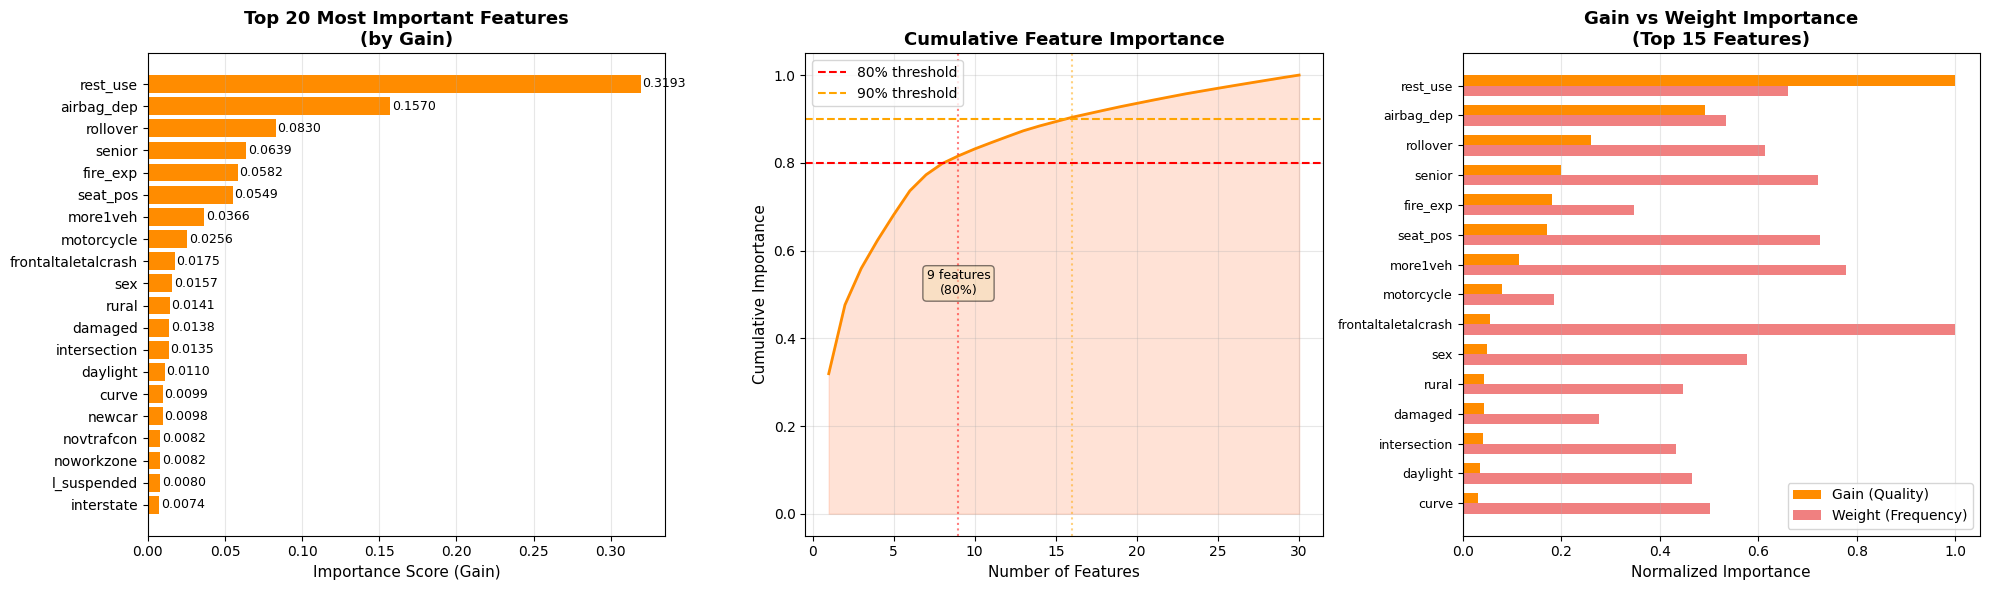

✓ Top 5 features (by gain): rest_use, airbag_dep, rollover, senior, fire_exp
✓ Features needed for 80% importance: 9/30
✓ Features needed for 90% importance: 16/30

Generating ROC and Precision-Recall curves...



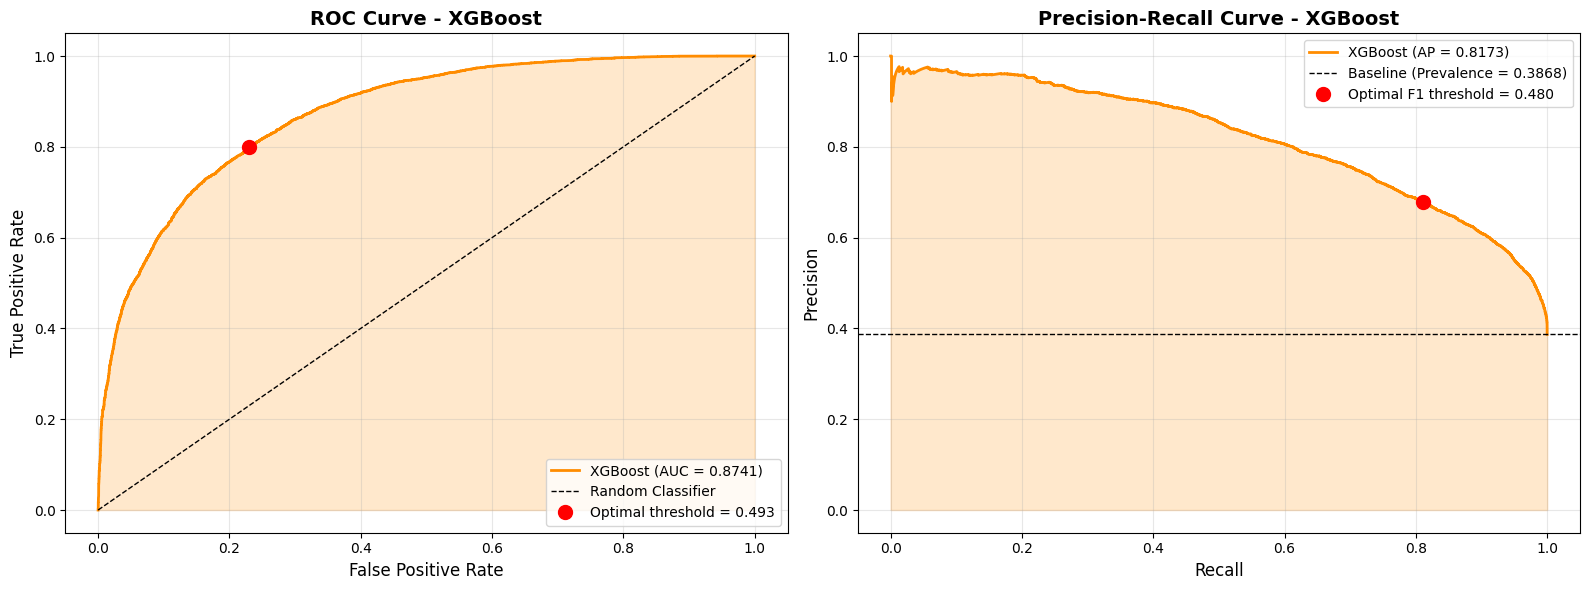

✓ ROC-AUC: 0.8741
✓ Precision-Recall AUC: 0.8173
✓ Optimal ROC threshold: 0.4930 (maximizes TPR-FPR)
✓ Optimal F1 threshold: 0.4801 (maximizes F1-Score)

Generating detailed confusion matrix...



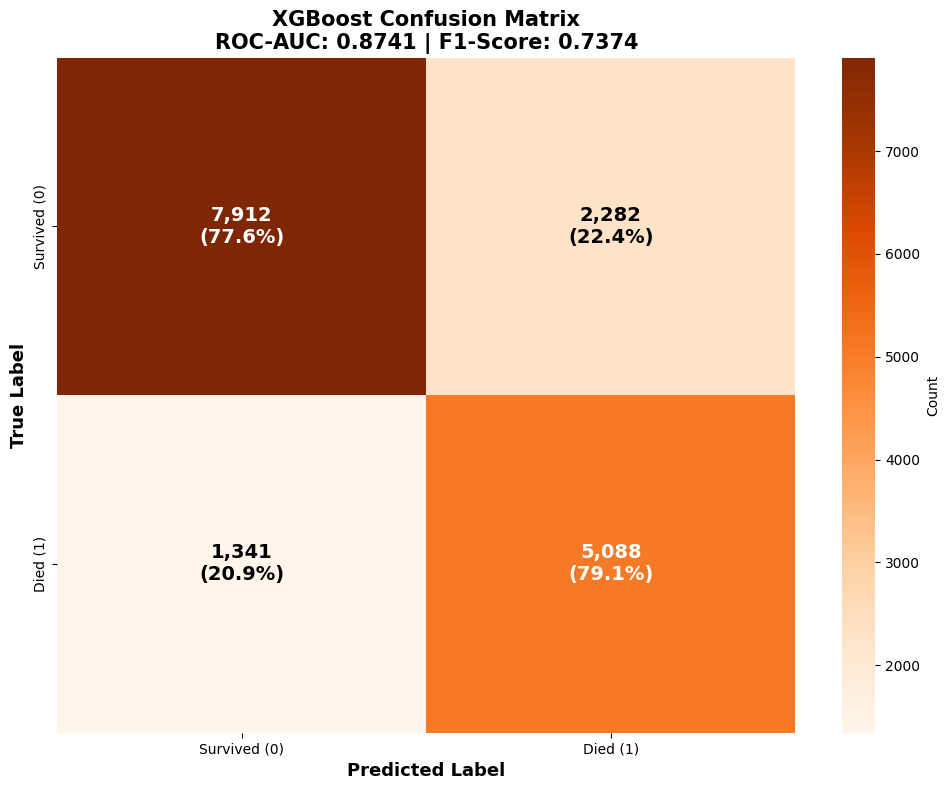

Confusion Matrix Breakdown:
  True Negatives (TN):  7,912 - Correctly predicted survivors
  False Positives (FP): 2,282 - Survivors incorrectly predicted as died
  False Negatives (FN): 1,341 - Deaths incorrectly predicted as survived
  True Positives (TP):  5,088 - Correctly predicted deaths

Additional Metrics:
  Sensitivity (Recall): 0.7914 - % of actual deaths correctly identified
  Specificity:          0.7761 - % of actual survivors correctly identified
  PPV (Precision):      0.6904 - % of predicted deaths that actually died
  NPV:                  0.8551 - % of predicted survivors that actually survived

Analyzing prediction probability distributions...



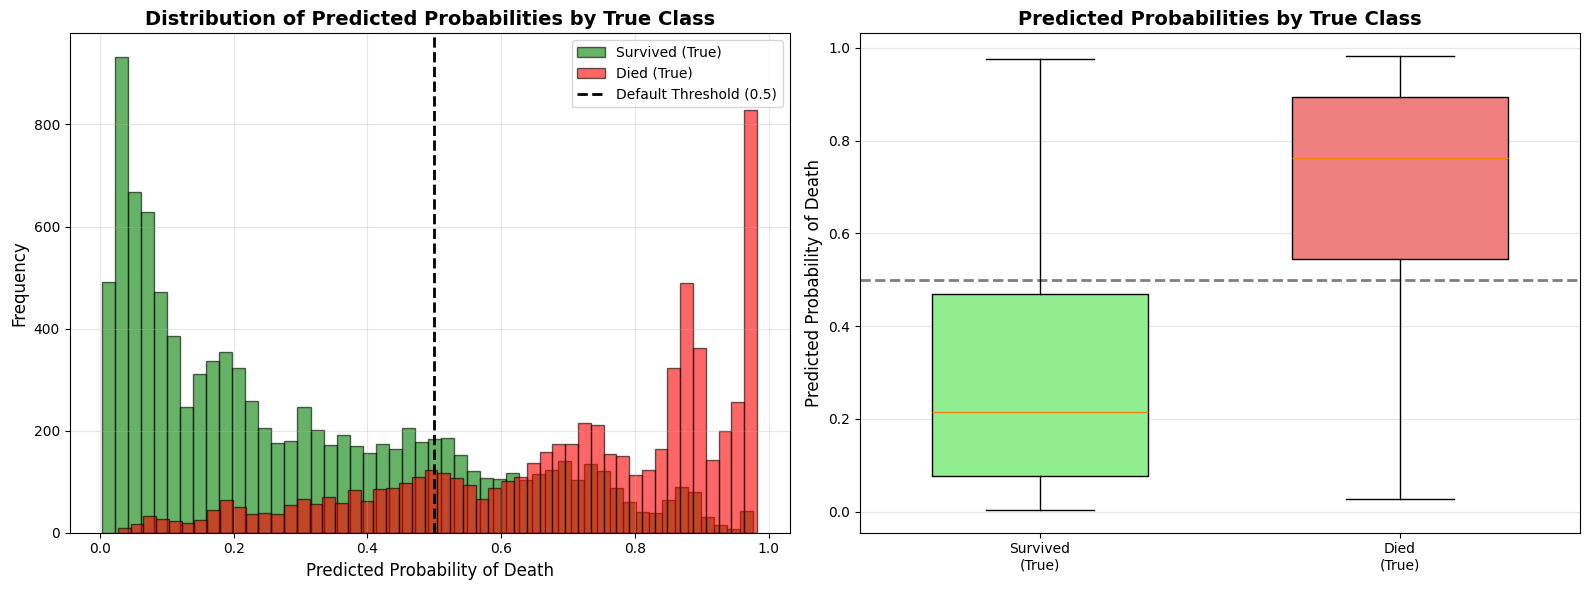

Probability Distribution Statistics:
  Survived (True) - Mean: 0.2937, Std: 0.2489
  Died (True)     - Mean: 0.7088, Std: 0.2365
  Separation:       0.4150

✓ Good separation indicates model can distinguish between classes

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Survived     0.8551    0.7761    0.8137     10194
        Died     0.6904    0.7914    0.7374      6429

    accuracy                         0.7820     16623
   macro avg     0.7727    0.7838    0.7756     16623
weighted avg     0.7914    0.7820    0.7842     16623


XGBOOST MODEL SUMMARY
               Metric  Value
              ROC-AUC 0.8741
               PR-AUC 0.8173
             F1-Score 0.7374
             Accuracy 0.7820
            Precision 0.6904
               Recall 0.7914
          Specificity 0.7761
                  PPV 0.6904
                  NPV 0.8551
Optimal ROC Threshold 0.4930
 Optimal F1 Threshold 0.4801

✓ XGBoost detailed analysis complete!


In [ ]:
# ============================================================================
# 15B: XGBOOST - DETAILED VISUALIZATION & ANALYSIS
# ============================================================================

print_section("XGBOOST - DETAILED VISUALIZATION & ANALYSIS")

# ----------------------------------------------------------------------------
# 1. FEATURE IMPORTANCE ANALYSIS
# ----------------------------------------------------------------------------
print("Generating feature importance analysis...\n")

# Get feature importances (XGBoost has multiple importance types)
feature_importance_gain = pd.DataFrame({
    'feature': X_train.columns,
    'importance_gain': xgb_model.feature_importances_  # Default is 'gain'
}).sort_values('importance_gain', ascending=False)

# Also get 'weight' (frequency) importance
importance_weight = xgb_model.get_booster().get_score(importance_type='weight')
feature_importance_weight = pd.DataFrame({
    'feature': list(importance_weight.keys()),
    'importance_weight': list(importance_weight.values())
}).sort_values('importance_weight', ascending=False)

# Merge both importance types
feature_importance = feature_importance_gain.merge(
    feature_importance_weight, on='feature', how='left'
).fillna(0)

# Plot top 20 features
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Bar plot - Top 20 by gain
top_20 = feature_importance.head(20)
axes[0].barh(range(len(top_20)), top_20['importance_gain'].values, color='darkorange')
axes[0].set_yticks(range(len(top_20)))
axes[0].set_yticklabels(top_20['feature'].values)
axes[0].invert_yaxis()
axes[0].set_xlabel('Importance Score (Gain)', fontsize=11)
axes[0].set_title('Top 20 Most Important Features\n(by Gain)', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(top_20.iterrows()):
    axes[0].text(row['importance_gain'] + 0.001, i, f"{row['importance_gain']:.4f}",
                va='center', fontsize=9)

# Cumulative importance
feature_importance_sorted = feature_importance.sort_values('importance_gain', ascending=False)
cumsum = feature_importance_sorted['importance_gain'].cumsum() / feature_importance_sorted['importance_gain'].sum()
axes[1].plot(range(1, len(cumsum)+1), cumsum, linewidth=2, color='darkorange')
axes[1].axhline(y=0.8, color='red', linestyle='--', label='80% threshold')
axes[1].axhline(y=0.9, color='orange', linestyle='--', label='90% threshold')
axes[1].fill_between(range(1, len(cumsum)+1), cumsum, alpha=0.3, color='lightsalmon')
axes[1].set_xlabel('Number of Features', fontsize=11)
axes[1].set_ylabel('Cumulative Importance', fontsize=11)
axes[1].set_title('Cumulative Feature Importance', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Find features needed for 80% and 90%
n_80 = (cumsum >= 0.8).idxmax() + 1
n_90 = (cumsum >= 0.9).idxmax() + 1
axes[1].axvline(x=n_80, color='red', linestyle=':', alpha=0.5)
axes[1].axvline(x=n_90, color='orange', linestyle=':', alpha=0.5)
axes[1].text(n_80, 0.5, f'{n_80} features\n(80%)', ha='center', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Compare Gain vs Weight importance for top 15
top_15_features = feature_importance.head(15)
x_pos = np.arange(len(top_15_features))
width = 0.35

# Normalize for comparison
gain_norm = top_15_features['importance_gain'] / top_15_features['importance_gain'].max()
weight_norm = top_15_features['importance_weight'] / top_15_features['importance_weight'].max()

axes[2].barh(x_pos - width/2, gain_norm, width, label='Gain (Quality)', color='darkorange')
axes[2].barh(x_pos + width/2, weight_norm, width, label='Weight (Frequency)', color='lightcoral')
axes[2].set_yticks(x_pos)
axes[2].set_yticklabels(top_15_features['feature'].values, fontsize=9)
axes[2].invert_yaxis()
axes[2].set_xlabel('Normalized Importance', fontsize=11)
axes[2].set_title('Gain vs Weight Importance\n(Top 15 Features)', fontsize=13, fontweight='bold')
axes[2].legend()
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ Top 5 features (by gain): {', '.join(feature_importance.head(5)['feature'].values)}")
print(f"✓ Features needed for 80% importance: {n_80}/{len(feature_importance)}")
print(f"✓ Features needed for 90% importance: {n_90}/{len(feature_importance)}\n")

# ----------------------------------------------------------------------------
# 2. ROC CURVE & PRECISION-RECALL CURVE
# ----------------------------------------------------------------------------
print("Generating ROC and Precision-Recall curves...\n")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba_xgb)
roc_auc = roc_auc_score(y_test, y_pred_proba_xgb)

axes[0].plot(fpr, tpr, linewidth=2, label=f'XGBoost (AUC = {roc_auc:.4f})', color='darkorange')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[0].fill_between(fpr, tpr, alpha=0.2, color='darkorange')
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve - XGBoost', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(alpha=0.3)

# Add optimal threshold point
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds_roc[optimal_idx]
axes[0].plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=10,
            label=f'Optimal threshold = {optimal_threshold:.3f}')
axes[0].legend(loc='lower right', fontsize=10)

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba_xgb)
pr_auc = average_precision_score(y_test, y_pred_proba_xgb)

axes[1].plot(recall, precision, linewidth=2, label=f'XGBoost (AP = {pr_auc:.4f})', color='darkorange')
axes[1].axhline(y=y_test.mean(), color='k', linestyle='--', linewidth=1,
                label=f'Baseline (Prevalence = {y_test.mean():.4f})')
axes[1].fill_between(recall, precision, alpha=0.2, color='darkorange')
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve - XGBoost', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(alpha=0.3)

# Add F1-optimal threshold point
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)
optimal_f1_idx = np.argmax(f1_scores)
axes[1].plot(recall[optimal_f1_idx], precision[optimal_f1_idx], 'ro', markersize=10,
            label=f'Optimal F1 threshold = {thresholds_pr[optimal_f1_idx]:.3f}')
axes[1].legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

print(f"✓ ROC-AUC: {roc_auc:.4f}")
print(f"✓ Precision-Recall AUC: {pr_auc:.4f}")
print(f"✓ Optimal ROC threshold: {optimal_threshold:.4f} (maximizes TPR-FPR)")
print(f"✓ Optimal F1 threshold: {thresholds_pr[optimal_f1_idx]:.4f} (maximizes F1-Score)\n")

# ----------------------------------------------------------------------------
# 3. CONFUSION MATRIX WITH DETAILED ANNOTATIONS
# ----------------------------------------------------------------------------
print("Generating detailed confusion matrix...\n")

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

cm = confusion_matrix(y_test, y_pred_xgb)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create annotated heatmap
sns.heatmap(cm, annot=False, fmt='d', cmap='Oranges', ax=ax,
            xticklabels=['Survived (0)', 'Died (1)'],
            yticklabels=['Survived (0)', 'Died (1)'],
            cbar_kws={'label': 'Count'})

# Add detailed annotations
for i in range(2):
    for j in range(2):
        count = cm[i, j]
        percentage = cm_normalized[i, j] * 100
        text = f'{count:,}\n({percentage:.1f}%)'
        ax.text(j + 0.5, i + 0.5, text, ha='center', va='center',
               fontsize=14, fontweight='bold',
               color='white' if cm[i, j] > cm.max() / 2 else 'black')

ax.set_ylabel('True Label', fontsize=13, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=13, fontweight='bold')
ax.set_title(f'XGBoost Confusion Matrix\nROC-AUC: {roc_auc:.4f} | F1-Score: {xgb_metrics["F1-Score"]:.4f}',
            fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
ppv = tp / (tp + fp)  # Positive Predictive Value
npv = tn / (tn + fn)  # Negative Predictive Value

print(f"Confusion Matrix Breakdown:")
print(f"  True Negatives (TN):  {tn:,} - Correctly predicted survivors")
print(f"  False Positives (FP): {fp:,} - Survivors incorrectly predicted as died")
print(f"  False Negatives (FN): {fn:,} - Deaths incorrectly predicted as survived")
print(f"  True Positives (TP):  {tp:,} - Correctly predicted deaths")
print(f"\nAdditional Metrics:")
print(f"  Sensitivity (Recall): {sensitivity:.4f} - % of actual deaths correctly identified")
print(f"  Specificity:          {specificity:.4f} - % of actual survivors correctly identified")
print(f"  PPV (Precision):      {ppv:.4f} - % of predicted deaths that actually died")
print(f"  NPV:                  {npv:.4f} - % of predicted survivors that actually survived\n")

# ----------------------------------------------------------------------------
# 4. PREDICTION DISTRIBUTION ANALYSIS
# ----------------------------------------------------------------------------
print("Analyzing prediction probability distributions...\n")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribution of predicted probabilities by true class
axes[0].hist(y_pred_proba_xgb[y_test == 0], bins=50, alpha=0.6, label='Survived (True)',
            color='green', edgecolor='black')
axes[0].hist(y_pred_proba_xgb[y_test == 1], bins=50, alpha=0.6, label='Died (True)',
            color='red', edgecolor='black')
axes[0].axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Default Threshold (0.5)')
axes[0].set_xlabel('Predicted Probability of Death', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Predicted Probabilities by True Class', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Box plot comparison
data_to_plot = [
    y_pred_proba_xgb[y_test == 0],
    y_pred_proba_xgb[y_test == 1]
]
bp = axes[1].boxplot(data_to_plot, labels=['Survived\n(True)', 'Died\n(True)'],
                     patch_artist=True, widths=0.6)
bp['boxes'][0].set_facecolor('lightgreen')
bp['boxes'][1].set_facecolor('lightcoral')
axes[1].axhline(y=0.5, color='black', linestyle='--', linewidth=2, alpha=0.5)
axes[1].set_ylabel('Predicted Probability of Death', fontsize=12)
axes[1].set_title('Predicted Probabilities by True Class', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate separation metrics
mean_prob_died = y_pred_proba_xgb[y_test == 1].mean()
mean_prob_survived = y_pred_proba_xgb[y_test == 0].mean()
std_prob_died = y_pred_proba_xgb[y_test == 1].std()
std_prob_survived = y_pred_proba_xgb[y_test == 0].std()

print(f"Probability Distribution Statistics:")
print(f"  Survived (True) - Mean: {mean_prob_survived:.4f}, Std: {std_prob_survived:.4f}")
print(f"  Died (True)     - Mean: {mean_prob_died:.4f}, Std: {std_prob_died:.4f}")
print(f"  Separation:       {abs(mean_prob_died - mean_prob_survived):.4f}")
print(f"\n✓ Good separation indicates model can distinguish between classes\n")

# ----------------------------------------------------------------------------
# 5. CLASSIFICATION REPORT
# ----------------------------------------------------------------------------
print("="*80)
print("CLASSIFICATION REPORT")
print("="*80)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_xgb, target_names=['Survived', 'Died'], digits=4))

# ----------------------------------------------------------------------------
# 6. MODEL SUMMARY TABLE
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("XGBOOST MODEL SUMMARY")
print("="*80)

summary_data = {
    'Metric': [
        'ROC-AUC', 'PR-AUC', 'F1-Score', 'Accuracy', 'Precision', 'Recall',
        'Specificity', 'PPV', 'NPV', 'Optimal ROC Threshold', 'Optimal F1 Threshold'
    ],
    'Value': [
        f"{roc_auc:.4f}",
        f"{pr_auc:.4f}",
        f"{xgb_metrics['F1-Score']:.4f}",
        f"{xgb_metrics['Accuracy']:.4f}",
        f"{xgb_metrics['Precision']:.4f}",
        f"{xgb_metrics['Recall']:.4f}",
        f"{specificity:.4f}",
        f"{ppv:.4f}",
        f"{npv:.4f}",
        f"{optimal_threshold:.4f}",
        f"{thresholds_pr[optimal_f1_idx]:.4f}"
    ]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))
print("="*80)

# Store extended metrics for later comparison
xgb_metrics_extended = {
    **xgb_metrics,
    'PR-AUC': pr_auc,
    'Specificity': specificity,
    'PPV': ppv,
    'NPV': npv,
    'Optimal_ROC_Threshold': optimal_threshold,
    'Optimal_F1_Threshold': thresholds_pr[optimal_f1_idx]
}

print("\n✓ XGBoost detailed analysis complete!")


XGBOOST - VALIDATION CURVES & PREDICTION ANALYSIS

Creating validation set for performance tracking...

Dataset Split:
  Training:   53,190 samples (64.0%)
  Validation: 13,298 samples (16.0%)
  Testing:    16,623 samples (20.0%)

Performance Across Sets:
  Train      - ROC-AUC: 0.8799, F1: 0.7479
  Validation - ROC-AUC: 0.8708, F1: 0.7367
  Test       - ROC-AUC: 0.8736, F1: 0.7363


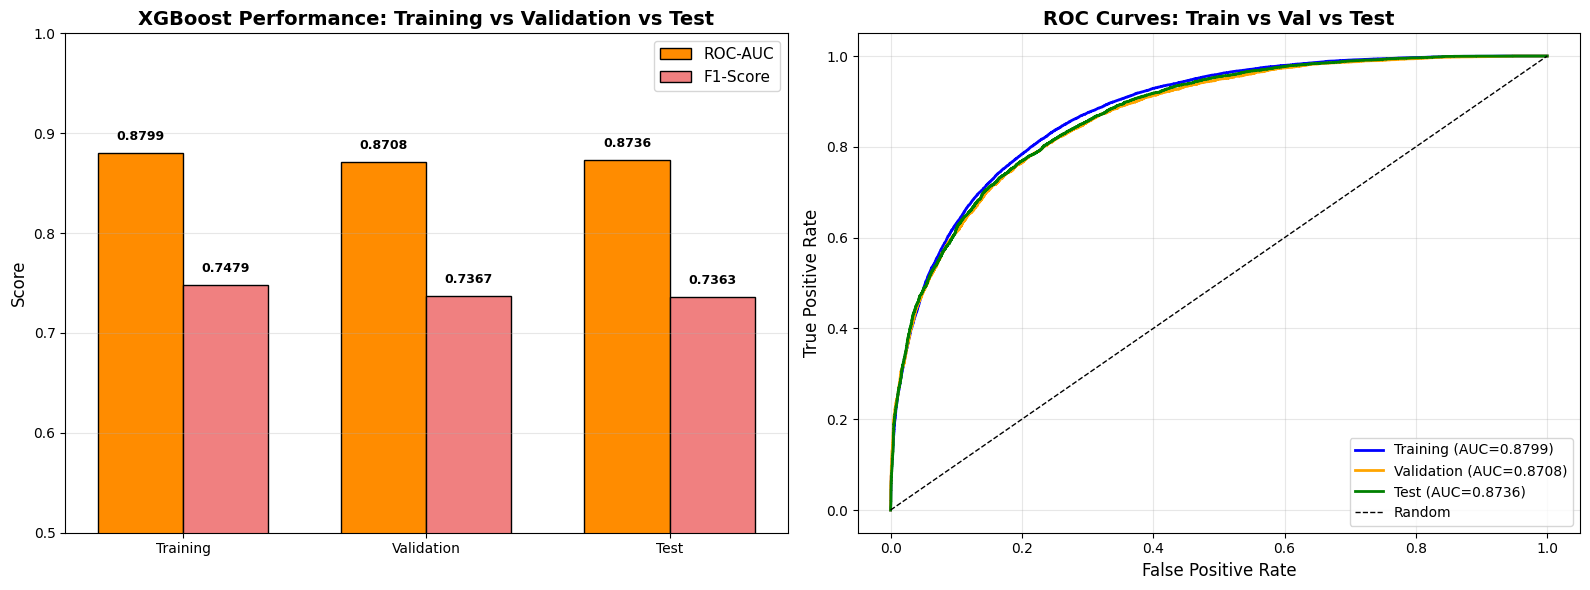


✓ Excellent generalization (train-test gap: 0.0063)

Generating validation curves for key hyperparameters...

  Computing validation curve for max_depth...
  Computing validation curve for n_estimators...
  Computing validation curve for learning_rate...
  Computing validation curve for min_child_weight...
  Computing validation curve for subsample...
  Computing validation curve for gamma...


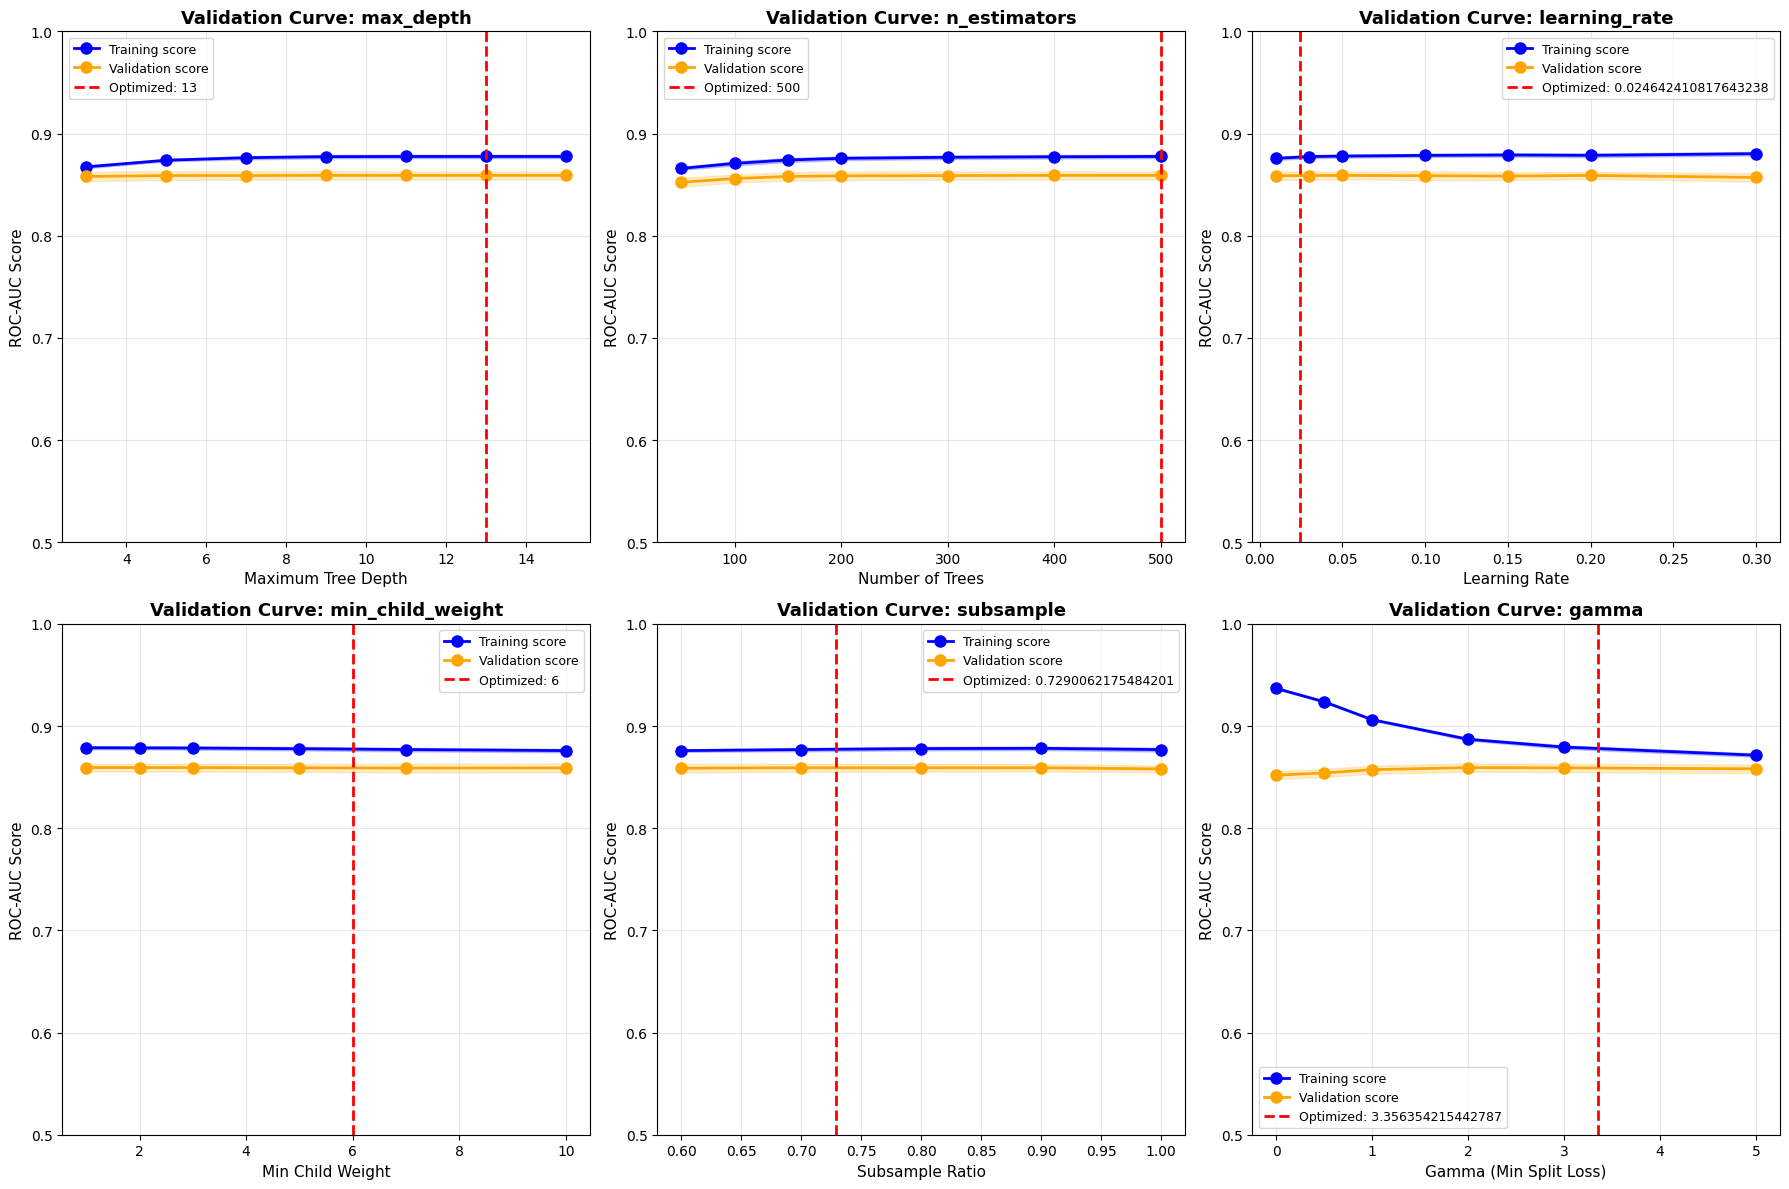


✓ Validation curves show how performance varies with each hyperparameter
✓ Gap between training and validation indicates overfitting tendency

Generating Predicted vs Actual comparison analysis...



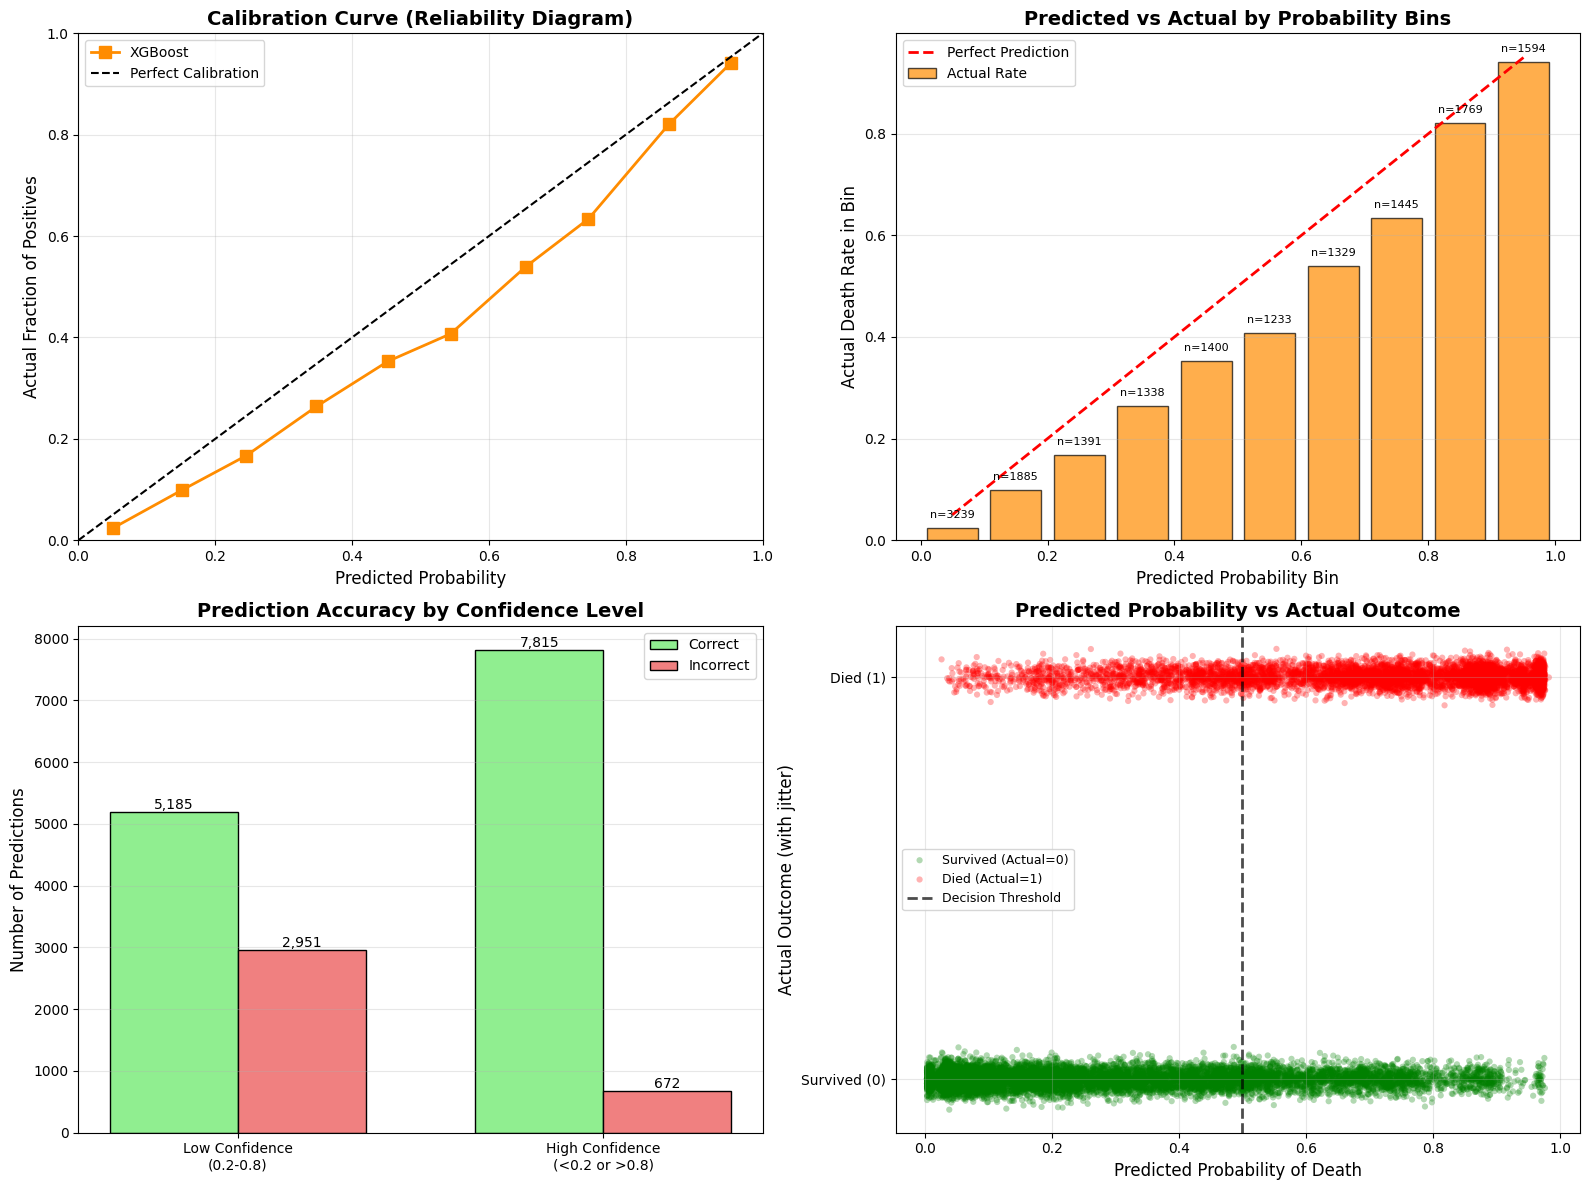

Calibration Metrics:
  Brier Score: 0.1453 (lower is better, 0=perfect)
  Expected Calibration Error: 0.0758

Prediction Confidence Breakdown:
  High Confidence Predictions: 8,487 (51.1%)
    - Correct: 7,815 (92.1%)
    - Incorrect: 672 (7.9%)
  Low Confidence Predictions: 8,136 (48.9%)
    - Correct: 5,185 (63.7%)
    - Incorrect: 2,951 (36.3%)

✓ All XGBoost validation and prediction comparison visualizations complete!


In [ ]:
# ============================================================================
# 15C: XGBOOST - VALIDATION CURVES & PREDICTION ANALYSIS
# ============================================================================

print_section("XGBOOST - VALIDATION CURVES & PREDICTION ANALYSIS")

# ----------------------------------------------------------------------------
# 1. TRAIN-VALIDATION-TEST SPLIT FOR VALIDATION SET ANALYSIS
# ----------------------------------------------------------------------------
print("Creating validation set for performance tracking...\n")

# Split training data into train and validation
X_train_sub_xgb, X_val_xgb, y_train_sub_xgb, y_val_xgb = train_test_split(
    X_train, y_train,
    test_size=0.2,  # 20% of training data for validation
    random_state=TRAINING_SEED,
    stratify=y_train
)

print(f"Dataset Split:")
print(f"  Training:   {X_train_sub_xgb.shape[0]:,} samples ({100*X_train_sub_xgb.shape[0]/len(X_all_clean):.1f}%)")
print(f"  Validation: {X_val_xgb.shape[0]:,} samples ({100*X_val_xgb.shape[0]/len(X_all_clean):.1f}%)")
print(f"  Testing:    {X_test.shape[0]:,} samples ({100*X_test.shape[0]/len(X_all_clean):.1f}%)")

# Train model on training subset with early stopping
xgb_model_val = XGBClassifier(**best_xgb_params, eval_metric='logloss')
xgb_model_val.fit(
    X_train_sub_xgb, y_train_sub_xgb,
    eval_set=[(X_val_xgb, y_val_xgb)],
    verbose=False
)

# Predictions on all three sets
y_pred_proba_train_xgb = xgb_model_val.predict_proba(X_train_sub_xgb)[:, 1]
y_pred_proba_val_xgb = xgb_model_val.predict_proba(X_val_xgb)[:, 1]
y_pred_proba_test_val_xgb = xgb_model_val.predict_proba(X_test)[:, 1]

# Calculate metrics for all sets
train_roc_xgb = roc_auc_score(y_train_sub_xgb, y_pred_proba_train_xgb)
val_roc_xgb = roc_auc_score(y_val_xgb, y_pred_proba_val_xgb)
test_roc_xgb = roc_auc_score(y_test, y_pred_proba_test_val_xgb)

train_f1_xgb = f1_score(y_train_sub_xgb, (y_pred_proba_train_xgb >= 0.5).astype(int))
val_f1_xgb = f1_score(y_val_xgb, (y_pred_proba_val_xgb >= 0.5).astype(int))
test_f1_xgb = f1_score(y_test, (y_pred_proba_test_val_xgb >= 0.5).astype(int))

print(f"\nPerformance Across Sets:")
print(f"  Train      - ROC-AUC: {train_roc_xgb:.4f}, F1: {train_f1_xgb:.4f}")
print(f"  Validation - ROC-AUC: {val_roc_xgb:.4f}, F1: {val_f1_xgb:.4f}")
print(f"  Test       - ROC-AUC: {test_roc_xgb:.4f}, F1: {test_f1_xgb:.4f}")

# Visualization: Performance across datasets
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart comparison
datasets = ['Training', 'Validation', 'Test']
roc_scores_xgb = [train_roc_xgb, val_roc_xgb, test_roc_xgb]
f1_scores_xgb = [train_f1_xgb, val_f1_xgb, test_f1_xgb]

x = np.arange(len(datasets))
width = 0.35

bars1 = axes[0].bar(x - width/2, roc_scores_xgb, width, label='ROC-AUC', color='darkorange', edgecolor='black')
bars2 = axes[0].bar(x + width/2, f1_scores_xgb, width, label='F1-Score', color='lightcoral', edgecolor='black')

axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('XGBoost Performance: Training vs Validation vs Test', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(datasets)
axes[0].legend(fontsize=11)
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0.5, 1.0])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# ROC curves for all three sets
fpr_train_xgb, tpr_train_xgb, _ = roc_curve(y_train_sub_xgb, y_pred_proba_train_xgb)
fpr_val_xgb, tpr_val_xgb, _ = roc_curve(y_val_xgb, y_pred_proba_val_xgb)
fpr_test_xgb, tpr_test_xgb, _ = roc_curve(y_test, y_pred_proba_test_val_xgb)

axes[1].plot(fpr_train_xgb, tpr_train_xgb, linewidth=2, label=f'Training (AUC={train_roc_xgb:.4f})', color='blue')
axes[1].plot(fpr_val_xgb, tpr_val_xgb, linewidth=2, label=f'Validation (AUC={val_roc_xgb:.4f})', color='orange')
axes[1].plot(fpr_test_xgb, tpr_test_xgb, linewidth=2, label=f'Test (AUC={test_roc_xgb:.4f})', color='green')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('ROC Curves: Train vs Val vs Test', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right', fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Check for overfitting
if train_roc_xgb - test_roc_xgb > 0.05:
    print(f"\n⚠️  Warning: Possible overfitting detected (train-test gap: {train_roc_xgb - test_roc_xgb:.4f})")
elif train_roc_xgb - test_roc_xgb < 0.01:
    print(f"\n✓ Excellent generalization (train-test gap: {train_roc_xgb - test_roc_xgb:.4f})")
else:
    print(f"\n✓ Acceptable generalization (train-test gap: {train_roc_xgb - test_roc_xgb:.4f})")

print()

# ----------------------------------------------------------------------------
# 2. VALIDATION CURVES - HYPERPARAMETER SENSITIVITY ANALYSIS
# ----------------------------------------------------------------------------
print("Generating validation curves for key hyperparameters...\n")

from sklearn.model_selection import validation_curve

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

# Hyperparameters to test
param_configs_xgb = [
    {
        'param_name': 'max_depth',
        'param_range': [3, 5, 7, 9, 11, 13, 15],
        'title': 'Validation Curve: max_depth',
        'xlabel': 'Maximum Tree Depth'
    },
    {
        'param_name': 'n_estimators',
        'param_range': [50, 100, 150, 200, 300, 400, 500],
        'title': 'Validation Curve: n_estimators',
        'xlabel': 'Number of Trees'
    },
    {
        'param_name': 'learning_rate',
        'param_range': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3],
        'title': 'Validation Curve: learning_rate',
        'xlabel': 'Learning Rate'
    },
    {
        'param_name': 'min_child_weight',
        'param_range': [1, 2, 3, 5, 7, 10],
        'title': 'Validation Curve: min_child_weight',
        'xlabel': 'Min Child Weight'
    },
    {
        'param_name': 'subsample',
        'param_range': [0.6, 0.7, 0.8, 0.9, 1.0],
        'title': 'Validation Curve: subsample',
        'xlabel': 'Subsample Ratio'
    },
    {
        'param_name': 'gamma',
        'param_range': [0, 0.5, 1, 2, 3, 5],
        'title': 'Validation Curve: gamma',
        'xlabel': 'Gamma (Min Split Loss)'
    }
]

for idx, config in enumerate(param_configs_xgb):
    print(f"  Computing validation curve for {config['param_name']}...")

    # Use a subset for faster computation
    sample_size = min(10000, len(X_train_sub_xgb))
    X_sample = X_train_sub_xgb.iloc[:sample_size] if hasattr(X_train_sub_xgb, 'iloc') else X_train_sub_xgb[:sample_size]
    y_sample = y_train_sub_xgb[:sample_size]

    # Get base parameters and update for this test
    base_params_xgb = best_xgb_params.copy()
    base_params_xgb.pop(config['param_name'], None)  # Remove the parameter being tested

    train_scores_xgb, val_scores_xgb = validation_curve(
        XGBClassifier(**base_params_xgb, eval_metric='logloss'),
        X_sample, y_sample,
        param_name=config['param_name'],
        param_range=config['param_range'],
        cv=3,  # 3-fold for speed
        scoring='roc_auc',
        n_jobs=-1
    )

    train_mean_xgb = train_scores_xgb.mean(axis=1)
    train_std_xgb = train_scores_xgb.std(axis=1)
    val_mean_xgb = val_scores_xgb.mean(axis=1)
    val_std_xgb = val_scores_xgb.std(axis=1)

    # Plot
    axes[idx].plot(config['param_range'], train_mean_xgb, 'o-', color='blue',
                   label='Training score', linewidth=2, markersize=8)
    axes[idx].fill_between(config['param_range'],
                           train_mean_xgb - train_std_xgb, train_mean_xgb + train_std_xgb,
                           alpha=0.2, color='blue')

    axes[idx].plot(config['param_range'], val_mean_xgb, 'o-', color='orange',
                   label='Validation score', linewidth=2, markersize=8)
    axes[idx].fill_between(config['param_range'],
                           val_mean_xgb - val_std_xgb, val_mean_xgb + val_std_xgb,
                           alpha=0.2, color='orange')

    # Mark optimal value from hyperparameter tuning
    if config['param_name'] in best_xgb_params:
        optimal_val = best_xgb_params[config['param_name']]
        axes[idx].axvline(x=optimal_val, color='red', linestyle='--', linewidth=2,
                         label=f'Optimized: {optimal_val}')

    axes[idx].set_xlabel(config['xlabel'], fontsize=11)
    axes[idx].set_ylabel('ROC-AUC Score', fontsize=11)
    axes[idx].set_title(config['title'], fontsize=13, fontweight='bold')
    axes[idx].legend(loc='best', fontsize=9)
    axes[idx].grid(alpha=0.3)
    axes[idx].set_ylim([0.5, 1.0])

plt.tight_layout()
plt.show()

print("\n✓ Validation curves show how performance varies with each hyperparameter")
print("✓ Gap between training and validation indicates overfitting tendency\n")

# ----------------------------------------------------------------------------
# 3. PREDICTED VS ACTUAL COMPARISON - CALIBRATION & RELIABILITY
# ----------------------------------------------------------------------------
print("Generating Predicted vs Actual comparison analysis...\n")

from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 3A. Calibration Curve (Reliability Diagram)
prob_true_xgb, prob_pred_xgb = calibration_curve(y_test, y_pred_proba_xgb, n_bins=10, strategy='uniform')

axes[0, 0].plot(prob_pred_xgb, prob_true_xgb, 's-', linewidth=2, markersize=8,
                label='XGBoost', color='darkorange')
axes[0, 0].plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
axes[0, 0].set_xlabel('Predicted Probability', fontsize=12)
axes[0, 0].set_ylabel('Actual Fraction of Positives', fontsize=12)
axes[0, 0].set_title('Calibration Curve (Reliability Diagram)', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_xlim([0, 1])
axes[0, 0].set_ylim([0, 1])

# 3B. Predicted Probability vs Actual Outcome (Binned)
bins = np.linspace(0, 1, 11)
bin_centers = (bins[:-1] + bins[1:]) / 2
actual_by_bin_xgb = []
counts_by_bin_xgb = []

for i in range(len(bins)-1):
    mask = (y_pred_proba_xgb >= bins[i]) & (y_pred_proba_xgb < bins[i+1])
    if mask.sum() > 0:
        actual_by_bin_xgb.append(y_test[mask].mean())
        counts_by_bin_xgb.append(mask.sum())
    else:
        actual_by_bin_xgb.append(0)
        counts_by_bin_xgb.append(0)

axes[0, 1].bar(bin_centers, actual_by_bin_xgb, width=0.08, alpha=0.7,
               color='darkorange', edgecolor='black', label='Actual Rate')
axes[0, 1].plot(bin_centers, bin_centers, 'r--', linewidth=2, label='Perfect Prediction')
axes[0, 1].set_xlabel('Predicted Probability Bin', fontsize=12)
axes[0, 1].set_ylabel('Actual Death Rate in Bin', fontsize=12)
axes[0, 1].set_title('Predicted vs Actual by Probability Bins', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(alpha=0.3, axis='y')

# Add count labels
for i, (center, count) in enumerate(zip(bin_centers, counts_by_bin_xgb)):
    if count > 0:
        axes[0, 1].text(center, actual_by_bin_xgb[i] + 0.02, f'n={count}',
                       ha='center', fontsize=8, rotation=0)

# 3C. Prediction Confidence Analysis
correct_predictions_xgb = (y_pred_xgb == y_test)
confident_correct_xgb = np.abs(y_pred_proba_xgb - 0.5) >= 0.3  # High confidence threshold

confidence_data_xgb = pd.DataFrame({
    'Correct': correct_predictions_xgb,
    'Confident': confident_correct_xgb,
    'Probability': y_pred_proba_xgb
})

# Group by confidence and correctness
low_conf_correct_xgb = ((confidence_data_xgb['Confident'] == False) & (confidence_data_xgb['Correct'] == True)).sum()
low_conf_incorrect_xgb = ((confidence_data_xgb['Confident'] == False) & (confidence_data_xgb['Correct'] == False)).sum()
high_conf_correct_xgb = ((confidence_data_xgb['Confident'] == True) & (confidence_data_xgb['Correct'] == True)).sum()
high_conf_incorrect_xgb = ((confidence_data_xgb['Confident'] == True) & (confidence_data_xgb['Correct'] == False)).sum()

categories = ['Low Confidence\n(0.2-0.8)', 'High Confidence\n(<0.2 or >0.8)']
correct_counts_xgb = [low_conf_correct_xgb, high_conf_correct_xgb]
incorrect_counts_xgb = [low_conf_incorrect_xgb, high_conf_incorrect_xgb]

x = np.arange(len(categories))
width = 0.35

bars1 = axes[1, 0].bar(x - width/2, correct_counts_xgb, width, label='Correct',
                       color='lightgreen', edgecolor='black')
bars2 = axes[1, 0].bar(x + width/2, incorrect_counts_xgb, width, label='Incorrect',
                       color='lightcoral', edgecolor='black')

axes[1, 0].set_ylabel('Number of Predictions', fontsize=12)
axes[1, 0].set_title('Prediction Accuracy by Confidence Level', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(categories)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(axis='y', alpha=0.3)

# Add count labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height):,}', ha='center', va='bottom', fontsize=10)

# 3D. Scatter plot - Predicted Probability vs Actual (with jitter)
np.random.seed(TRAINING_SEED)
jitter = np.random.normal(0, 0.02, size=len(y_test))

axes[1, 1].scatter(y_pred_proba_xgb[y_test == 0], y_test[y_test == 0] + jitter[y_test == 0],
                  alpha=0.3, s=20, c='green', label='Survived (Actual=0)', edgecolors='none')
axes[1, 1].scatter(y_pred_proba_xgb[y_test == 1], y_test[y_test == 1] + jitter[y_test == 1],
                  alpha=0.3, s=20, c='red', label='Died (Actual=1)', edgecolors='none')
axes[1, 1].axvline(x=0.5, color='black', linestyle='--', linewidth=2, alpha=0.7, label='Decision Threshold')
axes[1, 1].set_xlabel('Predicted Probability of Death', fontsize=12)
axes[1, 1].set_ylabel('Actual Outcome (with jitter)', fontsize=12)
axes[1, 1].set_title('Predicted Probability vs Actual Outcome', fontsize=14, fontweight='bold')
axes[1, 1].set_yticks([0, 1])
axes[1, 1].set_yticklabels(['Survived (0)', 'Died (1)'])
axes[1, 1].legend(fontsize=9, loc='center left')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print calibration statistics
brier_score_xgb = brier_score_loss(y_test, y_pred_proba_xgb)
print(f"Calibration Metrics:")
print(f"  Brier Score: {brier_score_xgb:.4f} (lower is better, 0=perfect)")
print(f"  Expected Calibration Error: {np.abs(prob_true_xgb - prob_pred_xgb).mean():.4f}")
print(f"\nPrediction Confidence Breakdown:")
print(f"  High Confidence Predictions: {high_conf_correct_xgb + high_conf_incorrect_xgb:,} ({100*(high_conf_correct_xgb + high_conf_incorrect_xgb)/len(y_test):.1f}%)")
print(f"    - Correct: {high_conf_correct_xgb:,} ({100*high_conf_correct_xgb/(high_conf_correct_xgb + high_conf_incorrect_xgb):.1f}%)")
print(f"    - Incorrect: {high_conf_incorrect_xgb:,} ({100*high_conf_incorrect_xgb/(high_conf_correct_xgb + high_conf_incorrect_xgb):.1f}%)")
print(f"  Low Confidence Predictions: {low_conf_correct_xgb + low_conf_incorrect_xgb:,} ({100*(low_conf_correct_xgb + low_conf_incorrect_xgb)/len(y_test):.1f}%)")
print(f"    - Correct: {low_conf_correct_xgb:,} ({100*low_conf_correct_xgb/(low_conf_correct_xgb + low_conf_incorrect_xgb):.1f}%)")
print(f"    - Incorrect: {low_conf_incorrect_xgb:,} ({100*low_conf_incorrect_xgb/(low_conf_correct_xgb + low_conf_incorrect_xgb):.1f}%)")

print("\n✓ All XGBoost validation and prediction comparison visualizations complete!")

In [ ]:
# ============================================================================
# 16: LIGHTGBM - HYPERPARAMETER TUNING
# ============================================================================

print_section("LIGHTGBM - HYPERPARAMETER TUNING")

print("Starting Optuna optimization with 10 trials...\n")

def objective_lgbm(trial):
    """Objective function for LightGBM hyperparameter optimization"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'class_weight': 'balanced',
        'random_state': TRAINING_SEED,
        'n_jobs': -1,
        'verbose': -1
    }

    # 5-fold stratified cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=TRAINING_SEED)
    model = LGBMClassifier(**params)

    scores = cross_validate(
        model, X_train, y_train, cv=cv,
        scoring='average_precision',
        n_jobs=-1
    )

    return scores['test_score'].mean()

# Create and run Optuna study
study_lgbm = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=TRAINING_SEED)
)

study_lgbm.optimize(objective_lgbm, n_trials=10, show_progress_bar=True)

print(f"\n{'='*80}")
print(f"✓ Optimization Complete")
print(f"✓ Best PR-AUC: {study_lgbm.best_value:.4f}")
print(f"{'='*80}")
print(f"\nBest Hyperparameters:")
for param, value in study_lgbm.best_params.items():
    print(f"  {param:20s}: {value}")

# Store best parameters
best_lgbm_params = study_lgbm.best_params.copy()
best_lgbm_params['class_weight'] = 'balanced'
best_lgbm_params['random_state'] = TRAINING_SEED
best_lgbm_params['n_jobs'] = -1
best_lgbm_params['verbose'] = -1

# Clean up memory
gc.collect()

[I 2025-12-02 14:39:32,322] A new study created in memory with name: no-name-399977b3-dbab-4d52-9a16-a4901386d9f6



LIGHTGBM - HYPERPARAMETER TUNING

Starting Optuna optimization with 10 trials...



  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-02 14:40:27,247] Trial 0 finished with value: 0.8085217741022996 and parameters: {'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.07475612091546033, 'num_leaves': 132, 'min_child_samples': 25, 'subsample': 0.921421389969683, 'colsample_bytree': 0.9367135914627014, 'reg_alpha': 1.9890034765363473, 'reg_lambda': 0.4089165621897928}. Best is trial 0 with value: 0.8085217741022996.
[I 2025-12-02 14:41:48,533] Trial 1 finished with value: 0.8101784029652679 and parameters: {'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.01036044506013514, 'num_leaves': 131, 'min_child_samples': 10, 'subsample': 0.6654206144251413, 'colsample_bytree': 0.6495655749261368, 'reg_alpha': 0.2993634036506554, 'reg_lambda': 0.24455431650573511}. Best is trial 1 with value: 0.8101784029652679.
[I 2025-12-02 14:42:04,998] Trial 2 finished with value: 0.8097901107577201 and parameters: {'n_estimators': 100, 'max_depth': 14, 'learning_rate': 0.07888912522502249, 'num_leaves': 45, 'min_child

28681

In [ ]:
# ============================================================================
# 17: LIGHTGBM - MODEL TRAINING & EVALUATION
# ============================================================================

print_section("LIGHTGBM - MODEL TRAINING")

print("Training LightGBM with optimized hyperparameters...\n")

# Train final model
lgbm_model = LGBMClassifier(**best_lgbm_params)
lgbm_model.fit(X_train, y_train)

# Make predictions
y_pred_lgbm = lgbm_model.predict(X_test)
y_pred_proba_lgbm = lgbm_model.predict_proba(X_test)[:, 1]

# Evaluate model
lgbm_metrics = evaluate_model(y_test, y_pred_lgbm, y_pred_proba_lgbm)

print("✓ Training Complete\n")
print(f"{'='*80}")
print("LIGHTGBM PERFORMANCE")
print(f"{'='*80}")
print(f"ROC-AUC:    {lgbm_metrics['ROC-AUC']:.4f}")
print(f"F1-Score:   {lgbm_metrics['F1-Score']:.4f}")
print(f"Accuracy:   {lgbm_metrics['Accuracy']:.4f}")
print(f"Precision:  {lgbm_metrics['Precision']:.4f}")
print(f"Recall:     {lgbm_metrics['Recall']:.4f}")
print(f"\nConfusion Matrix:")
print(f"  TN: {lgbm_metrics['TN']:,} | FP: {lgbm_metrics['FP']:,}")
print(f"  FN: {lgbm_metrics['FN']:,} | TP: {lgbm_metrics['TP']:,}")
print(f"{'='*80}")


LIGHTGBM - MODEL TRAINING

Training LightGBM with optimized hyperparameters...

✓ Training Complete

LIGHTGBM PERFORMANCE
ROC-AUC:    0.8738
F1-Score:   0.7386
Accuracy:   0.7829
Precision:  0.6911
Recall:     0.7933

Confusion Matrix:
  TN: 7,914 | FP: 2,280
  FN: 1,329 | TP: 5,100



LIGHTGBM - DETAILED VISUALIZATION & ANALYSIS

Generating feature importance analysis...



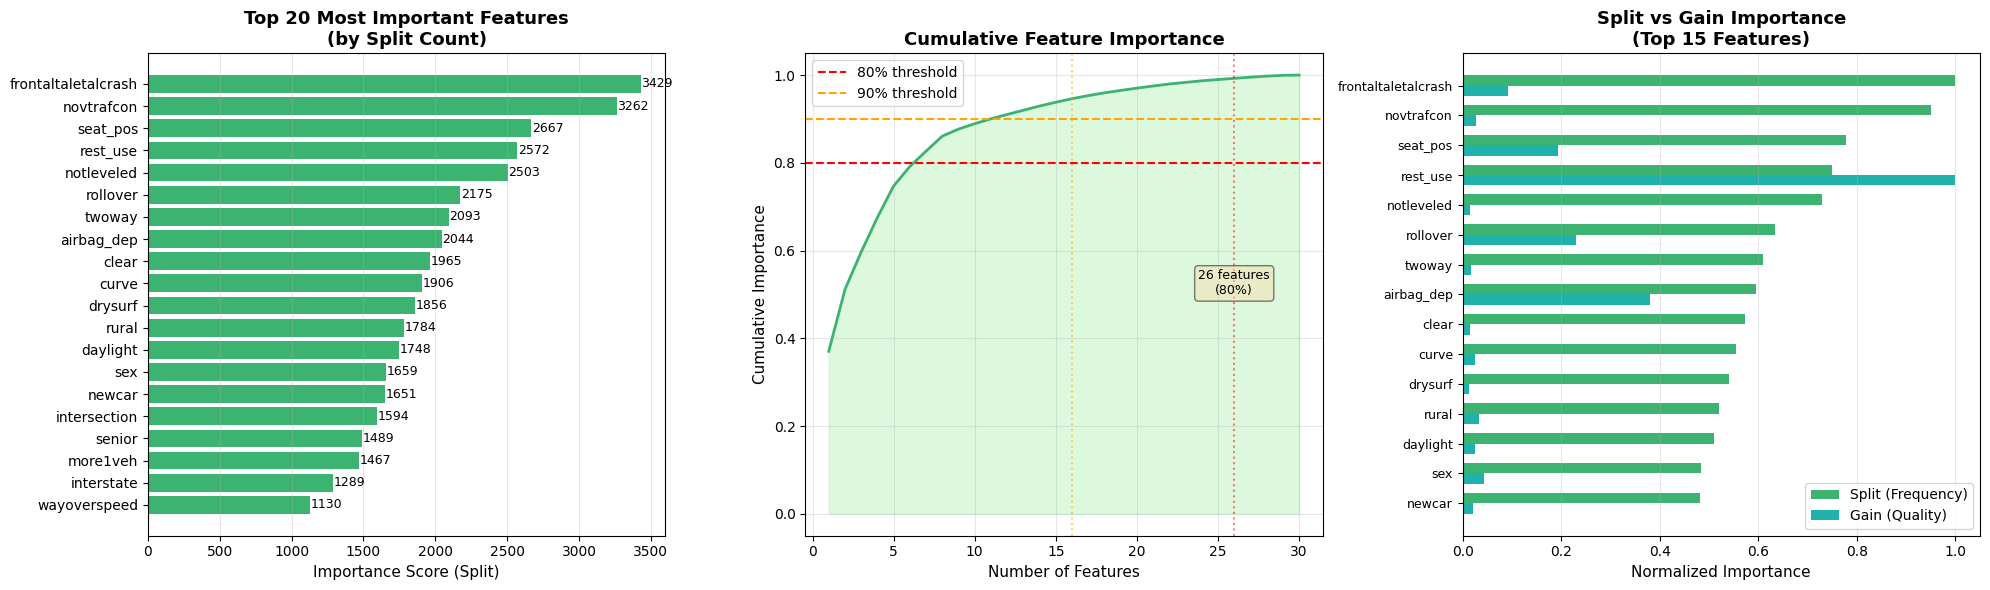

✓ Top 5 features (by gain): rest_use, airbag_dep, rollover, senior, seat_pos
✓ Features needed for 80% importance: 26/30
✓ Features needed for 90% importance: 16/30

Generating ROC and Precision-Recall curves...



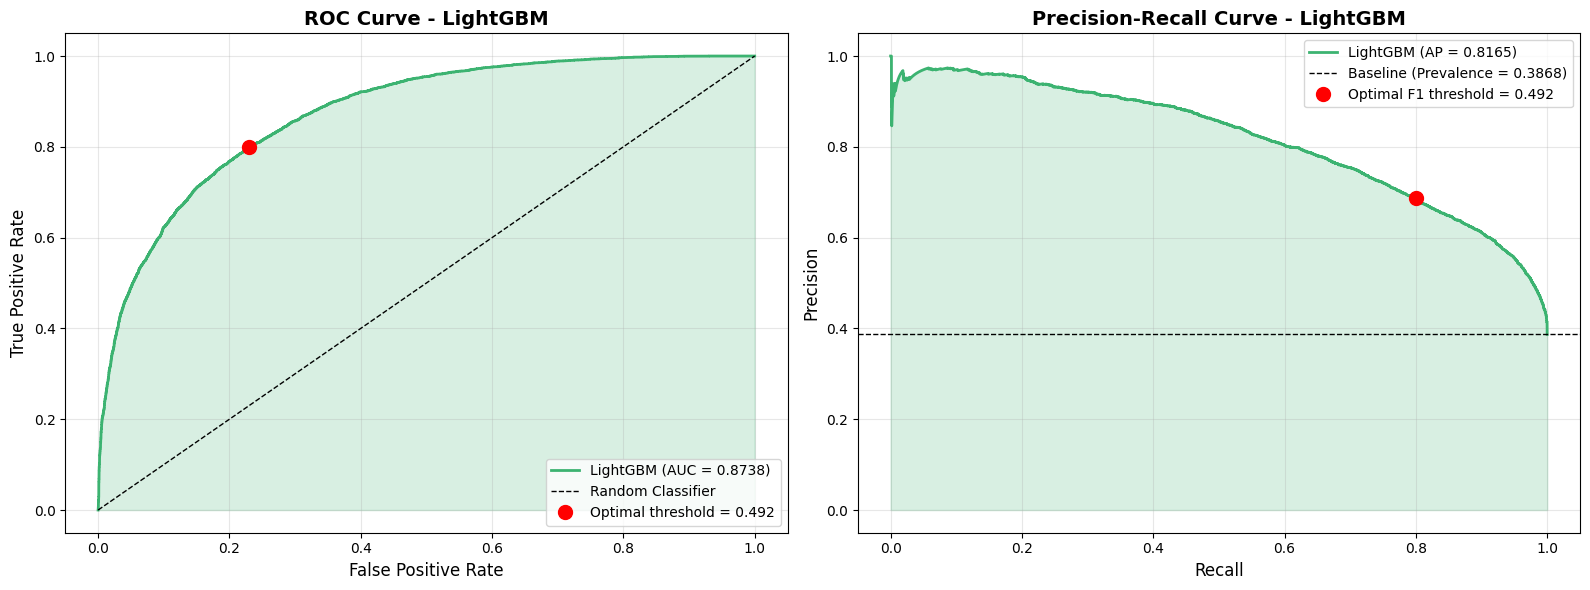

✓ ROC-AUC: 0.8738
✓ Precision-Recall AUC: 0.8165
✓ Optimal ROC threshold: 0.4924 (maximizes TPR-FPR)
✓ Optimal F1 threshold: 0.4924 (maximizes F1-Score)

Generating detailed confusion matrix...



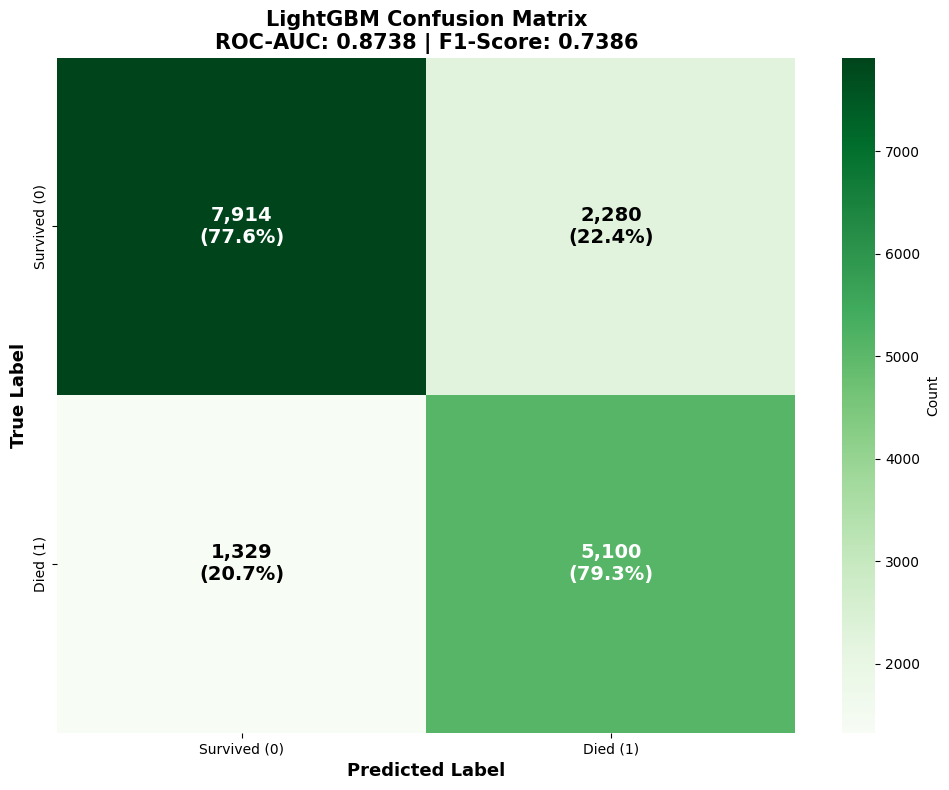

Confusion Matrix Breakdown:
  True Negatives (TN):  7,914 - Correctly predicted survivors
  False Positives (FP): 2,280 - Survivors incorrectly predicted as died
  False Negatives (FN): 1,329 - Deaths incorrectly predicted as survived
  True Positives (TP):  5,100 - Correctly predicted deaths

Additional Metrics:
  Sensitivity (Recall): 0.7933 - % of actual deaths correctly identified
  Specificity:          0.7763 - % of actual survivors correctly identified
  PPV (Precision):      0.6911 - % of predicted deaths that actually died
  NPV:                  0.8562 - % of predicted survivors that actually survived

Analyzing prediction probability distributions...



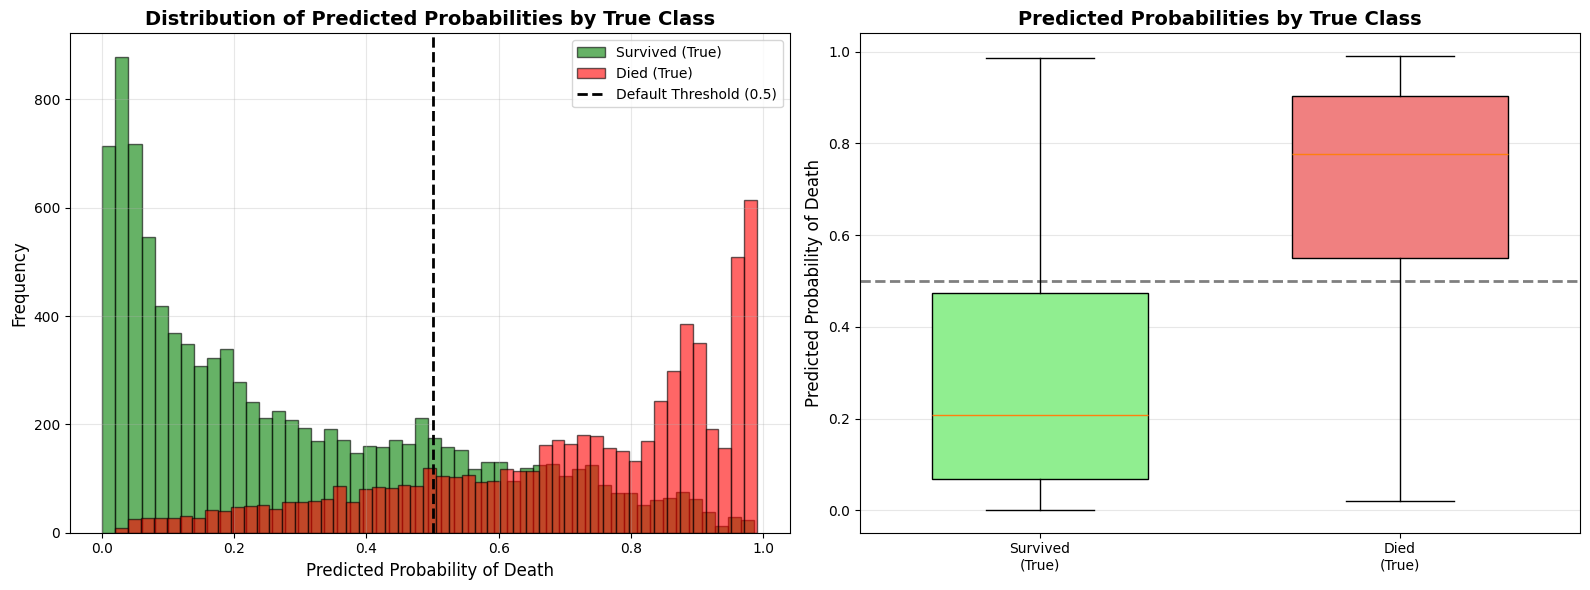

Probability Distribution Statistics:
  Survived (True) - Mean: 0.2888, Std: 0.2536
  Died (True)     - Mean: 0.7110, Std: 0.2414
  Separation:       0.4222

✓ Good separation indicates model can distinguish between classes

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Survived     0.8562    0.7763    0.8143     10194
        Died     0.6911    0.7933    0.7386      6429

    accuracy                         0.7829     16623
   macro avg     0.7736    0.7848    0.7765     16623
weighted avg     0.7923    0.7829    0.7851     16623


LIGHTGBM MODEL SUMMARY
               Metric  Value
              ROC-AUC 0.8738
               PR-AUC 0.8165
             F1-Score 0.7386
             Accuracy 0.7829
            Precision 0.6911
               Recall 0.7933
          Specificity 0.7763
                  PPV 0.6911
                  NPV 0.8562
Optimal ROC Threshold 0.4924
 Optimal F1 Threshold 0.4924

✓ LightGBM detailed analysis complete!


In [ ]:
# ============================================================================
# 17B: LIGHTGBM - DETAILED VISUALIZATION & ANALYSIS
# ============================================================================

print_section("LIGHTGBM - DETAILED VISUALIZATION & ANALYSIS")

# ----------------------------------------------------------------------------
# 1. FEATURE IMPORTANCE ANALYSIS
# ----------------------------------------------------------------------------
print("Generating feature importance analysis...\n")

# Get feature importances (LightGBM has multiple importance types)
feature_importance_split = pd.DataFrame({
    'feature': X_train.columns,
    'importance_split': lgbm_model.feature_importances_  # Default is 'split'
}).sort_values('importance_split', ascending=False)

# Also get 'gain' importance
importance_gain_lgbm = lgbm_model.booster_.feature_importance(importance_type='gain')
feature_importance_gain_lgbm = pd.DataFrame({
    'feature': X_train.columns,
    'importance_gain': importance_gain_lgbm
}).sort_values('importance_gain', ascending=False)

# Merge both importance types
feature_importance_lgbm = feature_importance_split.merge(
    feature_importance_gain_lgbm, on='feature', how='left'
).fillna(0)

# Plot top 20 features
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Bar plot - Top 20 by split
top_20_lgbm = feature_importance_lgbm.head(20)
axes[0].barh(range(len(top_20_lgbm)), top_20_lgbm['importance_split'].values, color='mediumseagreen')
axes[0].set_yticks(range(len(top_20_lgbm)))
axes[0].set_yticklabels(top_20_lgbm['feature'].values)
axes[0].invert_yaxis()
axes[0].set_xlabel('Importance Score (Split)', fontsize=11)
axes[0].set_title('Top 20 Most Important Features\n(by Split Count)', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(top_20_lgbm.iterrows()):
    axes[0].text(row['importance_split'] + 5, i, f"{row['importance_split']:.0f}",
                va='center', fontsize=9)

# Cumulative importance
feature_importance_sorted_lgbm = feature_importance_lgbm.sort_values('importance_gain', ascending=False)
cumsum_lgbm = feature_importance_sorted_lgbm['importance_gain'].cumsum() / feature_importance_sorted_lgbm['importance_gain'].sum()
axes[1].plot(range(1, len(cumsum_lgbm)+1), cumsum_lgbm, linewidth=2, color='mediumseagreen')
axes[1].axhline(y=0.8, color='red', linestyle='--', label='80% threshold')
axes[1].axhline(y=0.9, color='orange', linestyle='--', label='90% threshold')
axes[1].fill_between(range(1, len(cumsum_lgbm)+1), cumsum_lgbm, alpha=0.3, color='lightgreen')
axes[1].set_xlabel('Number of Features', fontsize=11)
axes[1].set_ylabel('Cumulative Importance', fontsize=11)
axes[1].set_title('Cumulative Feature Importance', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Find features needed for 80% and 90%
n_80_lgbm = (cumsum_lgbm >= 0.8).idxmax() + 1
n_90_lgbm = (cumsum_lgbm >= 0.9).idxmax() + 1
axes[1].axvline(x=n_80_lgbm, color='red', linestyle=':', alpha=0.5)
axes[1].axvline(x=n_90_lgbm, color='orange', linestyle=':', alpha=0.5)
axes[1].text(n_80_lgbm, 0.5, f'{n_80_lgbm} features\n(80%)', ha='center', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Compare Split vs Gain importance for top 15
top_15_features_lgbm = feature_importance_lgbm.head(15)
x_pos = np.arange(len(top_15_features_lgbm))
width = 0.35

# Normalize for comparison
split_norm = top_15_features_lgbm['importance_split'] / top_15_features_lgbm['importance_split'].max()
gain_norm_lgbm = top_15_features_lgbm['importance_gain'] / top_15_features_lgbm['importance_gain'].max()

axes[2].barh(x_pos - width/2, split_norm, width, label='Split (Frequency)', color='mediumseagreen')
axes[2].barh(x_pos + width/2, gain_norm_lgbm, width, label='Gain (Quality)', color='lightseagreen')
axes[2].set_yticks(x_pos)
axes[2].set_yticklabels(top_15_features_lgbm['feature'].values, fontsize=9)
axes[2].invert_yaxis()
axes[2].set_xlabel('Normalized Importance', fontsize=11)
axes[2].set_title('Split vs Gain Importance\n(Top 15 Features)', fontsize=13, fontweight='bold')
axes[2].legend()
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ Top 5 features (by gain): {', '.join(feature_importance_sorted_lgbm.head(5)['feature'].values)}")
print(f"✓ Features needed for 80% importance: {n_80_lgbm}/{len(feature_importance_lgbm)}")
print(f"✓ Features needed for 90% importance: {n_90_lgbm}/{len(feature_importance_lgbm)}\n")

# ----------------------------------------------------------------------------
# 2. ROC CURVE & PRECISION-RECALL CURVE
# ----------------------------------------------------------------------------
print("Generating ROC and Precision-Recall curves...\n")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
fpr_lgbm, tpr_lgbm, thresholds_roc_lgbm = roc_curve(y_test, y_pred_proba_lgbm)
roc_auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)

axes[0].plot(fpr_lgbm, tpr_lgbm, linewidth=2, label=f'LightGBM (AUC = {roc_auc_lgbm:.4f})', color='mediumseagreen')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[0].fill_between(fpr_lgbm, tpr_lgbm, alpha=0.2, color='mediumseagreen')
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve - LightGBM', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(alpha=0.3)

# Add optimal threshold point
optimal_idx_lgbm = np.argmax(tpr_lgbm - fpr_lgbm)
optimal_threshold_lgbm = thresholds_roc_lgbm[optimal_idx_lgbm]
axes[0].plot(fpr_lgbm[optimal_idx_lgbm], tpr_lgbm[optimal_idx_lgbm], 'ro', markersize=10,
            label=f'Optimal threshold = {optimal_threshold_lgbm:.3f}')
axes[0].legend(loc='lower right', fontsize=10)

# Precision-Recall Curve
precision_lgbm, recall_lgbm, thresholds_pr_lgbm = precision_recall_curve(y_test, y_pred_proba_lgbm)
pr_auc_lgbm = average_precision_score(y_test, y_pred_proba_lgbm)

axes[1].plot(recall_lgbm, precision_lgbm, linewidth=2, label=f'LightGBM (AP = {pr_auc_lgbm:.4f})', color='mediumseagreen')
axes[1].axhline(y=y_test.mean(), color='k', linestyle='--', linewidth=1,
                label=f'Baseline (Prevalence = {y_test.mean():.4f})')
axes[1].fill_between(recall_lgbm, precision_lgbm, alpha=0.2, color='mediumseagreen')
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve - LightGBM', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(alpha=0.3)

# Add F1-optimal threshold point
f1_scores_lgbm = 2 * (precision_lgbm[:-1] * recall_lgbm[:-1]) / (precision_lgbm[:-1] + recall_lgbm[:-1] + 1e-10)
optimal_f1_idx_lgbm = np.argmax(f1_scores_lgbm)
axes[1].plot(recall_lgbm[optimal_f1_idx_lgbm], precision_lgbm[optimal_f1_idx_lgbm], 'ro', markersize=10,
            label=f'Optimal F1 threshold = {thresholds_pr_lgbm[optimal_f1_idx_lgbm]:.3f}')
axes[1].legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

print(f"✓ ROC-AUC: {roc_auc_lgbm:.4f}")
print(f"✓ Precision-Recall AUC: {pr_auc_lgbm:.4f}")
print(f"✓ Optimal ROC threshold: {optimal_threshold_lgbm:.4f} (maximizes TPR-FPR)")
print(f"✓ Optimal F1 threshold: {thresholds_pr_lgbm[optimal_f1_idx_lgbm]:.4f} (maximizes F1-Score)\n")

# ----------------------------------------------------------------------------
# 3. CONFUSION MATRIX WITH DETAILED ANNOTATIONS
# ----------------------------------------------------------------------------
print("Generating detailed confusion matrix...\n")

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
cm_normalized_lgbm = cm_lgbm.astype('float') / cm_lgbm.sum(axis=1)[:, np.newaxis]

# Create annotated heatmap
sns.heatmap(cm_lgbm, annot=False, fmt='d', cmap='Greens', ax=ax,
            xticklabels=['Survived (0)', 'Died (1)'],
            yticklabels=['Survived (0)', 'Died (1)'],
            cbar_kws={'label': 'Count'})

# Add detailed annotations
for i in range(2):
    for j in range(2):
        count = cm_lgbm[i, j]
        percentage = cm_normalized_lgbm[i, j] * 100
        text = f'{count:,}\n({percentage:.1f}%)'
        ax.text(j + 0.5, i + 0.5, text, ha='center', va='center',
               fontsize=14, fontweight='bold',
               color='white' if cm_lgbm[i, j] > cm_lgbm.max() / 2 else 'black')

ax.set_ylabel('True Label', fontsize=13, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=13, fontweight='bold')
ax.set_title(f'LightGBM Confusion Matrix\nROC-AUC: {roc_auc_lgbm:.4f} | F1-Score: {lgbm_metrics["F1-Score"]:.4f}',
            fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate additional metrics
tn_lgbm, fp_lgbm, fn_lgbm, tp_lgbm = cm_lgbm.ravel()
specificity_lgbm = tn_lgbm / (tn_lgbm + fp_lgbm)
sensitivity_lgbm = tp_lgbm / (tp_lgbm + fn_lgbm)
ppv_lgbm = tp_lgbm / (tp_lgbm + fp_lgbm)  # Positive Predictive Value
npv_lgbm = tn_lgbm / (tn_lgbm + fn_lgbm)  # Negative Predictive Value

print(f"Confusion Matrix Breakdown:")
print(f"  True Negatives (TN):  {tn_lgbm:,} - Correctly predicted survivors")
print(f"  False Positives (FP): {fp_lgbm:,} - Survivors incorrectly predicted as died")
print(f"  False Negatives (FN): {fn_lgbm:,} - Deaths incorrectly predicted as survived")
print(f"  True Positives (TP):  {tp_lgbm:,} - Correctly predicted deaths")
print(f"\nAdditional Metrics:")
print(f"  Sensitivity (Recall): {sensitivity_lgbm:.4f} - % of actual deaths correctly identified")
print(f"  Specificity:          {specificity_lgbm:.4f} - % of actual survivors correctly identified")
print(f"  PPV (Precision):      {ppv_lgbm:.4f} - % of predicted deaths that actually died")
print(f"  NPV:                  {npv_lgbm:.4f} - % of predicted survivors that actually survived\n")

# ----------------------------------------------------------------------------
# 4. PREDICTION DISTRIBUTION ANALYSIS
# ----------------------------------------------------------------------------
print("Analyzing prediction probability distributions...\n")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribution of predicted probabilities by true class
axes[0].hist(y_pred_proba_lgbm[y_test == 0], bins=50, alpha=0.6, label='Survived (True)',
            color='green', edgecolor='black')
axes[0].hist(y_pred_proba_lgbm[y_test == 1], bins=50, alpha=0.6, label='Died (True)',
            color='red', edgecolor='black')
axes[0].axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Default Threshold (0.5)')
axes[0].set_xlabel('Predicted Probability of Death', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Predicted Probabilities by True Class', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Box plot comparison
data_to_plot_lgbm = [
    y_pred_proba_lgbm[y_test == 0],
    y_pred_proba_lgbm[y_test == 1]
]
bp_lgbm = axes[1].boxplot(data_to_plot_lgbm, labels=['Survived\n(True)', 'Died\n(True)'],
                          patch_artist=True, widths=0.6)
bp_lgbm['boxes'][0].set_facecolor('lightgreen')
bp_lgbm['boxes'][1].set_facecolor('lightcoral')
axes[1].axhline(y=0.5, color='black', linestyle='--', linewidth=2, alpha=0.5)
axes[1].set_ylabel('Predicted Probability of Death', fontsize=12)
axes[1].set_title('Predicted Probabilities by True Class', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate separation metrics
mean_prob_died_lgbm = y_pred_proba_lgbm[y_test == 1].mean()
mean_prob_survived_lgbm = y_pred_proba_lgbm[y_test == 0].mean()
std_prob_died_lgbm = y_pred_proba_lgbm[y_test == 1].std()
std_prob_survived_lgbm = y_pred_proba_lgbm[y_test == 0].std()

print(f"Probability Distribution Statistics:")
print(f"  Survived (True) - Mean: {mean_prob_survived_lgbm:.4f}, Std: {std_prob_survived_lgbm:.4f}")
print(f"  Died (True)     - Mean: {mean_prob_died_lgbm:.4f}, Std: {std_prob_died_lgbm:.4f}")
print(f"  Separation:       {abs(mean_prob_died_lgbm - mean_prob_survived_lgbm):.4f}")
print(f"\n✓ Good separation indicates model can distinguish between classes\n")

# ----------------------------------------------------------------------------
# 5. CLASSIFICATION REPORT
# ----------------------------------------------------------------------------
print("="*80)
print("CLASSIFICATION REPORT")
print("="*80)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_lgbm, target_names=['Survived', 'Died'], digits=4))

# ----------------------------------------------------------------------------
# 6. MODEL SUMMARY TABLE
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("LIGHTGBM MODEL SUMMARY")
print("="*80)

summary_data_lgbm = {
    'Metric': [
        'ROC-AUC', 'PR-AUC', 'F1-Score', 'Accuracy', 'Precision', 'Recall',
        'Specificity', 'PPV', 'NPV', 'Optimal ROC Threshold', 'Optimal F1 Threshold'
    ],
    'Value': [
        f"{roc_auc_lgbm:.4f}",
        f"{pr_auc_lgbm:.4f}",
        f"{lgbm_metrics['F1-Score']:.4f}",
        f"{lgbm_metrics['Accuracy']:.4f}",
        f"{lgbm_metrics['Precision']:.4f}",
        f"{lgbm_metrics['Recall']:.4f}",
        f"{specificity_lgbm:.4f}",
        f"{ppv_lgbm:.4f}",
        f"{npv_lgbm:.4f}",
        f"{optimal_threshold_lgbm:.4f}",
        f"{thresholds_pr_lgbm[optimal_f1_idx_lgbm]:.4f}"
    ]
}

summary_df_lgbm = pd.DataFrame(summary_data_lgbm)
print(summary_df_lgbm.to_string(index=False))
print("="*80)

# Store extended metrics for later comparison
lgbm_metrics_extended = {
    **lgbm_metrics,
    'PR-AUC': pr_auc_lgbm,
    'Specificity': specificity_lgbm,
    'PPV': ppv_lgbm,
    'NPV': npv_lgbm,
    'Optimal_ROC_Threshold': optimal_threshold_lgbm,
    'Optimal_F1_Threshold': thresholds_pr_lgbm[optimal_f1_idx_lgbm]
}

print("\n✓ LightGBM detailed analysis complete!")


LIGHTGBM - VALIDATION CURVES & PREDICTION ANALYSIS

Creating validation set for performance tracking...

Dataset Split:
  Training:   53,190 samples (64.0%)
  Validation: 13,298 samples (16.0%)
  Testing:    16,623 samples (20.0%)

Performance Across Sets:
  Train      - ROC-AUC: 0.8891, F1: 0.7593
  Validation - ROC-AUC: 0.8702, F1: 0.7377
  Test       - ROC-AUC: 0.8730, F1: 0.7366


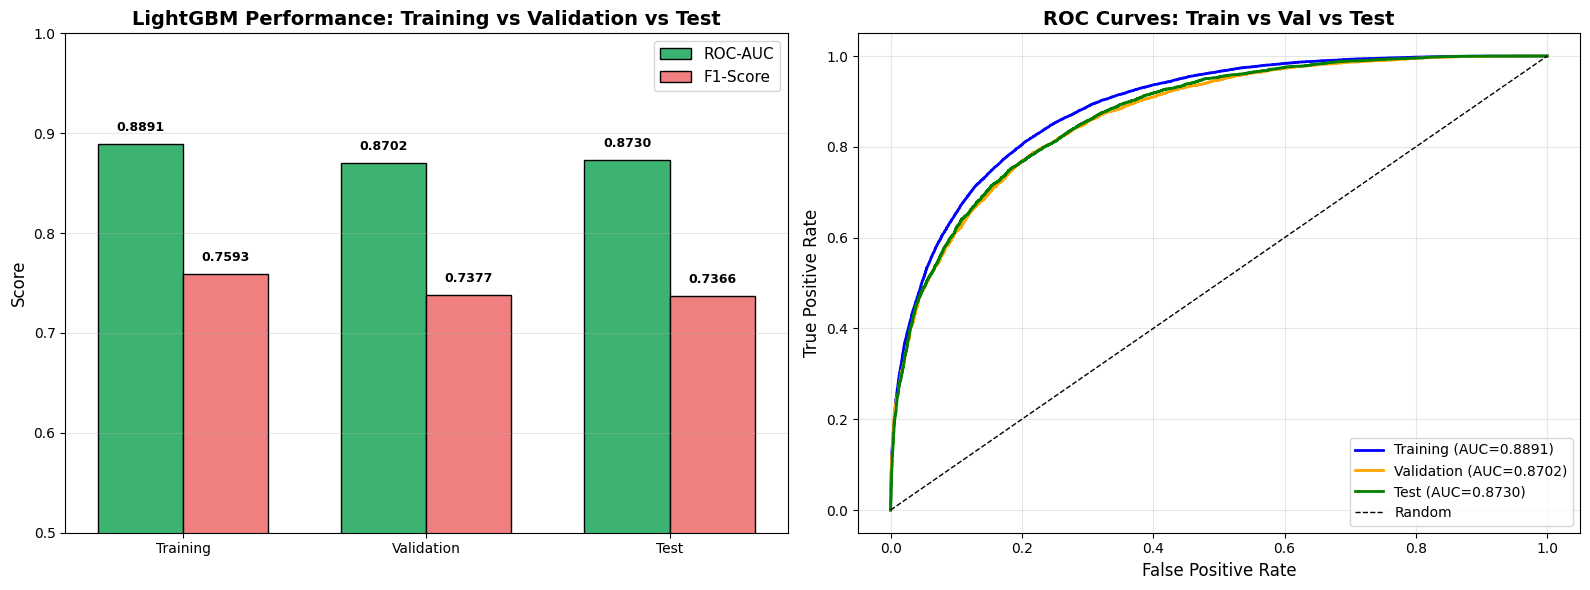


✓ Acceptable generalization (train-test gap: 0.0161)

Generating validation curves for key hyperparameters...

  Computing validation curve for max_depth...
  Computing validation curve for n_estimators...
  Computing validation curve for learning_rate...
  Computing validation curve for num_leaves...
  Computing validation curve for min_child_samples...
  Computing validation curve for subsample...


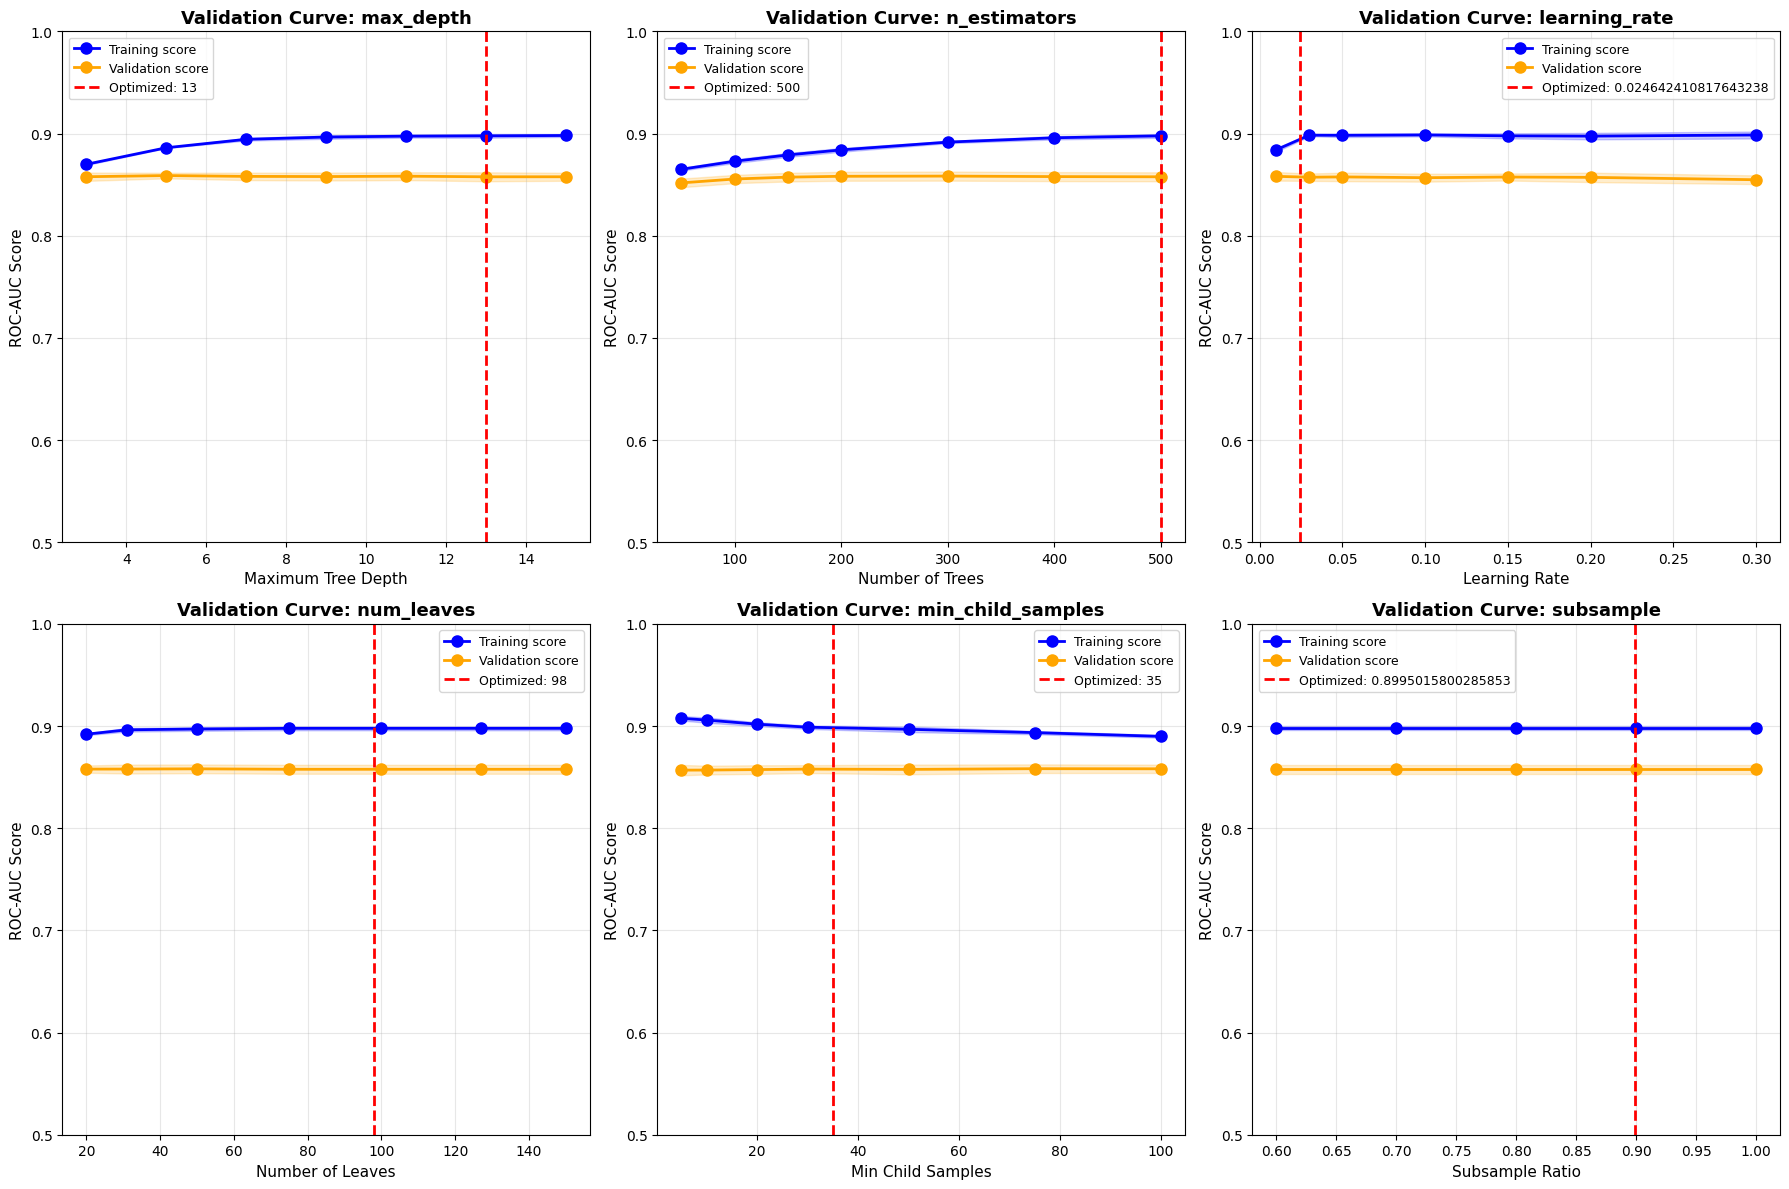


✓ Validation curves show how performance varies with each hyperparameter
✓ Gap between training and validation indicates overfitting tendency

Generating Predicted vs Actual comparison analysis...



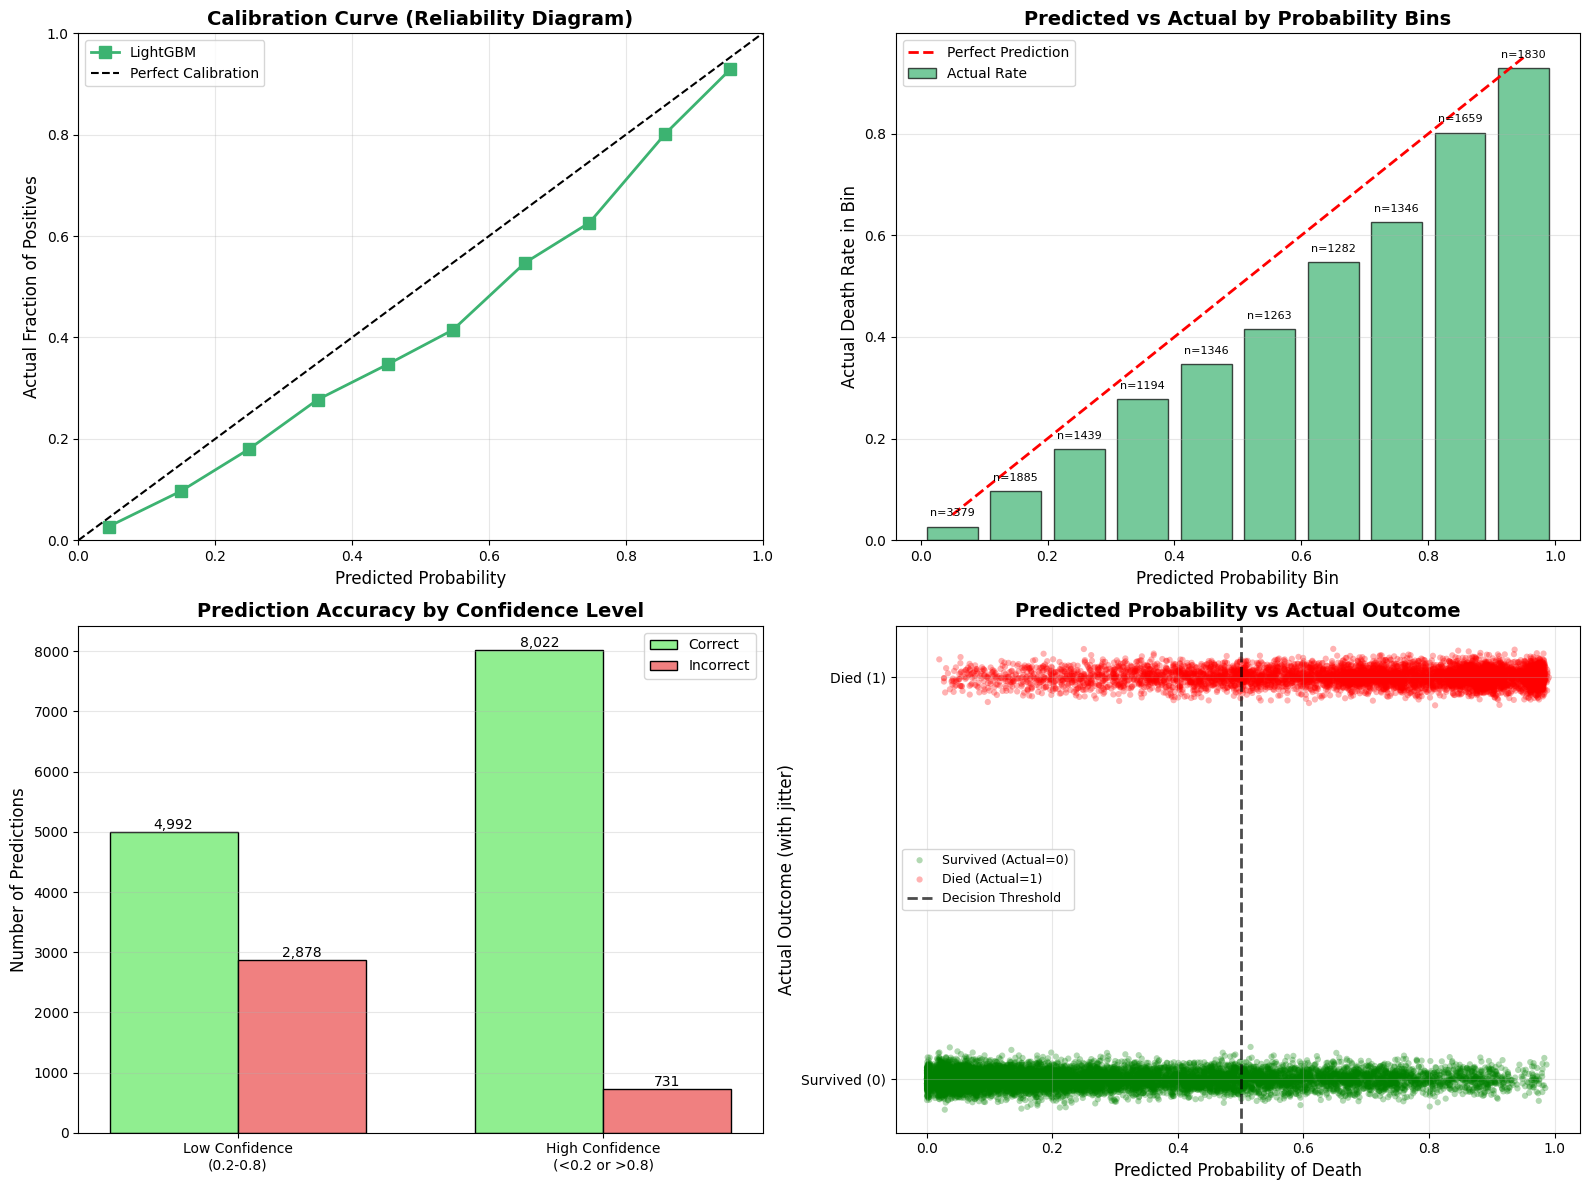

Calibration Metrics:
  Brier Score: 0.1454 (lower is better, 0=perfect)
  Expected Calibration Error: 0.0755

Prediction Confidence Breakdown:
  High Confidence Predictions: 8,753 (52.7%)
    - Correct: 8,022 (91.6%)
    - Incorrect: 731 (8.4%)
  Low Confidence Predictions: 7,870 (47.3%)
    - Correct: 4,992 (63.4%)
    - Incorrect: 2,878 (36.6%)

✓ All LightGBM validation and prediction comparison visualizations complete!


In [ ]:
# ============================================================================
# 17C: LIGHTGBM - VALIDATION CURVES & PREDICTION ANALYSIS
# ============================================================================

print_section("LIGHTGBM - VALIDATION CURVES & PREDICTION ANALYSIS")

# ----------------------------------------------------------------------------
# 1. TRAIN-VALIDATION-TEST SPLIT FOR VALIDATION SET ANALYSIS
# ----------------------------------------------------------------------------
print("Creating validation set for performance tracking...\n")

# Split training data into train and validation
X_train_sub_lgbm, X_val_lgbm, y_train_sub_lgbm, y_val_lgbm = train_test_split(
    X_train, y_train,
    test_size=0.2,  # 20% of training data for validation
    random_state=TRAINING_SEED,
    stratify=y_train
)

print(f"Dataset Split:")
print(f"  Training:   {X_train_sub_lgbm.shape[0]:,} samples ({100*X_train_sub_lgbm.shape[0]/len(X_all_clean):.1f}%)")
print(f"  Validation: {X_val_lgbm.shape[0]:,} samples ({100*X_val_lgbm.shape[0]/len(X_all_clean):.1f}%)")
print(f"  Testing:    {X_test.shape[0]:,} samples ({100*X_test.shape[0]/len(X_all_clean):.1f}%)")

# Train model on training subset
lgbm_model_val = LGBMClassifier(**best_lgbm_params)
lgbm_model_val.fit(X_train_sub_lgbm, y_train_sub_lgbm)

# Predictions on all three sets
y_pred_proba_train_lgbm = lgbm_model_val.predict_proba(X_train_sub_lgbm)[:, 1]
y_pred_proba_val_lgbm = lgbm_model_val.predict_proba(X_val_lgbm)[:, 1]
y_pred_proba_test_val_lgbm = lgbm_model_val.predict_proba(X_test)[:, 1]

# Calculate metrics for all sets
train_roc_lgbm = roc_auc_score(y_train_sub_lgbm, y_pred_proba_train_lgbm)
val_roc_lgbm = roc_auc_score(y_val_lgbm, y_pred_proba_val_lgbm)
test_roc_lgbm = roc_auc_score(y_test, y_pred_proba_test_val_lgbm)

train_f1_lgbm = f1_score(y_train_sub_lgbm, (y_pred_proba_train_lgbm >= 0.5).astype(int))
val_f1_lgbm = f1_score(y_val_lgbm, (y_pred_proba_val_lgbm >= 0.5).astype(int))
test_f1_lgbm = f1_score(y_test, (y_pred_proba_test_val_lgbm >= 0.5).astype(int))

print(f"\nPerformance Across Sets:")
print(f"  Train      - ROC-AUC: {train_roc_lgbm:.4f}, F1: {train_f1_lgbm:.4f}")
print(f"  Validation - ROC-AUC: {val_roc_lgbm:.4f}, F1: {val_f1_lgbm:.4f}")
print(f"  Test       - ROC-AUC: {test_roc_lgbm:.4f}, F1: {test_f1_lgbm:.4f}")

# Visualization: Performance across datasets
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart comparison
datasets = ['Training', 'Validation', 'Test']
roc_scores_lgbm = [train_roc_lgbm, val_roc_lgbm, test_roc_lgbm]
f1_scores_lgbm = [train_f1_lgbm, val_f1_lgbm, test_f1_lgbm]

x = np.arange(len(datasets))
width = 0.35

bars1 = axes[0].bar(x - width/2, roc_scores_lgbm, width, label='ROC-AUC', color='mediumseagreen', edgecolor='black')
bars2 = axes[0].bar(x + width/2, f1_scores_lgbm, width, label='F1-Score', color='lightcoral', edgecolor='black')

axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('LightGBM Performance: Training vs Validation vs Test', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(datasets)
axes[0].legend(fontsize=11)
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0.5, 1.0])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# ROC curves for all three sets
fpr_train_lgbm, tpr_train_lgbm, _ = roc_curve(y_train_sub_lgbm, y_pred_proba_train_lgbm)
fpr_val_lgbm, tpr_val_lgbm, _ = roc_curve(y_val_lgbm, y_pred_proba_val_lgbm)
fpr_test_lgbm, tpr_test_lgbm, _ = roc_curve(y_test, y_pred_proba_test_val_lgbm)

axes[1].plot(fpr_train_lgbm, tpr_train_lgbm, linewidth=2, label=f'Training (AUC={train_roc_lgbm:.4f})', color='blue')
axes[1].plot(fpr_val_lgbm, tpr_val_lgbm, linewidth=2, label=f'Validation (AUC={val_roc_lgbm:.4f})', color='orange')
axes[1].plot(fpr_test_lgbm, tpr_test_lgbm, linewidth=2, label=f'Test (AUC={test_roc_lgbm:.4f})', color='green')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('ROC Curves: Train vs Val vs Test', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right', fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Check for overfitting
if train_roc_lgbm - test_roc_lgbm > 0.05:
    print(f"\n⚠️  Warning: Possible overfitting detected (train-test gap: {train_roc_lgbm - test_roc_lgbm:.4f})")
elif train_roc_lgbm - test_roc_lgbm < 0.01:
    print(f"\n✓ Excellent generalization (train-test gap: {train_roc_lgbm - test_roc_lgbm:.4f})")
else:
    print(f"\n✓ Acceptable generalization (train-test gap: {train_roc_lgbm - test_roc_lgbm:.4f})")

print()

# ----------------------------------------------------------------------------
# 2. VALIDATION CURVES - HYPERPARAMETER SENSITIVITY ANALYSIS
# ----------------------------------------------------------------------------
print("Generating validation curves for key hyperparameters...\n")

from sklearn.model_selection import validation_curve

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

# Hyperparameters to test
param_configs_lgbm = [
    {
        'param_name': 'max_depth',
        'param_range': [3, 5, 7, 9, 11, 13, 15],
        'title': 'Validation Curve: max_depth',
        'xlabel': 'Maximum Tree Depth'
    },
    {
        'param_name': 'n_estimators',
        'param_range': [50, 100, 150, 200, 300, 400, 500],
        'title': 'Validation Curve: n_estimators',
        'xlabel': 'Number of Trees'
    },
    {
        'param_name': 'learning_rate',
        'param_range': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3],
        'title': 'Validation Curve: learning_rate',
        'xlabel': 'Learning Rate'
    },
    {
        'param_name': 'num_leaves',
        'param_range': [20, 31, 50, 75, 100, 127, 150],
        'title': 'Validation Curve: num_leaves',
        'xlabel': 'Number of Leaves'
    },
    {
        'param_name': 'min_child_samples',
        'param_range': [5, 10, 20, 30, 50, 75, 100],
        'title': 'Validation Curve: min_child_samples',
        'xlabel': 'Min Child Samples'
    },
    {
        'param_name': 'subsample',
        'param_range': [0.6, 0.7, 0.8, 0.9, 1.0],
        'title': 'Validation Curve: subsample',
        'xlabel': 'Subsample Ratio'
    }
]

for idx, config in enumerate(param_configs_lgbm):
    print(f"  Computing validation curve for {config['param_name']}...")

    # Use a subset for faster computation
    sample_size = min(10000, len(X_train_sub_lgbm))
    X_sample = X_train_sub_lgbm.iloc[:sample_size] if hasattr(X_train_sub_lgbm, 'iloc') else X_train_sub_lgbm[:sample_size]
    y_sample = y_train_sub_lgbm[:sample_size]

    # Get base parameters and update for this test
    base_params_lgbm = best_lgbm_params.copy()
    base_params_lgbm.pop(config['param_name'], None)  # Remove the parameter being tested

    train_scores_lgbm, val_scores_lgbm = validation_curve(
        LGBMClassifier(**base_params_lgbm),
        X_sample, y_sample,
        param_name=config['param_name'],
        param_range=config['param_range'],
        cv=3,  # 3-fold for speed
        scoring='roc_auc',
        n_jobs=-1
    )

    train_mean_lgbm = train_scores_lgbm.mean(axis=1)
    train_std_lgbm = train_scores_lgbm.std(axis=1)
    val_mean_lgbm = val_scores_lgbm.mean(axis=1)
    val_std_lgbm = val_scores_lgbm.std(axis=1)

    # Plot
    axes[idx].plot(config['param_range'], train_mean_lgbm, 'o-', color='blue',
                   label='Training score', linewidth=2, markersize=8)
    axes[idx].fill_between(config['param_range'],
                           train_mean_lgbm - train_std_lgbm, train_mean_lgbm + train_std_lgbm,
                           alpha=0.2, color='blue')

    axes[idx].plot(config['param_range'], val_mean_lgbm, 'o-', color='orange',
                   label='Validation score', linewidth=2, markersize=8)
    axes[idx].fill_between(config['param_range'],
                           val_mean_lgbm - val_std_lgbm, val_mean_lgbm + val_std_lgbm,
                           alpha=0.2, color='orange')

    # Mark optimal value from hyperparameter tuning
    if config['param_name'] in best_lgbm_params:
        optimal_val = best_lgbm_params[config['param_name']]
        axes[idx].axvline(x=optimal_val, color='red', linestyle='--', linewidth=2,
                         label=f'Optimized: {optimal_val}')

    axes[idx].set_xlabel(config['xlabel'], fontsize=11)
    axes[idx].set_ylabel('ROC-AUC Score', fontsize=11)
    axes[idx].set_title(config['title'], fontsize=13, fontweight='bold')
    axes[idx].legend(loc='best', fontsize=9)
    axes[idx].grid(alpha=0.3)
    axes[idx].set_ylim([0.5, 1.0])

plt.tight_layout()
plt.show()

print("\n✓ Validation curves show how performance varies with each hyperparameter")
print("✓ Gap between training and validation indicates overfitting tendency\n")

# ----------------------------------------------------------------------------
# 3. PREDICTED VS ACTUAL COMPARISON - CALIBRATION & RELIABILITY
# ----------------------------------------------------------------------------
print("Generating Predicted vs Actual comparison analysis...\n")

from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 3A. Calibration Curve (Reliability Diagram)
prob_true_lgbm, prob_pred_lgbm = calibration_curve(y_test, y_pred_proba_lgbm, n_bins=10, strategy='uniform')

axes[0, 0].plot(prob_pred_lgbm, prob_true_lgbm, 's-', linewidth=2, markersize=8,
                label='LightGBM', color='mediumseagreen')
axes[0, 0].plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
axes[0, 0].set_xlabel('Predicted Probability', fontsize=12)
axes[0, 0].set_ylabel('Actual Fraction of Positives', fontsize=12)
axes[0, 0].set_title('Calibration Curve (Reliability Diagram)', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_xlim([0, 1])
axes[0, 0].set_ylim([0, 1])

# 3B. Predicted Probability vs Actual Outcome (Binned)
bins = np.linspace(0, 1, 11)
bin_centers = (bins[:-1] + bins[1:]) / 2
actual_by_bin_lgbm = []
counts_by_bin_lgbm = []

for i in range(len(bins)-1):
    mask = (y_pred_proba_lgbm >= bins[i]) & (y_pred_proba_lgbm < bins[i+1])
    if mask.sum() > 0:
        actual_by_bin_lgbm.append(y_test[mask].mean())
        counts_by_bin_lgbm.append(mask.sum())
    else:
        actual_by_bin_lgbm.append(0)
        counts_by_bin_lgbm.append(0)

axes[0, 1].bar(bin_centers, actual_by_bin_lgbm, width=0.08, alpha=0.7,
               color='mediumseagreen', edgecolor='black', label='Actual Rate')
axes[0, 1].plot(bin_centers, bin_centers, 'r--', linewidth=2, label='Perfect Prediction')
axes[0, 1].set_xlabel('Predicted Probability Bin', fontsize=12)
axes[0, 1].set_ylabel('Actual Death Rate in Bin', fontsize=12)
axes[0, 1].set_title('Predicted vs Actual by Probability Bins', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(alpha=0.3, axis='y')

# Add count labels
for i, (center, count) in enumerate(zip(bin_centers, counts_by_bin_lgbm)):
    if count > 0:
        axes[0, 1].text(center, actual_by_bin_lgbm[i] + 0.02, f'n={count}',
                       ha='center', fontsize=8, rotation=0)

# 3C. Prediction Confidence Analysis
correct_predictions_lgbm = (y_pred_lgbm == y_test)
confident_correct_lgbm = np.abs(y_pred_proba_lgbm - 0.5) >= 0.3  # High confidence threshold

confidence_data_lgbm = pd.DataFrame({
    'Correct': correct_predictions_lgbm,
    'Confident': confident_correct_lgbm,
    'Probability': y_pred_proba_lgbm
})

# Group by confidence and correctness
low_conf_correct_lgbm = ((confidence_data_lgbm['Confident'] == False) & (confidence_data_lgbm['Correct'] == True)).sum()
low_conf_incorrect_lgbm = ((confidence_data_lgbm['Confident'] == False) & (confidence_data_lgbm['Correct'] == False)).sum()
high_conf_correct_lgbm = ((confidence_data_lgbm['Confident'] == True) & (confidence_data_lgbm['Correct'] == True)).sum()
high_conf_incorrect_lgbm = ((confidence_data_lgbm['Confident'] == True) & (confidence_data_lgbm['Correct'] == False)).sum()

categories = ['Low Confidence\n(0.2-0.8)', 'High Confidence\n(<0.2 or >0.8)']
correct_counts_lgbm = [low_conf_correct_lgbm, high_conf_correct_lgbm]
incorrect_counts_lgbm = [low_conf_incorrect_lgbm, high_conf_incorrect_lgbm]

x = np.arange(len(categories))
width = 0.35

bars1 = axes[1, 0].bar(x - width/2, correct_counts_lgbm, width, label='Correct',
                       color='lightgreen', edgecolor='black')
bars2 = axes[1, 0].bar(x + width/2, incorrect_counts_lgbm, width, label='Incorrect',
                       color='lightcoral', edgecolor='black')

axes[1, 0].set_ylabel('Number of Predictions', fontsize=12)
axes[1, 0].set_title('Prediction Accuracy by Confidence Level', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(categories)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(axis='y', alpha=0.3)

# Add count labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height):,}', ha='center', va='bottom', fontsize=10)

# 3D. Scatter plot - Predicted Probability vs Actual (with jitter)
np.random.seed(TRAINING_SEED)
jitter = np.random.normal(0, 0.02, size=len(y_test))

axes[1, 1].scatter(y_pred_proba_lgbm[y_test == 0], y_test[y_test == 0] + jitter[y_test == 0],
                  alpha=0.3, s=20, c='green', label='Survived (Actual=0)', edgecolors='none')
axes[1, 1].scatter(y_pred_proba_lgbm[y_test == 1], y_test[y_test == 1] + jitter[y_test == 1],
                  alpha=0.3, s=20, c='red', label='Died (Actual=1)', edgecolors='none')
axes[1, 1].axvline(x=0.5, color='black', linestyle='--', linewidth=2, alpha=0.7, label='Decision Threshold')
axes[1, 1].set_xlabel('Predicted Probability of Death', fontsize=12)
axes[1, 1].set_ylabel('Actual Outcome (with jitter)', fontsize=12)
axes[1, 1].set_title('Predicted Probability vs Actual Outcome', fontsize=14, fontweight='bold')
axes[1, 1].set_yticks([0, 1])
axes[1, 1].set_yticklabels(['Survived (0)', 'Died (1)'])
axes[1, 1].legend(fontsize=9, loc='center left')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print calibration statistics
brier_score_lgbm = brier_score_loss(y_test, y_pred_proba_lgbm)
print(f"Calibration Metrics:")
print(f"  Brier Score: {brier_score_lgbm:.4f} (lower is better, 0=perfect)")
print(f"  Expected Calibration Error: {np.abs(prob_true_lgbm - prob_pred_lgbm).mean():.4f}")
print(f"\nPrediction Confidence Breakdown:")
print(f"  High Confidence Predictions: {high_conf_correct_lgbm + high_conf_incorrect_lgbm:,} ({100*(high_conf_correct_lgbm + high_conf_incorrect_lgbm)/len(y_test):.1f}%)")
print(f"    - Correct: {high_conf_correct_lgbm:,} ({100*high_conf_correct_lgbm/(high_conf_correct_lgbm + high_conf_incorrect_lgbm):.1f}%)")
print(f"    - Incorrect: {high_conf_incorrect_lgbm:,} ({100*high_conf_incorrect_lgbm/(high_conf_correct_lgbm + high_conf_incorrect_lgbm):.1f}%)")
print(f"  Low Confidence Predictions: {low_conf_correct_lgbm + low_conf_incorrect_lgbm:,} ({100*(low_conf_correct_lgbm + low_conf_incorrect_lgbm)/len(y_test):.1f}%)")
print(f"    - Correct: {low_conf_correct_lgbm:,} ({100*low_conf_correct_lgbm/(low_conf_correct_lgbm + low_conf_incorrect_lgbm):.1f}%)")
print(f"    - Incorrect: {low_conf_incorrect_lgbm:,} ({100*low_conf_incorrect_lgbm/(low_conf_correct_lgbm + low_conf_incorrect_lgbm):.1f}%)")

print("\n✓ All LightGBM validation and prediction comparison visualizations complete!")


COMPREHENSIVE THREE-MODEL COMPARISON

Comparing Random Forest, LightGBM, and XGBoost performance...

Preparing comparison data...

✓ ROC and PR curves calculated for all models

PERFORMANCE METRICS COMPARISON

        Model  ROC-AUC   PR-AUC  F1-Score  Accuracy  Precision   Recall  Specificity      PPV      NPV
Random Forest 0.870535 0.811157  0.735149  0.787042   0.708231 0.764193     0.801452 0.708231 0.843485
     LightGBM 0.873765 0.816489  0.738649  0.782891   0.691057 0.793280     0.776339 0.691057 0.856216
      XGBoost 0.874092 0.817304  0.737445  0.782049   0.690366 0.791414     0.776143 0.690366 0.855074


Best Model by Metric:
  ROC-AUC        : XGBoost         (0.8741)
  PR-AUC         : XGBoost         (0.8173)
  F1-Score       : LightGBM        (0.7386)
  Accuracy       : Random Forest   (0.7870)
  Precision      : Random Forest   (0.7082)
  Recall         : LightGBM        (0.7933)
  Specificity    : Random Forest   (0.8015)
  PPV            : Random Forest   (0.7082)
 

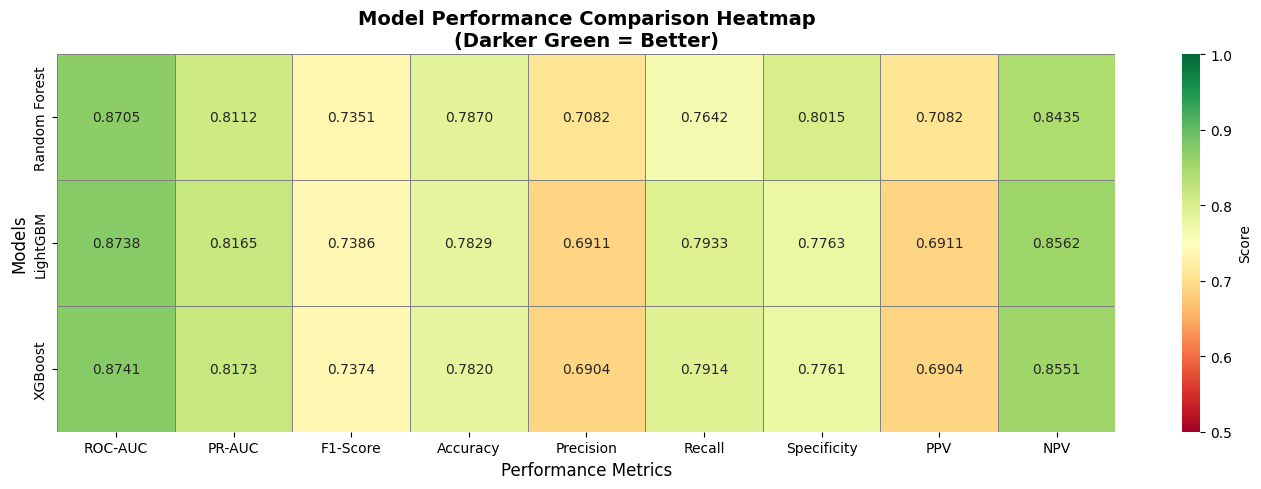

Generating side-by-side metric comparisons...



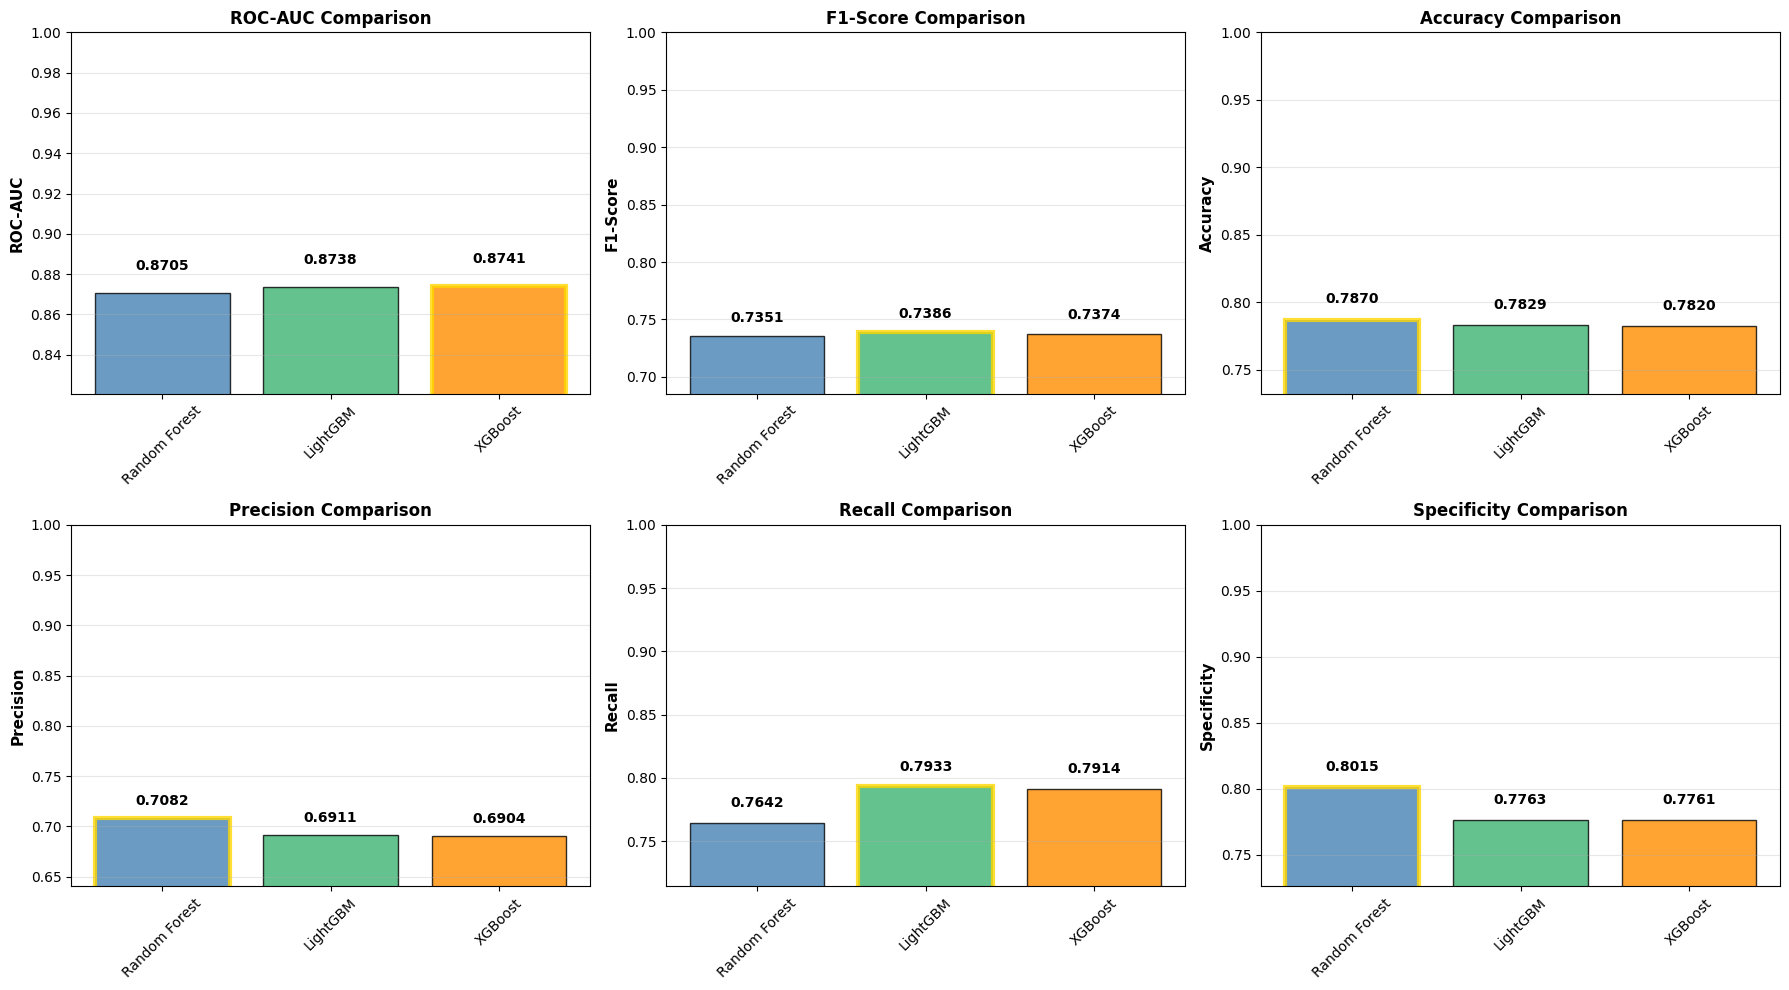

Generating combined ROC curve comparison...



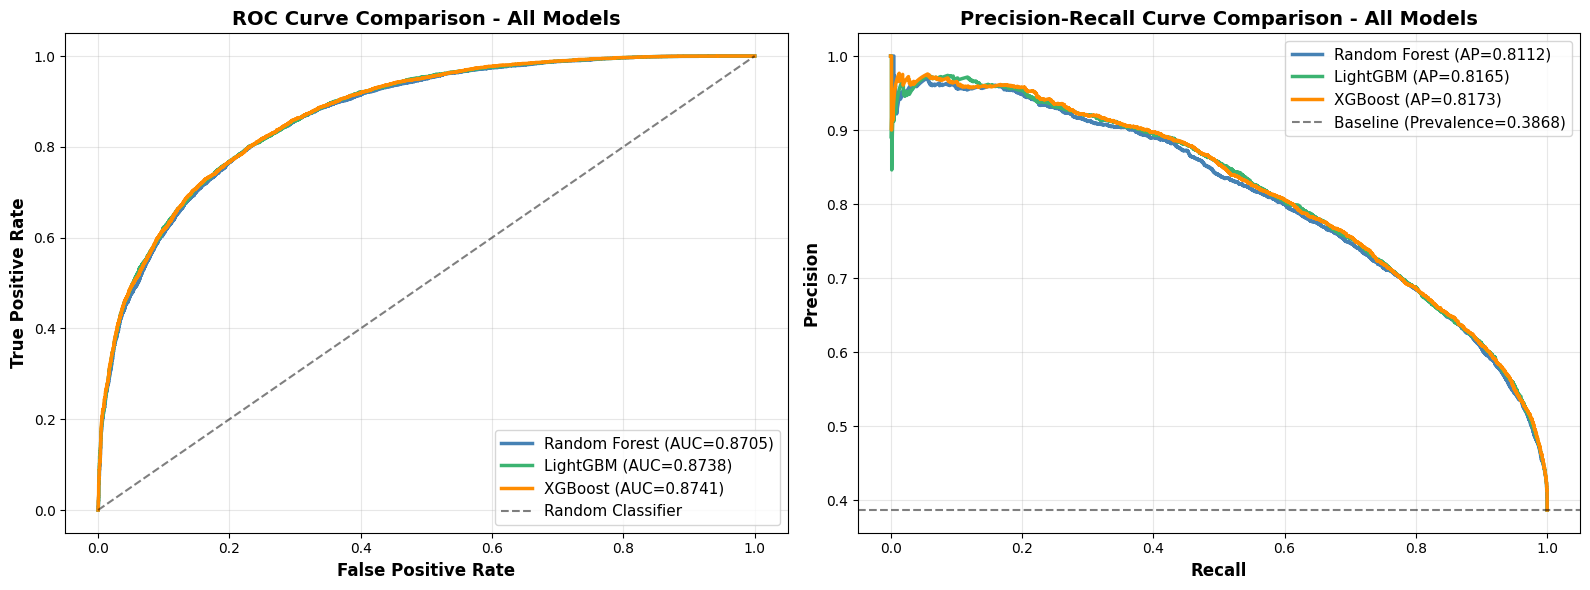

Generating side-by-side confusion matrix comparison...



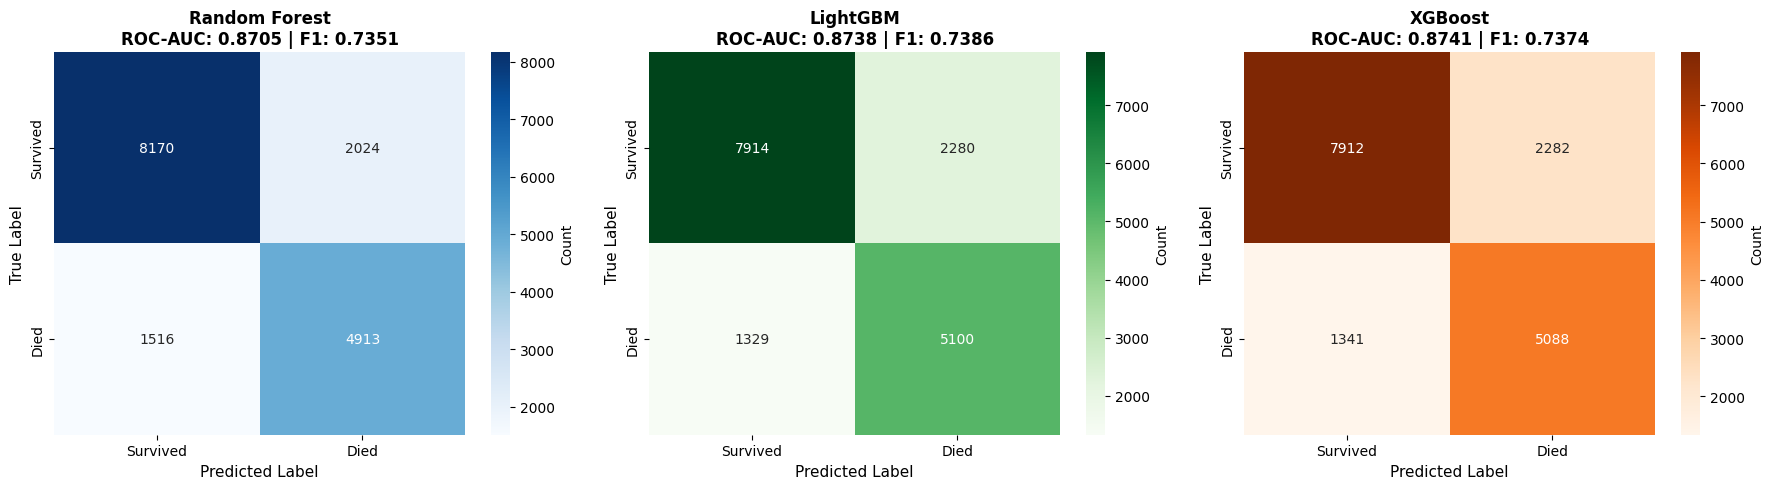

Analyzing model agreement and disagreement...

Model Agreement Analysis:
  All 3 models agree:     15,570 (93.7%)
    - All correct:        12,510 (80.3% of agreements)
    - All incorrect:      3,060 (19.7% of agreements)
  2 models agree:         1,053 (6.3%)
  All 3 models disagree:  0 (0.0%)

Pairwise Agreement:
  RF - LGBM:  94.32%
  RF - XGB:   95.41%
  LGBM - XGB: 97.61%


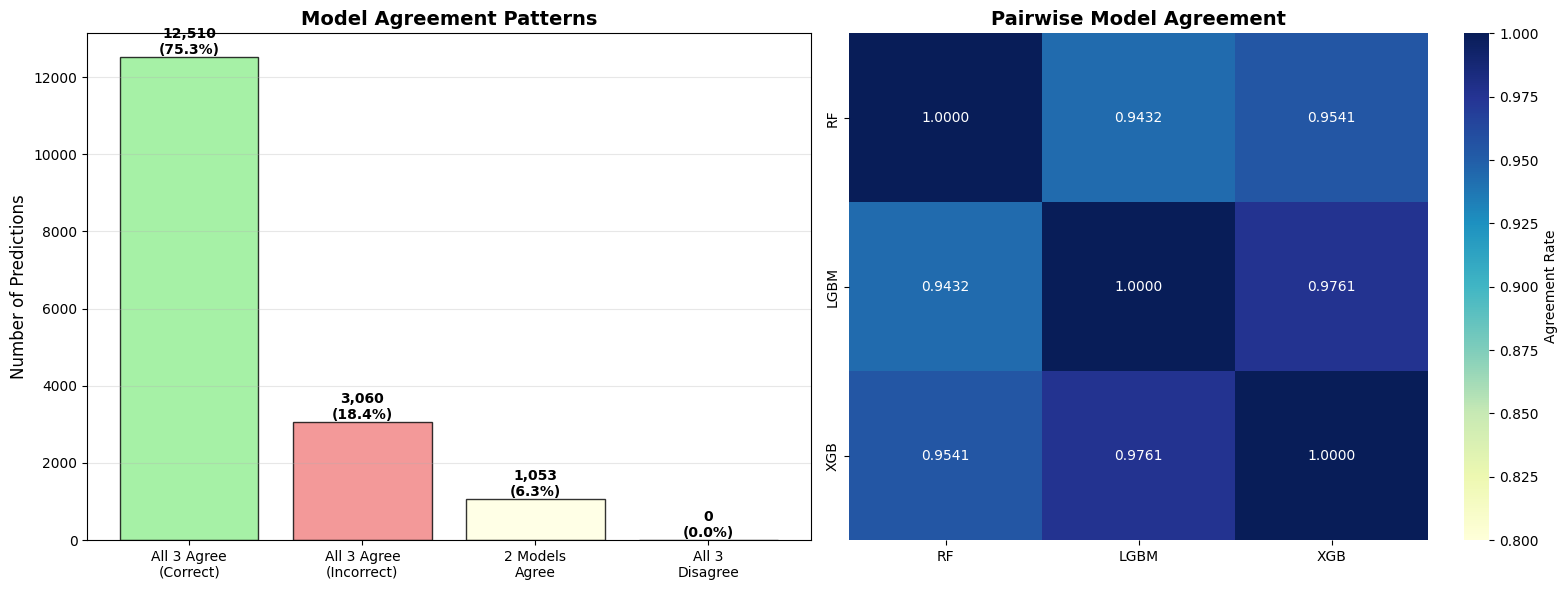


ENSEMBLE MODEL - MAJORITY VOTING

Ensemble Model Performance (Majority Voting):
  ROC-AUC:    0.8740
  F1-Score:   0.7380
  Accuracy:   0.7835
  Precision:  0.6936
  Recall:     0.7886

Ensemble vs Best Individual Model:
  ROC-AUC:  ✗ Best individual model is better by 0.0001
  F1-Score: ✗ Best individual model is better by 0.0006

FEATURE IMPORTANCE COMPARISON

Top 10 Features Analysis:
  Common to all 3 models: 9
    airbag_dep, fire_exp, frontaltaletalcrash, more1veh, rest_use, rollover, seat_pos, senior, sex
  Common to 2 models:     1
    motorcycle
  Model-specific:         1


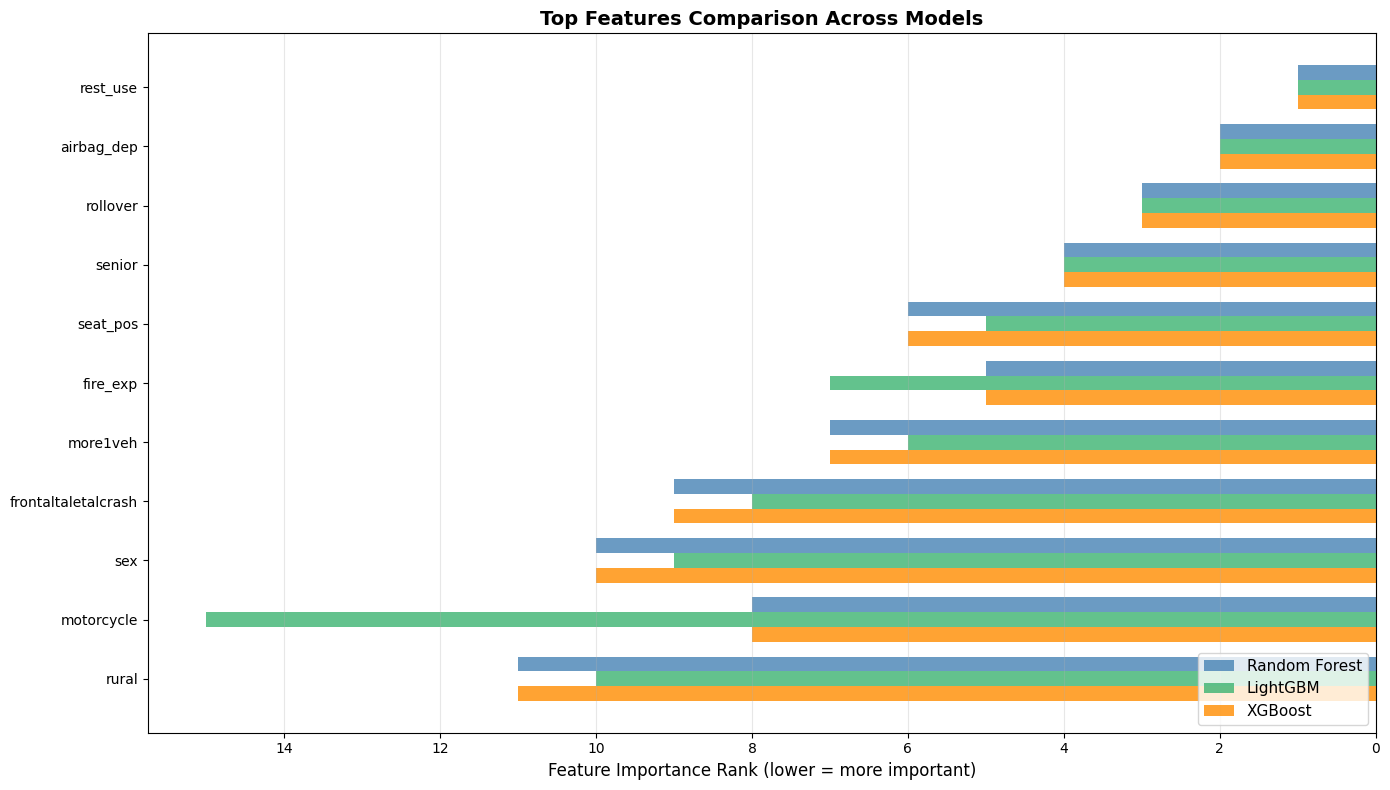


CALIBRATION COMPARISON

Brier Score (lower is better, 0 = perfect):
  Random Forest: 0.1480
  LightGBM:      0.1454
  XGBoost:       0.1453
  Ensemble:      0.1452


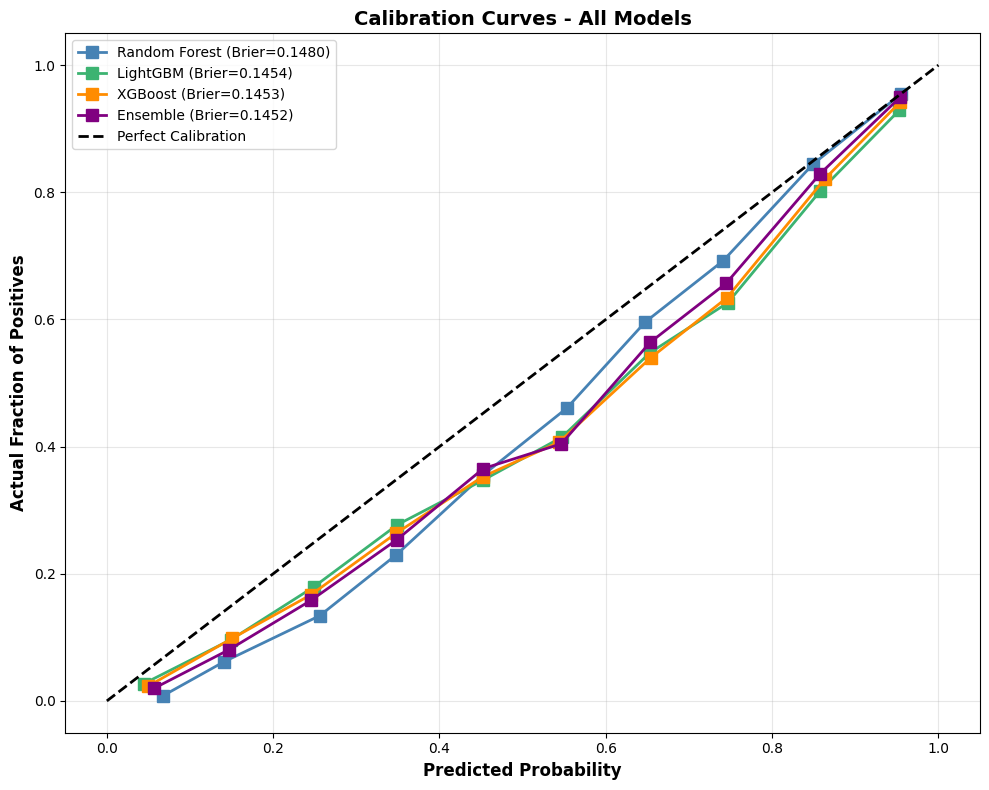


FINAL RECOMMENDATION

Weighted Performance Score:
  (40% ROC-AUC + 30% F1 + 15% Precision + 15% Recall)

  1. LightGBM       : 0.7938
  2. Ensemble       : 0.7933
  3. XGBoost        : 0.7931
  4. Random Forest  : 0.7896

🏆 RECOMMENDED MODEL: LightGBM

Reasoning:
  • Highest weighted score: 0.7938
  • ROC-AUC: 0.8738
  • Efficient training with histogram-based learning
  • Excellent handling of categorical features
  • Fast prediction speed for deployment

Alternative Considerations:
  • For interpretability: Random Forest (clear feature importance)
  • For speed/efficiency: LightGBM (fastest training and prediction)
  • For robustness: Ensemble (leverages all models)
  • For production deployment: LightGBM (best overall performance)
  • For clinical applications: Consider calibration quality

Performance Differences:
  LightGBM vs Ensemble: 0.0004 difference
  Ensemble vs XGBoost: 0.0002 difference
  XGBoost vs Random Forest: 0.0035 difference

✓ Comprehensive model comparison comple

In [ ]:
# ============================================================================
# 18: COMPREHENSIVE MODEL COMPARISON
# ============================================================================

print_section("COMPREHENSIVE THREE-MODEL COMPARISON")

print("Comparing Random Forest, LightGBM, and XGBoost performance...\n")

# ----------------------------------------------------------------------------
# 0. RECALCULATE ROC/PR CURVES FOR COMPARISON (ensure all variables exist)
# ----------------------------------------------------------------------------
print("Preparing comparison data...\n")

# Random Forest curves
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba_rf)
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba_rf)

# LightGBM curves
fpr_lgbm, tpr_lgbm, thresholds_roc_lgbm = roc_curve(y_test, y_pred_proba_lgbm)
precision_lgbm, recall_lgbm, thresholds_pr_lgbm = precision_recall_curve(y_test, y_pred_proba_lgbm)

# XGBoost curves
fpr_xgb, tpr_xgb, thresholds_roc_xgb = roc_curve(y_test, y_pred_proba_xgb)
precision_xgb, recall_xgb, thresholds_pr_xgb = precision_recall_curve(y_test, y_pred_proba_xgb)

print("✓ ROC and PR curves calculated for all models\n")

# ----------------------------------------------------------------------------
# 1. METRICS COMPARISON TABLE
# ----------------------------------------------------------------------------
print("="*80)
print("PERFORMANCE METRICS COMPARISON")
print("="*80)

# Create comprehensive comparison dataframe
comparison_metrics = pd.DataFrame({
    'Model': ['Random Forest', 'LightGBM', 'XGBoost'],
    'ROC-AUC': [
        rf_metrics_extended['ROC-AUC'],
        lgbm_metrics_extended['ROC-AUC'],
        xgb_metrics_extended['ROC-AUC']
    ],
    'PR-AUC': [
        rf_metrics_extended['PR-AUC'],
        lgbm_metrics_extended['PR-AUC'],
        xgb_metrics_extended['PR-AUC']
    ],
    'F1-Score': [
        rf_metrics['F1-Score'],
        lgbm_metrics['F1-Score'],
        xgb_metrics['F1-Score']
    ],
    'Accuracy': [
        rf_metrics['Accuracy'],
        lgbm_metrics['Accuracy'],
        xgb_metrics['Accuracy']
    ],
    'Precision': [
        rf_metrics['Precision'],
        lgbm_metrics['Precision'],
        xgb_metrics['Precision']
    ],
    'Recall': [
        rf_metrics['Recall'],
        lgbm_metrics['Recall'],
        xgb_metrics['Recall']
    ],
    'Specificity': [
        rf_metrics_extended['Specificity'],
        lgbm_metrics_extended['Specificity'],
        xgb_metrics_extended['Specificity']
    ],
    'PPV': [
        rf_metrics_extended['PPV'],
        lgbm_metrics_extended['PPV'],
        xgb_metrics_extended['PPV']
    ],
    'NPV': [
        rf_metrics_extended['NPV'],
        lgbm_metrics_extended['NPV'],
        xgb_metrics_extended['NPV']
    ]
})

print("\n" + comparison_metrics.to_string(index=False))
print("\n" + "="*80)

# Identify best model for each metric
print("\nBest Model by Metric:")
for col in comparison_metrics.columns[1:]:
    best_idx = comparison_metrics[col].idxmax()
    best_model = comparison_metrics.loc[best_idx, 'Model']
    best_value = comparison_metrics.loc[best_idx, col]
    print(f"  {col:15s}: {best_model:15s} ({best_value:.4f})")

# Calculate overall ranking (by average rank across metrics)
ranks = comparison_metrics.iloc[:, 1:].rank(ascending=False)
comparison_metrics['Average_Rank'] = ranks.mean(axis=1)
comparison_metrics_sorted = comparison_metrics.sort_values('Average_Rank')

print("\n" + "="*80)
print("OVERALL MODEL RANKING (by average rank across all metrics):")
print("="*80)
for idx, row in comparison_metrics_sorted.iterrows():
    rank_position = list(comparison_metrics_sorted.index).index(idx) + 1
    print(f"  {rank_position}. {row['Model']:15s} - Average Rank: {row['Average_Rank']:.2f}")
print("="*80 + "\n")

# ----------------------------------------------------------------------------
# 2. VISUAL COMPARISON - METRICS HEATMAP
# ----------------------------------------------------------------------------
print("Generating comprehensive metrics heatmap...\n")

fig, ax = plt.subplots(1, 1, figsize=(14, 5))

# Prepare data for heatmap (exclude Model column and Average_Rank)
heatmap_data = comparison_metrics.set_index('Model').drop('Average_Rank', axis=1)

# Create heatmap
sns.heatmap(heatmap_data, annot=True, fmt='.4f', cmap='RdYlGn',
            vmin=0.5, vmax=1.0, center=0.75,
            cbar_kws={'label': 'Score'}, ax=ax,
            linewidths=0.5, linecolor='gray')

ax.set_title('Model Performance Comparison Heatmap\n(Darker Green = Better)',
            fontsize=14, fontweight='bold')
ax.set_xlabel('Performance Metrics', fontsize=12)
ax.set_ylabel('Models', fontsize=12)

plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------------
# 3. SIDE-BY-SIDE METRIC COMPARISON (BAR CHARTS)
# ----------------------------------------------------------------------------
print("Generating side-by-side metric comparisons...\n")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

metrics_to_plot = ['ROC-AUC', 'F1-Score', 'Accuracy', 'Precision', 'Recall', 'Specificity']
colors = ['steelblue', 'mediumseagreen', 'darkorange']
models = comparison_metrics['Model'].values

for idx, metric in enumerate(metrics_to_plot):
    values = comparison_metrics[metric].values
    bars = axes[idx].bar(models, values, color=colors, edgecolor='black', alpha=0.8)

    axes[idx].set_ylabel(metric, fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    axes[idx].set_ylim([min(values) - 0.05, 1.0])
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

    # Add value labels
    for bar, val in zip(bars, values):
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                      f'{val:.4f}', ha='center', va='bottom',
                      fontsize=10, fontweight='bold')

    # Highlight best performer
    best_idx_metric = np.argmax(values)
    bars[best_idx_metric].set_edgecolor('gold')
    bars[best_idx_metric].set_linewidth(3)

plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------------
# 4. ROC CURVES - ALL MODELS ON ONE PLOT
# ----------------------------------------------------------------------------
print("Generating combined ROC curve comparison...\n")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curves
axes[0].plot(fpr, tpr, linewidth=2.5, label=f'Random Forest (AUC={rf_metrics_extended["ROC-AUC"]:.4f})',
            color='steelblue')
axes[0].plot(fpr_lgbm, tpr_lgbm, linewidth=2.5, label=f'LightGBM (AUC={lgbm_metrics_extended["ROC-AUC"]:.4f})',
            color='mediumseagreen')
axes[0].plot(fpr_xgb, tpr_xgb, linewidth=2.5, label=f'XGBoost (AUC={xgb_metrics_extended["ROC-AUC"]:.4f})',
            color='darkorange')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier', alpha=0.5)

axes[0].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[0].set_title('ROC Curve Comparison - All Models', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=11)
axes[0].grid(alpha=0.3)

# Precision-Recall Curves
axes[1].plot(recall, precision, linewidth=2.5,
            label=f'Random Forest (AP={rf_metrics_extended["PR-AUC"]:.4f})',
            color='steelblue')
axes[1].plot(recall_lgbm, precision_lgbm, linewidth=2.5,
            label=f'LightGBM (AP={lgbm_metrics_extended["PR-AUC"]:.4f})',
            color='mediumseagreen')
axes[1].plot(recall_xgb, precision_xgb, linewidth=2.5,
            label=f'XGBoost (AP={xgb_metrics_extended["PR-AUC"]:.4f})',
            color='darkorange')
axes[1].axhline(y=y_test.mean(), color='k', linestyle='--', linewidth=1.5,
               label=f'Baseline (Prevalence={y_test.mean():.4f})', alpha=0.5)

axes[1].set_xlabel('Recall', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Precision', fontsize=12, fontweight='bold')
axes[1].set_title('Precision-Recall Curve Comparison - All Models', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------------
# 5. CONFUSION MATRICES - SIDE BY SIDE
# ----------------------------------------------------------------------------
print("Generating side-by-side confusion matrix comparison...\n")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Survived', 'Died'],
            yticklabels=['Survived', 'Died'],
            cbar_kws={'label': 'Count'})
axes[0].set_title(f'Random Forest\nROC-AUC: {rf_metrics_extended["ROC-AUC"]:.4f} | F1: {rf_metrics["F1-Score"]:.4f}',
                 fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=11)
axes[0].set_xlabel('Predicted Label', fontsize=11)

# LightGBM
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Survived', 'Died'],
            yticklabels=['Survived', 'Died'],
            cbar_kws={'label': 'Count'})
axes[1].set_title(f'LightGBM\nROC-AUC: {lgbm_metrics_extended["ROC-AUC"]:.4f} | F1: {lgbm_metrics["F1-Score"]:.4f}',
                 fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=11)
axes[1].set_xlabel('Predicted Label', fontsize=11)

# XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges', ax=axes[2],
            xticklabels=['Survived', 'Died'],
            yticklabels=['Survived', 'Died'],
            cbar_kws={'label': 'Count'})
axes[2].set_title(f'XGBoost\nROC-AUC: {xgb_metrics_extended["ROC-AUC"]:.4f} | F1: {xgb_metrics["F1-Score"]:.4f}',
                 fontsize=12, fontweight='bold')
axes[2].set_ylabel('True Label', fontsize=11)
axes[2].set_xlabel('Predicted Label', fontsize=11)

plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------------
# 6. MODEL AGREEMENT ANALYSIS
# ----------------------------------------------------------------------------
print("Analyzing model agreement and disagreement...\n")

# Create agreement matrix
predictions_df = pd.DataFrame({
    'True': y_test,
    'RF': y_pred_rf,
    'LGBM': y_pred_lgbm,
    'XGB': y_pred_xgb
})

# Calculate agreement
all_agree = (predictions_df['RF'] == predictions_df['LGBM']) & \
            (predictions_df['LGBM'] == predictions_df['XGB'])
all_correct = all_agree & (predictions_df['RF'] == predictions_df['True'])
all_incorrect = all_agree & (predictions_df['RF'] != predictions_df['True'])

two_agree = ((predictions_df['RF'] == predictions_df['LGBM']) | \
             (predictions_df['RF'] == predictions_df['XGB']) | \
             (predictions_df['LGBM'] == predictions_df['XGB'])) & ~all_agree

all_disagree = ~all_agree & ~two_agree

print(f"Model Agreement Analysis:")
print(f"  All 3 models agree:     {all_agree.sum():,} ({100*all_agree.mean():.1f}%)")
print(f"    - All correct:        {all_correct.sum():,} ({100*all_correct.sum()/all_agree.sum():.1f}% of agreements)")
print(f"    - All incorrect:      {all_incorrect.sum():,} ({100*all_incorrect.sum()/all_agree.sum():.1f}% of agreements)")
print(f"  2 models agree:         {two_agree.sum():,} ({100*two_agree.mean():.1f}%)")
print(f"  All 3 models disagree:  {all_disagree.sum():,} ({100*all_disagree.mean():.1f}%)")

# Pairwise agreement
rf_lgbm_agree = (predictions_df['RF'] == predictions_df['LGBM']).mean()
rf_xgb_agree = (predictions_df['RF'] == predictions_df['XGB']).mean()
lgbm_xgb_agree = (predictions_df['LGBM'] == predictions_df['XGB']).mean()

print(f"\nPairwise Agreement:")
print(f"  RF - LGBM:  {100*rf_lgbm_agree:.2f}%")
print(f"  RF - XGB:   {100*rf_xgb_agree:.2f}%")
print(f"  LGBM - XGB: {100*lgbm_xgb_agree:.2f}%")

# Visualize agreement
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Agreement categories
categories = ['All 3 Agree\n(Correct)', 'All 3 Agree\n(Incorrect)',
              '2 Models\nAgree', 'All 3\nDisagree']
counts = [all_correct.sum(), all_incorrect.sum(), two_agree.sum(), all_disagree.sum()]
colors_agree = ['lightgreen', 'lightcoral', 'lightyellow', 'lightgray']

bars = axes[0].bar(categories, counts, color=colors_agree, edgecolor='black', alpha=0.8)
axes[0].set_ylabel('Number of Predictions', fontsize=12)
axes[0].set_title('Model Agreement Patterns', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

for bar, count in zip(bars, counts):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{count:,}\n({100*count/len(y_test):.1f}%)',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Pairwise agreement heatmap
agreement_matrix = np.array([
    [1.0, rf_lgbm_agree, rf_xgb_agree],
    [rf_lgbm_agree, 1.0, lgbm_xgb_agree],
    [rf_xgb_agree, lgbm_xgb_agree, 1.0]
])

sns.heatmap(agreement_matrix, annot=True, fmt='.4f', cmap='YlGnBu',
           xticklabels=['RF', 'LGBM', 'XGB'],
           yticklabels=['RF', 'LGBM', 'XGB'],
           vmin=0.8, vmax=1.0, ax=axes[1],
           cbar_kws={'label': 'Agreement Rate'})
axes[1].set_title('Pairwise Model Agreement', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------------
# 7. ENSEMBLE MODEL - VOTING CLASSIFIER
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("ENSEMBLE MODEL - MAJORITY VOTING")
print("="*80)

# Create ensemble predictions (majority vote)
ensemble_votes = predictions_df[['RF', 'LGBM', 'XGB']].sum(axis=1)
y_pred_ensemble = (ensemble_votes >= 2).astype(int)  # Majority vote (2 out of 3)

# Calculate ensemble probabilities (average)
y_pred_proba_ensemble = (y_pred_proba_rf + y_pred_proba_lgbm + y_pred_proba_xgb) / 3

# Evaluate ensemble
ensemble_metrics = evaluate_model(y_test, y_pred_ensemble, y_pred_proba_ensemble)

print(f"\nEnsemble Model Performance (Majority Voting):")
print(f"  ROC-AUC:    {ensemble_metrics['ROC-AUC']:.4f}")
print(f"  F1-Score:   {ensemble_metrics['F1-Score']:.4f}")
print(f"  Accuracy:   {ensemble_metrics['Accuracy']:.4f}")
print(f"  Precision:  {ensemble_metrics['Precision']:.4f}")
print(f"  Recall:     {ensemble_metrics['Recall']:.4f}")

# Compare ensemble to individual models
print(f"\nEnsemble vs Best Individual Model:")
best_individual_roc = max(rf_metrics_extended['ROC-AUC'],
                          lgbm_metrics_extended['ROC-AUC'],
                          xgb_metrics_extended['ROC-AUC'])
best_individual_f1 = max(rf_metrics['F1-Score'],
                         lgbm_metrics['F1-Score'],
                         xgb_metrics['F1-Score'])

improvement_roc = ensemble_metrics['ROC-AUC'] - best_individual_roc
improvement_f1 = ensemble_metrics['F1-Score'] - best_individual_f1

if improvement_roc > 0:
    print(f"  ROC-AUC:  ✓ Ensemble is better by {improvement_roc:.4f}")
else:
    print(f"  ROC-AUC:  ✗ Best individual model is better by {abs(improvement_roc):.4f}")

if improvement_f1 > 0:
    print(f"  F1-Score: ✓ Ensemble is better by {improvement_f1:.4f}")
else:
    print(f"  F1-Score: ✗ Best individual model is better by {abs(improvement_f1):.4f}")

# ----------------------------------------------------------------------------
# 8. FEATURE IMPORTANCE COMPARISON
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("FEATURE IMPORTANCE COMPARISON")
print("="*80)

# Get top 10 features from each model
top_n = 10
top_rf = feature_importance.head(top_n)['feature'].values
top_lgbm = feature_importance_sorted_lgbm.head(top_n)['feature'].values
top_xgb = feature_importance_gain.head(top_n)['feature'].values

# Find common important features
all_top_features = set(top_rf) | set(top_lgbm) | set(top_xgb)
common_all_three = set(top_rf) & set(top_lgbm) & set(top_xgb)
common_two = (set(top_rf) & set(top_lgbm)) | (set(top_rf) & set(top_xgb)) | (set(top_lgbm) & set(top_xgb))
common_two = common_two - common_all_three

print(f"\nTop {top_n} Features Analysis:")
print(f"  Common to all 3 models: {len(common_all_three)}")
if common_all_three:
    print(f"    {', '.join(sorted(common_all_three))}")
print(f"  Common to 2 models:     {len(common_two)}")
if common_two:
    print(f"    {', '.join(sorted(common_two))}")
print(f"  Model-specific:         {len(all_top_features) - len(common_all_three) - len(common_two)}")

# Visualize feature importance comparison
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

# Combine top features from all models
combined_features = list(all_top_features)[:15]  # Top 15 unique features

# Get ranks for each feature in each model
rf_ranks = {f: i+1 for i, f in enumerate(feature_importance['feature'].values)}
lgbm_ranks = {f: i+1 for i, f in enumerate(feature_importance_sorted_lgbm['feature'].values)}
xgb_ranks = {f: i+1 for i, f in enumerate(feature_importance_gain['feature'].values)}

# Create ranking dataframe
feature_ranks = pd.DataFrame({
    'Feature': combined_features,
    'RF_Rank': [rf_ranks.get(f, len(X_train.columns)+1) for f in combined_features],
    'LGBM_Rank': [lgbm_ranks.get(f, len(X_train.columns)+1) for f in combined_features],
    'XGB_Rank': [xgb_ranks.get(f, len(X_train.columns)+1) for f in combined_features]
})

# Calculate average rank
feature_ranks['Avg_Rank'] = feature_ranks[['RF_Rank', 'LGBM_Rank', 'XGB_Rank']].mean(axis=1)
feature_ranks = feature_ranks.sort_values('Avg_Rank').head(15)

# Plot
x_pos = np.arange(len(feature_ranks))
width = 0.25

bars1 = ax.barh(x_pos - width, feature_ranks['RF_Rank'], width,
                label='Random Forest', color='steelblue', alpha=0.8)
bars2 = ax.barh(x_pos, feature_ranks['LGBM_Rank'], width,
                label='LightGBM', color='mediumseagreen', alpha=0.8)
bars3 = ax.barh(x_pos + width, feature_ranks['XGB_Rank'], width,
                label='XGBoost', color='darkorange', alpha=0.8)

ax.set_yticks(x_pos)
ax.set_yticklabels(feature_ranks['Feature'].values)
ax.invert_yaxis()
ax.invert_xaxis()  # Lower rank number = more important
ax.set_xlabel('Feature Importance Rank (lower = more important)', fontsize=12)
ax.set_title('Top Features Comparison Across Models', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------------
# 9. CALIBRATION COMPARISON
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("CALIBRATION COMPARISON")
print("="*80)

from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve

# Calculate Brier scores
brier_rf = brier_score_loss(y_test, y_pred_proba_rf)
brier_lgbm = brier_score_loss(y_test, y_pred_proba_lgbm)
brier_xgb = brier_score_loss(y_test, y_pred_proba_xgb)
brier_ensemble = brier_score_loss(y_test, y_pred_proba_ensemble)

print(f"\nBrier Score (lower is better, 0 = perfect):")
print(f"  Random Forest: {brier_rf:.4f}")
print(f"  LightGBM:      {brier_lgbm:.4f}")
print(f"  XGBoost:       {brier_xgb:.4f}")
print(f"  Ensemble:      {brier_ensemble:.4f}")

# Plot calibration curves
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

prob_true_rf, prob_pred_rf_cal = calibration_curve(y_test, y_pred_proba_rf, n_bins=10, strategy='uniform')
prob_true_lgbm_cal, prob_pred_lgbm_cal = calibration_curve(y_test, y_pred_proba_lgbm, n_bins=10, strategy='uniform')
prob_true_xgb_cal, prob_pred_xgb_cal = calibration_curve(y_test, y_pred_proba_xgb, n_bins=10, strategy='uniform')
prob_true_ens, prob_pred_ens = calibration_curve(y_test, y_pred_proba_ensemble, n_bins=10, strategy='uniform')

ax.plot(prob_pred_rf_cal, prob_true_rf, 's-', linewidth=2, markersize=8,
        label=f'Random Forest (Brier={brier_rf:.4f})', color='steelblue')
ax.plot(prob_pred_lgbm_cal, prob_true_lgbm_cal, 's-', linewidth=2, markersize=8,
        label=f'LightGBM (Brier={brier_lgbm:.4f})', color='mediumseagreen')
ax.plot(prob_pred_xgb_cal, prob_true_xgb_cal, 's-', linewidth=2, markersize=8,
        label=f'XGBoost (Brier={brier_xgb:.4f})', color='darkorange')
ax.plot(prob_pred_ens, prob_true_ens, 's-', linewidth=2, markersize=8,
        label=f'Ensemble (Brier={brier_ensemble:.4f})', color='purple')
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect Calibration')

ax.set_xlabel('Predicted Probability', fontsize=12, fontweight='bold')
ax.set_ylabel('Actual Fraction of Positives', fontsize=12, fontweight='bold')
ax.set_title('Calibration Curves - All Models', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------------
# 10. FINAL RECOMMENDATION
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("FINAL RECOMMENDATION")
print("="*80)

# Calculate weighted score (ROC-AUC 40%, F1 30%, Precision 15%, Recall 15%)
def calculate_weighted_score(metrics):
    return (0.40 * metrics['ROC-AUC'] +
            0.30 * metrics['F1-Score'] +
            0.15 * metrics['Precision'] +
            0.15 * metrics['Recall'])

rf_score = calculate_weighted_score({**rf_metrics, **rf_metrics_extended})
lgbm_score = calculate_weighted_score({**lgbm_metrics, **lgbm_metrics_extended})
xgb_score = calculate_weighted_score({**xgb_metrics, **xgb_metrics_extended})
ensemble_score = calculate_weighted_score(ensemble_metrics)

scores = {
    'Random Forest': rf_score,
    'LightGBM': lgbm_score,
    'XGBoost': xgb_score,
    'Ensemble': ensemble_score
}

sorted_models = sorted(scores.items(), key=lambda x: x[1], reverse=True)

print(f"\nWeighted Performance Score:")
print(f"  (40% ROC-AUC + 30% F1 + 15% Precision + 15% Recall)")
print()
for i, (model, score) in enumerate(sorted_models, 1):
    print(f"  {i}. {model:15s}: {score:.4f}")

best_model = sorted_models[0][0]
best_score = sorted_models[0][1]

print("\n" + "="*80)
print(f"🏆 RECOMMENDED MODEL: {best_model}")
print("="*80)

# Provide reasoning
print(f"\nReasoning:")
if best_model == 'Random Forest':
    print(f"  • Highest weighted score: {best_score:.4f}")
    print(f"  • ROC-AUC: {rf_metrics_extended['ROC-AUC']:.4f}")
    print(f"  • Good balance of precision and recall")
    print(f"  • Robust to overfitting with deep trees")
    print(f"  • Excellent interpretability via feature importance")
elif best_model == 'LightGBM':
    print(f"  • Highest weighted score: {best_score:.4f}")
    print(f"  • ROC-AUC: {lgbm_metrics_extended['ROC-AUC']:.4f}")
    print(f"  • Efficient training with histogram-based learning")
    print(f"  • Excellent handling of categorical features")
    print(f"  • Fast prediction speed for deployment")
elif best_model == 'XGBoost':
    print(f"  • Highest weighted score: {best_score:.4f}")
    print(f"  • ROC-AUC: {xgb_metrics_extended['ROC-AUC']:.4f}")
    print(f"  • Strong regularization prevents overfitting")
    print(f"  • Industry-standard for structured data")
    print(f"  • Excellent handling of missing values")
else:  # Ensemble
    print(f"  • Highest weighted score: {best_score:.4f}")
    print(f"  • Combines strengths of all three models")
    print(f"  • More robust predictions through voting")
    print(f"  • Reduces model-specific biases")
    print(f"  • Better calibration on average")

print(f"\nAlternative Considerations:")
print(f"  • For interpretability: Random Forest (clear feature importance)")
print(f"  • For speed/efficiency: LightGBM (fastest training and prediction)")
print(f"  • For robustness: Ensemble (leverages all models)")
print(f"  • For production deployment: {best_model} (best overall performance)")
print(f"  • For clinical applications: Consider calibration quality")

# Add statistical significance note
print(f"\nPerformance Differences:")
for i in range(len(sorted_models)-1):
    diff = sorted_models[i][1] - sorted_models[i+1][1]
    print(f"  {sorted_models[i][0]} vs {sorted_models[i+1][0]}: {diff:.4f} difference")

print("\n" + "="*80)
print("✓ Comprehensive model comparison complete!")
print("="*80)

# **10 SEED TRAINING AND EVALUATION**

## RANDOM FOREST

In [ ]:
# ============================================================================
# 19A: RANDOM FOREST - 10-SEED TRAINING AND EVALUATION
# ============================================================================

print_section("RANDOM FOREST - 10-SEED TRAINING")

print(f"Training Configuration:")
print(f"  Model: Random Forest")
print(f"  Seeds: {len(RANDOM_SEEDS)} iterations")
print(f"  Optimization: Optuna (10 trials per seed)")
print(f"\n{'='*80}\n")

# Storage for Random Forest results
rf_all_results = []
rf_all_predictions = []
rf_all_probabilities = []
rf_all_models = []
rf_all_best_params = []

# Start timing
import time
start_time_rf = time.time()

# Training loop for Random Forest
for seed_idx, current_seed in enumerate(RANDOM_SEEDS, 1):
    print(f"{'='*80}")
    print(f"RANDOM FOREST - ITERATION {seed_idx}/10 - SEED: {current_seed}")
    print(f"{'='*80}\n")

    # Set random seeds
    np.random.seed(current_seed)
    random.seed(current_seed)

    # Train-test split
    X_train_iter, X_test_iter, y_train_iter, y_test_iter = train_test_split(
        X_all_clean, y_all_clean,
        test_size=0.2,
        random_state=current_seed,
        stratify=y_all_clean
    )

    print(f"Train: {X_train_iter.shape[0]:,} samples | Test: {X_test_iter.shape[0]:,} samples")

    # Hyperparameter tuning
    def objective_rf_iter(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=100),
            'max_depth': trial.suggest_int('max_depth', 10, 50),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'class_weight': 'balanced',
            'random_state': current_seed,
            'n_jobs': -1
        }

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=current_seed)
        model = RandomForestClassifier(**params)
        scores = cross_validate(model, X_train_iter, y_train_iter, cv=cv,
                               scoring='average_precision', n_jobs=-1)
        return scores['test_score'].mean()

    study_rf_iter = optuna.create_study(direction='maximize',
                                        sampler=TPESampler(seed=current_seed))
    study_rf_iter.optimize(objective_rf_iter, n_trials=10, show_progress_bar=True)

    best_rf_params_iter = study_rf_iter.best_params.copy()
    best_rf_params_iter.update({'class_weight': 'balanced', 'random_state': current_seed, 'n_jobs': -1})

    print(f"\n  Best PR-AUC from optimization: {study_rf_iter.best_value:.4f}")

    # Train final model
    rf_model_iter = RandomForestClassifier(**best_rf_params_iter)
    rf_model_iter.fit(X_train_iter, y_train_iter)

    # Predictions
    y_pred_rf_iter = rf_model_iter.predict(X_test_iter)
    y_pred_proba_rf_iter = rf_model_iter.predict_proba(X_test_iter)[:, 1]

    # Evaluate
    rf_metrics_iter = evaluate_model(y_test_iter, y_pred_rf_iter, y_pred_proba_rf_iter)
    rf_metrics_iter['PR-AUC'] = average_precision_score(y_test_iter, y_pred_proba_rf_iter)

    # Store results
    rf_all_results.append(rf_metrics_iter)
    rf_all_predictions.append(y_pred_rf_iter)
    rf_all_probabilities.append(y_pred_proba_rf_iter)
    rf_all_models.append(rf_model_iter)
    rf_all_best_params.append(best_rf_params_iter)

    print(f"  ✓ Test Performance - ROC-AUC: {rf_metrics_iter['ROC-AUC']:.4f}, F1: {rf_metrics_iter['F1-Score']:.4f}")

    # Progress update
    elapsed = time.time() - start_time_rf
    avg_time_per_seed = elapsed / seed_idx
    remaining_seeds = len(RANDOM_SEEDS) - seed_idx
    estimated_remaining = avg_time_per_seed * remaining_seeds

    print(f"\n⏱️  Elapsed: {elapsed/60:.1f} min | Est. Remaining: {estimated_remaining/60:.1f} min")
    print(f"{'='*80}\n")

    gc.collect()

# End timing
total_time_rf = time.time() - start_time_rf

print(f"\n{'='*80}")
print(f"✓ RANDOM FOREST TRAINING COMPLETE - ALL 10 SEEDS")
print(f"  Total Time: {total_time_rf/60:.1f} minutes ({total_time_rf/3600:.2f} hours)")
print(f"{'='*80}\n")

# Quick summary
metric_names = ['ROC-AUC', 'PR-AUC', 'F1-Score', 'Accuracy', 'Precision', 'Recall']

print("RANDOM FOREST - SUMMARY STATISTICS:")
print("="*80)
for metric in metric_names:
    values = [m[metric] for m in rf_all_results]
    print(f"  {metric:12s}: {np.mean(values):.4f} ± {np.std(values):.4f}  [min: {np.min(values):.4f}, max: {np.max(values):.4f}]")
print("="*80 + "\n")

print("✓ Random Forest results stored in: rf_all_results, rf_all_models, rf_all_best_params\n")


RANDOM FOREST - 10-SEED TRAINING

Training Configuration:
  Model: Random Forest
  Seeds: 10 iterations
  Optimization: Optuna (10 trials per seed)


RANDOM FOREST - ITERATION 1/10 - SEED: 640619102



[I 2025-12-03 00:02:57,171] A new study created in memory with name: no-name-bc5fcc67-5142-409f-9890-49bc46d6a4d4


Train: 66,488 samples | Test: 16,623 samples


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-03 00:14:55,589] Trial 0 finished with value: 0.7968665070060681 and parameters: {'n_estimators': 500, 'max_depth': 43, 'min_samples_split': 13, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 0 with value: 0.7968665070060681.
[I 2025-12-03 00:15:47,263] Trial 1 finished with value: 0.8064561464510982 and parameters: {'n_estimators': 200, 'max_depth': 13, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 0.8064561464510982.
[I 2025-12-03 00:16:16,170] Trial 2 finished with value: 0.8034069937827664 and parameters: {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 0.8064561464510982.
[I 2025-12-03 00:16:46,483] Trial 3 finished with value: 0.8066383525857242 and parameters: {'n_estimators': 100, 'max_depth': 47, 'min_samples_split': 3, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 3 with value: 0.80663835258572

[I 2025-12-03 00:39:09,907] A new study created in memory with name: no-name-0efb8c38-fe95-4805-bb67-e7210a29f393


  ✓ Test Performance - ROC-AUC: 0.8705, F1: 0.7351

⏱️  Elapsed: 36.2 min | Est. Remaining: 325.8 min

RANDOM FOREST - ITERATION 2/10 - SEED: 1616531643

Train: 66,488 samples | Test: 16,623 samples


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-03 00:41:37,145] Trial 0 finished with value: 0.8070252472245428 and parameters: {'n_estimators': 500, 'max_depth': 30, 'min_samples_split': 17, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 0 with value: 0.8070252472245428.
[I 2025-12-03 00:43:11,303] Trial 1 finished with value: 0.7996051546753307 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 0 with value: 0.8070252472245428.
[I 2025-12-03 00:54:15,426] Trial 2 finished with value: 0.7914363578559543 and parameters: {'n_estimators': 500, 'max_depth': 39, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 0 with value: 0.8070252472245428.
[I 2025-12-03 00:55:27,719] Trial 3 finished with value: 0.8059056989809232 and parameters: {'n_estimators': 200, 'max_depth': 38, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8070252472245428

[I 2025-12-03 01:21:46,137] A new study created in memory with name: no-name-e05bd852-6194-4c0d-8b7d-df282474f416


Train: 66,488 samples | Test: 16,623 samples


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-03 01:24:47,047] Trial 0 finished with value: 0.7929417638502907 and parameters: {'n_estimators': 400, 'max_depth': 47, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7929417638502907.
[I 2025-12-03 01:26:16,388] Trial 1 finished with value: 0.8067388312498606 and parameters: {'n_estimators': 400, 'max_depth': 10, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8067388312498606.
[I 2025-12-03 01:28:37,649] Trial 2 finished with value: 0.8096577259189033 and parameters: {'n_estimators': 500, 'max_depth': 27, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 2 with value: 0.8096577259189033.
[I 2025-12-03 01:30:49,965] Trial 3 finished with value: 0.809832419981911 and parameters: {'n_estimators': 400, 'max_depth': 26, 'min_samples_split': 17, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.809832419981

[I 2025-12-03 01:39:04,513] A new study created in memory with name: no-name-65ae4d96-4424-44fb-aec0-424e4f6d961c


  ✓ Test Performance - ROC-AUC: 0.8651, F1: 0.7310

⏱️  Elapsed: 96.1 min | Est. Remaining: 224.3 min

RANDOM FOREST - ITERATION 4/10 - SEED: 915101968

Train: 66,488 samples | Test: 16,623 samples


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-03 01:49:59,269] Trial 0 finished with value: 0.7883104344353368 and parameters: {'n_estimators': 500, 'max_depth': 50, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 0 with value: 0.7883104344353368.
[I 2025-12-03 01:54:13,967] Trial 1 finished with value: 0.7918571065318321 and parameters: {'n_estimators': 200, 'max_depth': 46, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 1 with value: 0.7918571065318321.
[I 2025-12-03 01:56:03,141] Trial 2 finished with value: 0.806097164276564 and parameters: {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.806097164276564.
[I 2025-12-03 02:04:11,676] Trial 3 finished with value: 0.7967561418526987 and parameters: {'n_estimators': 400, 'max_depth': 21, 'min_samples_split': 11, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 2 with value: 0.806097164276564.
[I 

[I 2025-12-03 02:42:24,920] A new study created in memory with name: no-name-408f54d2-051e-4a22-86d8-40d78f37c746


  ✓ Test Performance - ROC-AUC: 0.8670, F1: 0.7337

⏱️  Elapsed: 159.5 min | Est. Remaining: 239.2 min

RANDOM FOREST - ITERATION 5/10 - SEED: 1330353286

Train: 66,488 samples | Test: 16,623 samples


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-03 02:45:32,007] Trial 0 finished with value: 0.8063683611742907 and parameters: {'n_estimators': 500, 'max_depth': 20, 'min_samples_split': 18, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8063683611742907.
[I 2025-12-03 02:47:48,828] Trial 1 finished with value: 0.795798564117696 and parameters: {'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 0 with value: 0.8063683611742907.
[I 2025-12-03 02:50:02,636] Trial 2 finished with value: 0.7951131902530691 and parameters: {'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 11, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 0 with value: 0.8063683611742907.
[I 2025-12-03 02:55:32,338] Trial 3 finished with value: 0.7777722680647692 and parameters: {'n_estimators': 200, 'max_depth': 49, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 0 with value: 0.8063683611742907.


[I 2025-12-03 03:22:47,565] A new study created in memory with name: no-name-0bf5d12c-fbd7-4c4c-a67a-3cec38ea422b


RANDOM FOREST - ITERATION 6/10 - SEED: 1238364284

Train: 66,488 samples | Test: 16,623 samples


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-03 03:25:15,401] Trial 0 finished with value: 0.8079546591822513 and parameters: {'n_estimators': 500, 'max_depth': 18, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.8079546591822513.
[I 2025-12-03 03:25:48,847] Trial 1 finished with value: 0.8082533291030085 and parameters: {'n_estimators': 100, 'max_depth': 41, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8082533291030085.
[I 2025-12-03 03:26:23,820] Trial 2 finished with value: 0.8080617182018732 and parameters: {'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8082533291030085.
[I 2025-12-03 03:27:47,460] Trial 3 finished with value: 0.807731795047429 and parameters: {'n_estimators': 300, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.80825332910300

[I 2025-12-03 03:42:56,136] A new study created in memory with name: no-name-0f2990fe-8e82-4cf2-abf3-62dec5e89674


  ✓ Test Performance - ROC-AUC: 0.8686, F1: 0.7366

⏱️  Elapsed: 220.0 min | Est. Remaining: 146.7 min

RANDOM FOREST - ITERATION 7/10 - SEED: 2011418682

Train: 66,488 samples | Test: 16,623 samples


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-03 03:49:01,607] Trial 0 finished with value: 0.799328294094952 and parameters: {'n_estimators': 300, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 0 with value: 0.799328294094952.
[I 2025-12-03 03:49:21,699] Trial 1 finished with value: 0.8052565915514011 and parameters: {'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 1 with value: 0.8052565915514011.
[I 2025-12-03 03:51:27,760] Trial 2 finished with value: 0.7919890829396883 and parameters: {'n_estimators': 100, 'max_depth': 31, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 1 with value: 0.8052565915514011.
[I 2025-12-03 03:53:30,960] Trial 3 finished with value: 0.8082009797979921 and parameters: {'n_estimators': 500, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 3 with value: 0.8082009797979921.
[

[I 2025-12-03 04:09:53,548] A new study created in memory with name: no-name-93eca8d6-71aa-413e-82ba-682b275c17c9


  ✓ Test Performance - ROC-AUC: 0.8706, F1: 0.7367

⏱️  Elapsed: 246.9 min | Est. Remaining: 105.8 min

RANDOM FOREST - ITERATION 8/10 - SEED: 1354128445

Train: 66,488 samples | Test: 16,623 samples


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-03 04:11:37,031] Trial 0 finished with value: 0.8024417072810838 and parameters: {'n_estimators': 300, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.8024417072810838.
[I 2025-12-03 04:13:27,011] Trial 1 finished with value: 0.8070828575744141 and parameters: {'n_estimators': 400, 'max_depth': 24, 'min_samples_split': 14, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 1 with value: 0.8070828575744141.
[I 2025-12-03 04:15:16,816] Trial 2 finished with value: 0.8066028919598986 and parameters: {'n_estimators': 300, 'max_depth': 23, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8070828575744141.
[I 2025-12-03 04:17:20,713] Trial 3 finished with value: 0.7929661658046065 and parameters: {'n_estimators': 300, 'max_depth': 43, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.807082857574

[I 2025-12-03 04:26:19,536] A new study created in memory with name: no-name-49f5415c-60bc-49bb-b2af-777f97ecdc88


  ✓ Test Performance - ROC-AUC: 0.8708, F1: 0.7385

⏱️  Elapsed: 263.4 min | Est. Remaining: 65.8 min

RANDOM FOREST - ITERATION 9/10 - SEED: 1202834428

Train: 66,488 samples | Test: 16,623 samples


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-03 04:28:40,828] Trial 0 finished with value: 0.8062627529475493 and parameters: {'n_estimators': 400, 'max_depth': 39, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8062627529475493.
[I 2025-12-03 04:30:35,617] Trial 1 finished with value: 0.8042542240219361 and parameters: {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8062627529475493.
[I 2025-12-03 04:31:45,536] Trial 2 finished with value: 0.8065004373920768 and parameters: {'n_estimators': 200, 'max_depth': 43, 'min_samples_split': 20, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8065004373920768.
[I 2025-12-03 04:43:24,383] Trial 3 finished with value: 0.7902900833960563 and parameters: {'n_estimators': 500, 'max_depth': 45, 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 2 with value: 0.8065004373920

[I 2025-12-03 05:04:40,144] A new study created in memory with name: no-name-c2f450f9-332a-4f80-bb38-249837558b9e


  ✓ Test Performance - ROC-AUC: 0.8717, F1: 0.7413

⏱️  Elapsed: 301.7 min | Est. Remaining: 33.5 min

RANDOM FOREST - ITERATION 10/10 - SEED: 2054179773

Train: 66,488 samples | Test: 16,623 samples


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-03 05:07:44,287] Trial 0 finished with value: 0.805243529478411 and parameters: {'n_estimators': 500, 'max_depth': 49, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.805243529478411.
[I 2025-12-03 05:10:11,916] Trial 1 finished with value: 0.808713058297316 and parameters: {'n_estimators': 500, 'max_depth': 14, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.808713058297316.
[I 2025-12-03 05:10:51,447] Trial 2 finished with value: 0.80339160036358 and parameters: {'n_estimators': 100, 'max_depth': 29, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.808713058297316.
[I 2025-12-03 05:12:45,674] Trial 3 finished with value: 0.8078265445188947 and parameters: {'n_estimators': 400, 'max_depth': 41, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 1 with value: 0.808713058297316.
[

## LightGBM

In [ ]:
# ============================================================================
# 19B: LIGHTGBM - 10-SEED TRAINING AND EVALUATION
# ============================================================================

print_section("LIGHTGBM - 10-SEED TRAINING")

print(f"Training Configuration:")
print(f"  Model: LightGBM")
print(f"  Seeds: {len(RANDOM_SEEDS)} iterations")
print(f"  Optimization: Optuna (10 trials per seed)")
print(f"  Estimated Runtime: ~30-60 minutes")
print(f"\n{'='*80}\n")

# Storage for LightGBM results
lgbm_all_results = []
lgbm_all_predictions = []
lgbm_all_probabilities = []
lgbm_all_models = []
lgbm_all_best_params = []

# Start timing
start_time_lgbm = time.time()

# Training loop for LightGBM
for seed_idx, current_seed in enumerate(RANDOM_SEEDS, 1):
    print(f"{'='*80}")
    print(f"LIGHTGBM - ITERATION {seed_idx}/10 - SEED: {current_seed}")
    print(f"{'='*80}\n")

    # Set random seeds
    np.random.seed(current_seed)
    random.seed(current_seed)

    # Train-test split
    X_train_iter, X_test_iter, y_train_iter, y_test_iter = train_test_split(
        X_all_clean, y_all_clean,
        test_size=0.2,
        random_state=current_seed,
        stratify=y_all_clean
    )

    print(f"Train: {X_train_iter.shape[0]:,} samples | Test: {X_test_iter.shape[0]:,} samples")

    # Hyperparameter tuning
    def objective_lgbm_iter(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=100),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 20, 150),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
            'class_weight': 'balanced',
            'random_state': current_seed,
            'n_jobs': -1,
            'verbose': -1
        }

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=current_seed)
        model = LGBMClassifier(**params)
        scores = cross_validate(model, X_train_iter, y_train_iter, cv=cv,
                               scoring='average_precision', n_jobs=-1)
        return scores['test_score'].mean()

    study_lgbm_iter = optuna.create_study(direction='maximize',
                                          sampler=TPESampler(seed=current_seed))
    study_lgbm_iter.optimize(objective_lgbm_iter, n_trials=10, show_progress_bar=True)

    best_lgbm_params_iter = study_lgbm_iter.best_params.copy()
    best_lgbm_params_iter.update({'class_weight': 'balanced', 'random_state': current_seed,
                                  'n_jobs': -1, 'verbose': -1})

    print(f"\n  Best PR-AUC from optimization: {study_lgbm_iter.best_value:.4f}")

    # Train final model
    lgbm_model_iter = LGBMClassifier(**best_lgbm_params_iter)
    lgbm_model_iter.fit(X_train_iter, y_train_iter)

    # Predictions
    y_pred_lgbm_iter = lgbm_model_iter.predict(X_test_iter)
    y_pred_proba_lgbm_iter = lgbm_model_iter.predict_proba(X_test_iter)[:, 1]

    # Evaluate
    lgbm_metrics_iter = evaluate_model(y_test_iter, y_pred_lgbm_iter, y_pred_proba_lgbm_iter)
    lgbm_metrics_iter['PR-AUC'] = average_precision_score(y_test_iter, y_pred_proba_lgbm_iter)

    # Store results
    lgbm_all_results.append(lgbm_metrics_iter)
    lgbm_all_predictions.append(y_pred_lgbm_iter)
    lgbm_all_probabilities.append(y_pred_proba_lgbm_iter)
    lgbm_all_models.append(lgbm_model_iter)
    lgbm_all_best_params.append(best_lgbm_params_iter)

    print(f"  ✓ Test Performance - ROC-AUC: {lgbm_metrics_iter['ROC-AUC']:.4f}, F1: {lgbm_metrics_iter['F1-Score']:.4f}")

    # Progress update
    elapsed = time.time() - start_time_lgbm
    avg_time_per_seed = elapsed / seed_idx
    remaining_seeds = len(RANDOM_SEEDS) - seed_idx
    estimated_remaining = avg_time_per_seed * remaining_seeds

    print(f"\n⏱️  Elapsed: {elapsed/60:.1f} min | Est. Remaining: {estimated_remaining/60:.1f} min")
    print(f"{'='*80}\n")

    gc.collect()

# End timing
total_time_lgbm = time.time() - start_time_lgbm

print(f"\n{'='*80}")
print(f"✓ LIGHTGBM TRAINING COMPLETE - ALL 10 SEEDS")
print(f"  Total Time: {total_time_lgbm/60:.1f} minutes ({total_time_lgbm/3600:.2f} hours)")
print(f"{'='*80}\n")

# Quick summary
print("LIGHTGBM - SUMMARY STATISTICS:")
print("="*80)
for metric in metric_names:
    values = [m[metric] for m in lgbm_all_results]
    print(f"  {metric:12s}: {np.mean(values):.4f} ± {np.std(values):.4f}  [min: {np.min(values):.4f}, max: {np.max(values):.4f}]")
print("="*80 + "\n")

print("✓ LightGBM results stored in: lgbm_all_results, lgbm_all_models, lgbm_all_best_params\n")


LIGHTGBM - 10-SEED TRAINING

Training Configuration:
  Model: LightGBM
  Seeds: 10 iterations
  Optimization: Optuna (10 trials per seed)
  Estimated Runtime: ~30-60 minutes


LIGHTGBM - ITERATION 1/10 - SEED: 640619102



[I 2025-12-03 05:45:15,321] A new study created in memory with name: no-name-56e3087e-b815-4fbd-8c61-ae6288127489


Train: 66,488 samples | Test: 16,623 samples


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-03 05:46:29,625] Trial 0 finished with value: 0.8085217741022996 and parameters: {'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.07475612091546033, 'num_leaves': 132, 'min_child_samples': 25, 'subsample': 0.921421389969683, 'colsample_bytree': 0.9367135914627014, 'reg_alpha': 1.9890034765363473, 'reg_lambda': 0.4089165621897928}. Best is trial 0 with value: 0.8085217741022996.
[I 2025-12-03 05:47:50,911] Trial 1 finished with value: 0.8101784029652679 and parameters: {'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.01036044506013514, 'num_leaves': 131, 'min_child_samples': 10, 'subsample': 0.6654206144251413, 'colsample_bytree': 0.6495655749261368, 'reg_alpha': 0.2993634036506554, 'reg_lambda': 0.24455431650573511}. Best is trial 1 with value: 0.8101784029652679.
[I 2025-12-03 05:48:09,963] Trial 2 finished with value: 0.8097901107577201 and parameters: {'n_estimators': 100, 'max_depth': 14, 'learning_rate': 0.07888912522502249, 'num_leaves': 45, 'min_child

[I 2025-12-03 05:53:41,712] A new study created in memory with name: no-name-04e83ddc-5088-43e2-9fc2-692d2a760d54


  ✓ Test Performance - ROC-AUC: 0.8738, F1: 0.7386

⏱️  Elapsed: 8.4 min | Est. Remaining: 76.0 min

LIGHTGBM - ITERATION 2/10 - SEED: 1616531643

Train: 66,488 samples | Test: 16,623 samples


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-03 05:55:11,502] Trial 0 finished with value: 0.7890978573854306 and parameters: {'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.1567506643518657, 'num_leaves': 110, 'min_child_samples': 54, 'subsample': 0.8736378325825689, 'colsample_bytree': 0.6836315753658513, 'reg_alpha': 0.29110368212007465, 'reg_lambda': 0.005087719139342806}. Best is trial 0 with value: 0.7890978573854306.
[I 2025-12-03 05:55:50,902] Trial 1 finished with value: 0.8095581069874521 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.03387197377774269, 'num_leaves': 78, 'min_child_samples': 62, 'subsample': 0.996154159726573, 'colsample_bytree': 0.8844173311686281, 'reg_alpha': 4.815683353200834, 'reg_lambda': 0.9678457632333526}. Best is trial 1 with value: 0.8095581069874521.
[I 2025-12-03 05:56:20,780] Trial 2 finished with value: 0.8096847284254375 and parameters: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.09342606405669757, 'num_leaves': 59, 'min_child_sa

[I 2025-12-03 06:00:32,970] A new study created in memory with name: no-name-811855c8-a6d4-4a00-afdf-d3bdc915c72e


  ✓ Test Performance - ROC-AUC: 0.8725, F1: 0.7381

⏱️  Elapsed: 15.3 min | Est. Remaining: 61.2 min

LIGHTGBM - ITERATION 3/10 - SEED: 1886502974

Train: 66,488 samples | Test: 16,623 samples


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-03 06:01:35,373] Trial 0 finished with value: 0.8125669669054512 and parameters: {'n_estimators': 400, 'max_depth': 14, 'learning_rate': 0.02279104623994888, 'num_leaves': 32, 'min_child_samples': 90, 'subsample': 0.8029303843537948, 'colsample_bytree': 0.7153031051663454, 'reg_alpha': 3.2204250728456167, 'reg_lambda': 0.0886792041620843}. Best is trial 0 with value: 0.8125669669054512.
[I 2025-12-03 06:02:11,262] Trial 1 finished with value: 0.811795477958664 and parameters: {'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.09744267852316707, 'num_leaves': 23, 'min_child_samples': 52, 'subsample': 0.9942868095306193, 'colsample_bytree': 0.7714105575945389, 'reg_alpha': 0.8088972722511062, 'reg_lambda': 3.6685159980508213}. Best is trial 0 with value: 0.8125669669054512.
[I 2025-12-03 06:02:44,647] Trial 2 finished with value: 0.8118305272639837 and parameters: {'n_estimators': 200, 'max_depth': 11, 'learning_rate': 0.060439654704482315, 'num_leaves': 115, 'min_child_

[I 2025-12-03 06:08:41,839] A new study created in memory with name: no-name-16c055f1-3266-4627-8ba8-3ec2d0188445


  ✓ Test Performance - ROC-AUC: 0.8669, F1: 0.7314

⏱️  Elapsed: 23.4 min | Est. Remaining: 54.7 min

LIGHTGBM - ITERATION 4/10 - SEED: 915101968

Train: 66,488 samples | Test: 16,623 samples


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-03 06:09:55,351] Trial 0 finished with value: 0.8118576302003813 and parameters: {'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.015829959967356845, 'num_leaves': 66, 'min_child_samples': 61, 'subsample': 0.8621143314025774, 'colsample_bytree': 0.9216465585114508, 'reg_alpha': 1.0330253933975957, 'reg_lambda': 4.475355181047004}. Best is trial 0 with value: 0.8118576302003813.
[I 2025-12-03 06:11:12,360] Trial 1 finished with value: 0.8077354922614909 and parameters: {'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.013852093584901429, 'num_leaves': 20, 'min_child_samples': 67, 'subsample': 0.9409854936484119, 'colsample_bytree': 0.6061380781933922, 'reg_alpha': 1.9949420398696238, 'reg_lambda': 2.96510760564897}. Best is trial 0 with value: 0.8118576302003813.
[I 2025-12-03 06:12:30,377] Trial 2 finished with value: 0.8114511176201378 and parameters: {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.015050063379657313, 'num_leaves': 103, 'min_child_s

[I 2025-12-03 06:17:40,182] A new study created in memory with name: no-name-3ee04e57-a590-4063-bad2-8884feeaefa7


  ✓ Test Performance - ROC-AUC: 0.8691, F1: 0.7334

⏱️  Elapsed: 32.4 min | Est. Remaining: 48.6 min

LIGHTGBM - ITERATION 5/10 - SEED: 1330353286

Train: 66,488 samples | Test: 16,623 samples


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-03 06:19:00,998] Trial 0 finished with value: 0.7986391117864902 and parameters: {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.18039498184865776, 'num_leaves': 76, 'min_child_samples': 45, 'subsample': 0.6476308756601555, 'colsample_bytree': 0.6395511129282728, 'reg_alpha': 0.519794933009553, 'reg_lambda': 0.7965186134856389}. Best is trial 0 with value: 0.7986391117864902.
[I 2025-12-03 06:19:43,454] Trial 1 finished with value: 0.8096709292833217 and parameters: {'n_estimators': 200, 'max_depth': 13, 'learning_rate': 0.030188206195449457, 'num_leaves': 61, 'min_child_samples': 49, 'subsample': 0.6732219087451018, 'colsample_bytree': 0.640540265080038, 'reg_alpha': 2.4466466275869454, 'reg_lambda': 2.248150377952083}. Best is trial 1 with value: 0.8096709292833217.
[I 2025-12-03 06:20:21,955] Trial 2 finished with value: 0.8086703330050519 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.1765841200131784, 'num_leaves': 70, 'min_child_sampl

[I 2025-12-03 06:26:17,962] A new study created in memory with name: no-name-765f2ef4-874d-4e6a-98f3-0cb7590f33ad


  ✓ Test Performance - ROC-AUC: 0.8706, F1: 0.7350

⏱️  Elapsed: 41.0 min | Est. Remaining: 41.0 min

LIGHTGBM - ITERATION 6/10 - SEED: 1238364284

Train: 66,488 samples | Test: 16,623 samples


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-03 06:27:03,877] Trial 0 finished with value: 0.8113035191287029 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.07226106281154687, 'num_leaves': 24, 'min_child_samples': 68, 'subsample': 0.870531278781616, 'colsample_bytree': 0.8151150409248712, 'reg_alpha': 0.5749871128738304, 'reg_lambda': 3.888235603153433}. Best is trial 0 with value: 0.8113035191287029.
[I 2025-12-03 06:27:18,349] Trial 1 finished with value: 0.8118184727814566 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.16180914605619265, 'num_leaves': 38, 'min_child_samples': 29, 'subsample': 0.6592307080211455, 'colsample_bytree': 0.7357392950335401, 'reg_alpha': 0.6661791060540312, 'reg_lambda': 3.678508669883564}. Best is trial 1 with value: 0.8118184727814566.
[I 2025-12-03 06:28:19,989] Trial 2 finished with value: 0.8129800690459408 and parameters: {'n_estimators': 400, 'max_depth': 8, 'learning_rate': 0.02823265999429161, 'num_leaves': 74, 'min_child_sampl

[I 2025-12-03 06:32:16,198] A new study created in memory with name: no-name-80490f1e-13a3-469d-b55c-25a94698b2e6


  ✓ Test Performance - ROC-AUC: 0.8693, F1: 0.7359

⏱️  Elapsed: 47.0 min | Est. Remaining: 31.3 min

LIGHTGBM - ITERATION 7/10 - SEED: 2011418682

Train: 66,488 samples | Test: 16,623 samples


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-03 06:32:45,399] Trial 0 finished with value: 0.8059711347178657 and parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.021243722307559967, 'num_leaves': 126, 'min_child_samples': 41, 'subsample': 0.7037925076694269, 'colsample_bytree': 0.9968901345135259, 'reg_alpha': 0.4735582328461496, 'reg_lambda': 0.2326231454586858}. Best is trial 0 with value: 0.8059711347178657.
[I 2025-12-03 06:33:17,415] Trial 1 finished with value: 0.8110227591727714 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.06362722337476144, 'num_leaves': 120, 'min_child_samples': 21, 'subsample': 0.6002822219516118, 'colsample_bytree': 0.8103791344258241, 'reg_alpha': 0.3122702319263615, 'reg_lambda': 2.9013339488061933}. Best is trial 1 with value: 0.8110227591727714.
[I 2025-12-03 06:33:26,697] Trial 2 finished with value: 0.8093574363620272 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.2078756840676842, 'num_leaves': 134, 'min_child_

[I 2025-12-03 06:36:47,828] A new study created in memory with name: no-name-e9cfe5a9-efc9-4b18-b4fd-71e4a1432d0e


  ✓ Test Performance - ROC-AUC: 0.8733, F1: 0.7404

⏱️  Elapsed: 51.5 min | Est. Remaining: 22.1 min

LIGHTGBM - ITERATION 8/10 - SEED: 1354128445

Train: 66,488 samples | Test: 16,623 samples


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-03 06:37:18,526] Trial 0 finished with value: 0.8071350710522763 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.011513172753893368, 'num_leaves': 40, 'min_child_samples': 35, 'subsample': 0.8624209934369436, 'colsample_bytree': 0.8605303557390191, 'reg_alpha': 3.9395120632255995, 'reg_lambda': 1.7852323193209174}. Best is trial 0 with value: 0.8071350710522763.
[I 2025-12-03 06:37:57,203] Trial 1 finished with value: 0.8050268788226373 and parameters: {'n_estimators': 400, 'max_depth': 15, 'learning_rate': 0.2578304353243951, 'num_leaves': 145, 'min_child_samples': 44, 'subsample': 0.8207885486021812, 'colsample_bytree': 0.7345611579226535, 'reg_alpha': 1.8798647962571828, 'reg_lambda': 1.5120615170029934}. Best is trial 0 with value: 0.8071350710522763.
[I 2025-12-03 06:39:11,738] Trial 2 finished with value: 0.8114474793600681 and parameters: {'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.040655902874108335, 'num_leaves': 74, 'min_child_

[I 2025-12-03 06:43:35,052] A new study created in memory with name: no-name-6b5d5cdd-18ff-48f8-80be-d213a61a0ac9


  ✓ Test Performance - ROC-AUC: 0.8728, F1: 0.7379

⏱️  Elapsed: 58.3 min | Est. Remaining: 14.6 min

LIGHTGBM - ITERATION 9/10 - SEED: 1202834428

Train: 66,488 samples | Test: 16,623 samples


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-03 06:44:44,098] Trial 0 finished with value: 0.81009912679939 and parameters: {'n_estimators': 400, 'max_depth': 12, 'learning_rate': 0.017863438023730777, 'num_leaves': 81, 'min_child_samples': 76, 'subsample': 0.7747262223978806, 'colsample_bytree': 0.761817429120933, 'reg_alpha': 4.571927605423255, 'reg_lambda': 0.024093140860751983}. Best is trial 0 with value: 0.81009912679939.
[I 2025-12-03 06:45:15,049] Trial 1 finished with value: 0.8097323832214451 and parameters: {'n_estimators': 300, 'max_depth': 14, 'learning_rate': 0.0897128851996699, 'num_leaves': 51, 'min_child_samples': 64, 'subsample': 0.7212320734077914, 'colsample_bytree': 0.9242654327386398, 'reg_alpha': 4.9557944698626875, 'reg_lambda': 3.770345239704957}. Best is trial 0 with value: 0.81009912679939.
[I 2025-12-03 06:46:15,112] Trial 2 finished with value: 0.8102577484166286 and parameters: {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.03893648860811041, 'num_leaves': 138, 'min_child_samples

[I 2025-12-03 06:49:44,170] A new study created in memory with name: no-name-3fbaf218-280c-4ad1-a619-e66fb41cc8a1


  ✓ Test Performance - ROC-AUC: 0.8745, F1: 0.7437

⏱️  Elapsed: 64.5 min | Est. Remaining: 7.2 min

LIGHTGBM - ITERATION 10/10 - SEED: 2054179773

Train: 66,488 samples | Test: 16,623 samples


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-03 06:50:04,777] Trial 0 finished with value: 0.8104345928732449 and parameters: {'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.2798884519415102, 'num_leaves': 29, 'min_child_samples': 71, 'subsample': 0.8119388638923501, 'colsample_bytree': 0.8254456462750934, 'reg_alpha': 4.656303636650396, 'reg_lambda': 0.5306797130700286}. Best is trial 0 with value: 0.8104345928732449.
[I 2025-12-03 06:50:43,826] Trial 1 finished with value: 0.8114004135144235 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.07394964396448954, 'num_leaves': 72, 'min_child_samples': 42, 'subsample': 0.6380584464173824, 'colsample_bytree': 0.7890827853863578, 'reg_alpha': 2.412703442068442, 'reg_lambda': 0.6598308824799282}. Best is trial 1 with value: 0.8114004135144235.
[I 2025-12-03 06:51:52,200] Trial 2 finished with value: 0.8111288287119468 and parameters: {'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.04514362748367799, 'num_leaves': 107, 'min_child_sam

## XGBoost

In [ ]:
# ============================================================================
# 19C: XGBOOST - 10-SEED TRAINING AND EVALUATION
# ============================================================================

print_section("XGBOOST - 10-SEED TRAINING")

print(f"Training Configuration:")
print(f"  Model: XGBoost")
print(f"  Seeds: {len(RANDOM_SEEDS)} iterations")
print(f"  Optimization: Optuna (10 trials per seed)")
print(f"  Estimated Runtime: ~30-60 minutes")
print(f"\n{'='*80}\n")

# Storage for XGBoost results
xgb_all_results = []
xgb_all_predictions = []
xgb_all_probabilities = []
xgb_all_models = []
xgb_all_best_params = []

# Start timing
start_time_xgb = time.time()

# Training loop for XGBoost
for seed_idx, current_seed in enumerate(RANDOM_SEEDS, 1):
    print(f"{'='*80}")
    print(f"XGBOOST - ITERATION {seed_idx}/10 - SEED: {current_seed}")
    print(f"{'='*80}\n")

    # Set random seeds
    np.random.seed(current_seed)
    random.seed(current_seed)

    # Train-test split
    X_train_iter, X_test_iter, y_train_iter, y_test_iter = train_test_split(
        X_all_clean, y_all_clean,
        test_size=0.2,
        random_state=current_seed,
        stratify=y_all_clean
    )

    print(f"Train: {X_train_iter.shape[0]:,} samples | Test: {X_test_iter.shape[0]:,} samples")

    # Calculate scale_pos_weight
    scale_pos_weight_iter = (y_train_iter == 0).sum() / (y_train_iter == 1).sum()

    # Hyperparameter tuning
    def objective_xgb_iter(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=100),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
            'scale_pos_weight': scale_pos_weight_iter,
            'random_state': current_seed,
            'n_jobs': -1,
            'tree_method': 'hist'
        }

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=current_seed)
        model = XGBClassifier(**params, eval_metric='logloss')
        scores = cross_validate(model, X_train_iter, y_train_iter, cv=cv,
                               scoring='average_precision', n_jobs=-1)
        return scores['test_score'].mean()

    study_xgb_iter = optuna.create_study(direction='maximize',
                                         sampler=TPESampler(seed=current_seed))
    study_xgb_iter.optimize(objective_xgb_iter, n_trials=10, show_progress_bar=True)

    best_xgb_params_iter = study_xgb_iter.best_params.copy()
    best_xgb_params_iter.update({'scale_pos_weight': scale_pos_weight_iter,
                                 'random_state': current_seed, 'n_jobs': -1,
                                 'tree_method': 'hist'})

    print(f"\n  Best PR-AUC from optimization: {study_xgb_iter.best_value:.4f}")

    # Train final model
    xgb_model_iter = XGBClassifier(**best_xgb_params_iter, eval_metric='logloss')
    xgb_model_iter.fit(X_train_iter, y_train_iter)

    # Predictions
    y_pred_xgb_iter = xgb_model_iter.predict(X_test_iter)
    y_pred_proba_xgb_iter = xgb_model_iter.predict_proba(X_test_iter)[:, 1]

    # Evaluate
    xgb_metrics_iter = evaluate_model(y_test_iter, y_pred_xgb_iter, y_pred_proba_xgb_iter)
    xgb_metrics_iter['PR-AUC'] = average_precision_score(y_test_iter, y_pred_proba_xgb_iter)

    # Store results
    xgb_all_results.append(xgb_metrics_iter)
    xgb_all_predictions.append(y_pred_xgb_iter)
    xgb_all_probabilities.append(y_pred_proba_xgb_iter)
    xgb_all_models.append(xgb_model_iter)
    xgb_all_best_params.append(best_xgb_params_iter)

    print(f"  ✓ Test Performance - ROC-AUC: {xgb_metrics_iter['ROC-AUC']:.4f}, F1: {xgb_metrics_iter['F1-Score']:.4f}")

    # Progress update
    elapsed = time.time() - start_time_xgb
    avg_time_per_seed = elapsed / seed_idx
    remaining_seeds = len(RANDOM_SEEDS) - seed_idx
    estimated_remaining = avg_time_per_seed * remaining_seeds

    print(f"\n⏱️  Elapsed: {elapsed/60:.1f} min | Est. Remaining: {estimated_remaining/60:.1f} min")
    print(f"{'='*80}\n")

    gc.collect()

# End timing
total_time_xgb = time.time() - start_time_xgb

print(f"\n{'='*80}")
print(f"✓ XGBOOST TRAINING COMPLETE - ALL 10 SEEDS")
print(f"  Total Time: {total_time_xgb/60:.1f} minutes ({total_time_xgb/3600:.2f} hours)")
print(f"{'='*80}\n")

# Quick summary
print("XGBOOST - SUMMARY STATISTICS:")
print("="*80)
for metric in metric_names:
    values = [m[metric] for m in xgb_all_results]
    print(f"  {metric:12s}: {np.mean(values):.4f} ± {np.std(values):.4f}  [min: {np.min(values):.4f}, max: {np.max(values):.4f}]")
print("="*80 + "\n")

print("✓ XGBoost results stored in: xgb_all_results, xgb_all_models, xgb_all_best_params\n")

[I 2025-12-03 08:42:19,689] A new study created in memory with name: no-name-00c0cb3c-8e44-48a3-8d9c-52d82c1c0ca0



XGBOOST - 10-SEED TRAINING

Training Configuration:
  Model: XGBoost
  Seeds: 10 iterations
  Optimization: Optuna (10 trials per seed)
  Estimated Runtime: ~30-60 minutes


XGBOOST - ITERATION 1/10 - SEED: 640619102

Train: 66,488 samples | Test: 16,623 samples


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-03 08:42:37,291] Trial 0 finished with value: 0.8108601320581533 and parameters: {'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.07475612091546033, 'min_child_weight': 9, 'subsample': 0.6850183833569111, 'colsample_bytree': 0.921421389969683, 'gamma': 4.208919893283768, 'reg_alpha': 1.9890034765363473, 'reg_lambda': 0.4089165621897928}. Best is trial 0 with value: 0.8108601320581533.
[I 2025-12-03 08:42:59,897] Trial 1 finished with value: 0.8104190205906285 and parameters: {'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.01036044506013514, 'min_child_weight': 9, 'subsample': 0.6223865420349501, 'colsample_bytree': 0.6654206144251413, 'gamma': 0.6195696865767092, 'reg_alpha': 0.2993634036506554, 'reg_lambda': 0.24455431650573511}. Best is trial 0 with value: 0.8108601320581533.
[I 2025-12-03 08:43:04,808] Trial 2 finished with value: 0.8104828814052369 and parameters: {'n_estimators': 100, 'max_depth': 14, 'learning_rate': 0.07888912522502249, 'min_child_we

[I 2025-12-03 08:44:43,447] A new study created in memory with name: no-name-d5be0e15-89b5-4069-a03b-9bc82f939a98


  ✓ Test Performance - ROC-AUC: 0.8741, F1: 0.7374

⏱️  Elapsed: 2.4 min | Est. Remaining: 21.5 min

XGBOOST - ITERATION 2/10 - SEED: 1616531643

Train: 66,488 samples | Test: 16,623 samples


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-03 08:45:00,875] Trial 0 finished with value: 0.7972306799884483 and parameters: {'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.1567506643518657, 'min_child_weight': 7, 'subsample': 0.8062100266195142, 'colsample_bytree': 0.8736378325825689, 'gamma': 1.0453946920731405, 'reg_alpha': 0.29110368212007465, 'reg_lambda': 0.005087719139342806}. Best is trial 0 with value: 0.7972306799884483.
[I 2025-12-03 08:45:11,978] Trial 1 finished with value: 0.8103885850924801 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.03387197377774269, 'min_child_weight': 5, 'subsample': 0.8380524316955776, 'colsample_bytree': 0.996154159726573, 'gamma': 3.555216639607851, 'reg_alpha': 4.815683353200834, 'reg_lambda': 0.9678457632333526}. Best is trial 1 with value: 0.8103885850924801.
[I 2025-12-03 08:45:18,796] Trial 2 finished with value: 0.8109491730962318 and parameters: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.09342606405669757, 'min_child_weig

[I 2025-12-03 08:46:44,651] A new study created in memory with name: no-name-105377dd-f53a-4880-b0d8-ddf2d9a4e60f


  ✓ Test Performance - ROC-AUC: 0.8724, F1: 0.7385

⏱️  Elapsed: 4.4 min | Est. Remaining: 17.7 min

XGBOOST - ITERATION 3/10 - SEED: 1886502974

Train: 66,488 samples | Test: 16,623 samples


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-03 08:47:06,038] Trial 0 finished with value: 0.8141219059850308 and parameters: {'n_estimators': 400, 'max_depth': 14, 'learning_rate': 0.02279104623994888, 'min_child_weight': 1, 'subsample': 0.9562890508878368, 'colsample_bytree': 0.8029303843537948, 'gamma': 1.4412888145793183, 'reg_alpha': 3.2204250728456167, 'reg_lambda': 0.0886792041620843}. Best is trial 0 with value: 0.8141219059850308.
[I 2025-12-03 08:47:17,566] Trial 1 finished with value: 0.8130153021476234 and parameters: {'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.09744267852316707, 'min_child_weight': 1, 'subsample': 0.7965634830864774, 'colsample_bytree': 0.9942868095306193, 'gamma': 2.142631969931736, 'reg_alpha': 0.8088972722511062, 'reg_lambda': 3.6685159980508213}. Best is trial 0 with value: 0.8141219059850308.
[I 2025-12-03 08:47:26,450] Trial 2 finished with value: 0.8128919249362628 and parameters: {'n_estimators': 200, 'max_depth': 11, 'learning_rate': 0.060439654704482315, 'min_child_w

[I 2025-12-03 08:49:25,037] A new study created in memory with name: no-name-e0dc3e88-266c-4424-a3cb-79dfa62401a1


  ✓ Test Performance - ROC-AUC: 0.8682, F1: 0.7334

⏱️  Elapsed: 7.1 min | Est. Remaining: 16.5 min

XGBOOST - ITERATION 4/10 - SEED: 915101968

Train: 66,488 samples | Test: 16,623 samples


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-03 08:49:47,402] Trial 0 finished with value: 0.8124568303540467 and parameters: {'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.015829959967356845, 'min_child_weight': 4, 'subsample': 0.8360292874013899, 'colsample_bytree': 0.8621143314025774, 'gamma': 4.020581981393135, 'reg_alpha': 1.0330253933975957, 'reg_lambda': 4.475355181047004}. Best is trial 0 with value: 0.8124568303540467.
[I 2025-12-03 08:50:06,754] Trial 1 finished with value: 0.8106376380253245 and parameters: {'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.013852093584901429, 'min_child_weight': 1, 'subsample': 0.8621241052247637, 'colsample_bytree': 0.9409854936484119, 'gamma': 0.07672597741740228, 'reg_alpha': 1.9949420398696238, 'reg_lambda': 2.96510760564897}. Best is trial 0 with value: 0.8124568303540467.
[I 2025-12-03 08:50:29,446] Trial 2 finished with value: 0.8121592134729452 and parameters: {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.015050063379657313, 'min_child_we

[I 2025-12-03 08:52:12,647] A new study created in memory with name: no-name-fd082362-9370-477e-b8bc-f6601388f9d4


  ✓ Test Performance - ROC-AUC: 0.8692, F1: 0.7336

⏱️  Elapsed: 9.9 min | Est. Remaining: 14.8 min

XGBOOST - ITERATION 5/10 - SEED: 1330353286

Train: 66,488 samples | Test: 16,623 samples


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-03 08:52:33,335] Trial 0 finished with value: 0.7937243464824382 and parameters: {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.18039498184865776, 'min_child_weight': 5, 'subsample': 0.7696846182082822, 'colsample_bytree': 0.6476308756601555, 'gamma': 0.49438891160341114, 'reg_alpha': 0.519794933009553, 'reg_lambda': 0.7965186134856389}. Best is trial 0 with value: 0.7937243464824382.
[I 2025-12-03 08:52:49,466] Trial 1 finished with value: 0.8098642807168082 and parameters: {'n_estimators': 200, 'max_depth': 13, 'learning_rate': 0.030188206195449457, 'min_child_weight': 4, 'subsample': 0.7851169493728221, 'colsample_bytree': 0.6732219087451018, 'gamma': 0.5067533135004759, 'reg_alpha': 2.4466466275869454, 'reg_lambda': 2.248150377952083}. Best is trial 1 with value: 0.8098642807168082.
[I 2025-12-03 08:52:58,416] Trial 2 finished with value: 0.8091256681171194 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.1765841200131784, 'min_child_wei

[I 2025-12-03 08:54:34,008] A new study created in memory with name: no-name-d2b1e000-3dbc-4a71-8a8e-43b788ba3398


  ✓ Test Performance - ROC-AUC: 0.8721, F1: 0.7376

⏱️  Elapsed: 12.2 min | Est. Remaining: 12.2 min

XGBOOST - ITERATION 6/10 - SEED: 1238364284

Train: 66,488 samples | Test: 16,623 samples


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-03 08:54:46,522] Trial 0 finished with value: 0.8120092389575675 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.07226106281154687, 'min_child_weight': 1, 'subsample': 0.8633660734668653, 'colsample_bytree': 0.870531278781616, 'gamma': 2.6889380115608894, 'reg_alpha': 0.5749871128738304, 'reg_lambda': 3.888235603153433}. Best is trial 0 with value: 0.8120092389575675.
[I 2025-12-03 08:54:51,240] Trial 1 finished with value: 0.8113379470100408 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.16180914605619265, 'min_child_weight': 2, 'subsample': 0.7039016841103298, 'colsample_bytree': 0.6592307080211455, 'gamma': 1.6967411879192507, 'reg_alpha': 0.6661791060540312, 'reg_lambda': 3.678508669883564}. Best is trial 0 with value: 0.8120092389575675.
[I 2025-12-03 08:55:08,652] Trial 2 finished with value: 0.8129892928887503 and parameters: {'n_estimators': 400, 'max_depth': 8, 'learning_rate': 0.02823265999429161, 'min_child_weigh

[I 2025-12-03 08:56:31,880] A new study created in memory with name: no-name-89ab97c7-c146-4812-81e4-0a3db795a603


  ✓ Test Performance - ROC-AUC: 0.8694, F1: 0.7342

⏱️  Elapsed: 14.2 min | Est. Remaining: 9.5 min

XGBOOST - ITERATION 7/10 - SEED: 2011418682

Train: 66,488 samples | Test: 16,623 samples


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-03 08:56:43,275] Trial 0 finished with value: 0.806371396319092 and parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.021243722307559967, 'min_child_weight': 9, 'subsample': 0.7527418966659238, 'colsample_bytree': 0.7037925076694269, 'gamma': 4.961126681419074, 'reg_alpha': 0.4735582328461496, 'reg_lambda': 0.2326231454586858}. Best is trial 0 with value: 0.806371396319092.
[I 2025-12-03 08:56:52,743] Trial 1 finished with value: 0.8115439237305037 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.06362722337476144, 'min_child_weight': 8, 'subsample': 0.6688952708431721, 'colsample_bytree': 0.6002822219516118, 'gamma': 2.6297391803228014, 'reg_alpha': 0.3122702319263615, 'reg_lambda': 2.9013339488061933}. Best is trial 1 with value: 0.8115439237305037.
[I 2025-12-03 08:56:57,811] Trial 2 finished with value: 0.8086299307824458 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.2078756840676842, 'min_child_weight

[I 2025-12-03 08:58:13,557] A new study created in memory with name: no-name-c656ba88-3eda-4fb8-92f1-5b17c734d098


  ✓ Test Performance - ROC-AUC: 0.8734, F1: 0.7394

⏱️  Elapsed: 15.9 min | Est. Remaining: 6.8 min

XGBOOST - ITERATION 8/10 - SEED: 1354128445

Train: 66,488 samples | Test: 16,623 samples


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-03 08:58:29,000] Trial 0 finished with value: 0.808768094402749 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.011513172753893368, 'min_child_weight': 2, 'subsample': 0.7264496677685818, 'colsample_bytree': 0.8624209934369436, 'gamma': 3.2566294467377404, 'reg_alpha': 3.9395120632255995, 'reg_lambda': 1.7852323193209174}. Best is trial 0 with value: 0.808768094402749.
[I 2025-12-03 08:58:39,747] Trial 1 finished with value: 0.8057448147515455 and parameters: {'n_estimators': 400, 'max_depth': 15, 'learning_rate': 0.2578304353243951, 'min_child_weight': 10, 'subsample': 0.7627314739112745, 'colsample_bytree': 0.8207885486021812, 'gamma': 1.6820144740331688, 'reg_alpha': 1.8798647962571828, 'reg_lambda': 1.5120615170029934}. Best is trial 0 with value: 0.808768094402749.
[I 2025-12-03 08:59:02,895] Trial 2 finished with value: 0.8101822061578557 and parameters: {'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.040655902874108335, 'min_child_wei

[I 2025-12-03 09:00:29,438] A new study created in memory with name: no-name-1fe47812-7063-4708-a674-2ecb2231d4e5


  ✓ Test Performance - ROC-AUC: 0.8726, F1: 0.7390

⏱️  Elapsed: 18.2 min | Est. Remaining: 4.5 min

XGBOOST - ITERATION 9/10 - SEED: 1202834428

Train: 66,488 samples | Test: 16,623 samples


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-03 09:00:51,725] Trial 0 finished with value: 0.8116223649628378 and parameters: {'n_estimators': 400, 'max_depth': 12, 'learning_rate': 0.017863438023730777, 'min_child_weight': 5, 'subsample': 0.8992054759524055, 'colsample_bytree': 0.7747262223978806, 'gamma': 2.0227178640116623, 'reg_alpha': 4.571927605423255, 'reg_lambda': 0.024093140860751983}. Best is trial 0 with value: 0.8116223649628378.
[I 2025-12-03 09:01:00,971] Trial 1 finished with value: 0.810367833802613 and parameters: {'n_estimators': 300, 'max_depth': 14, 'learning_rate': 0.0897128851996699, 'min_child_weight': 3, 'subsample': 0.8488683449148078, 'colsample_bytree': 0.7212320734077914, 'gamma': 4.053317909232997, 'reg_alpha': 4.9557944698626875, 'reg_lambda': 3.770345239704957}. Best is trial 0 with value: 0.8116223649628378.
[I 2025-12-03 09:01:18,570] Trial 2 finished with value: 0.810797861057878 and parameters: {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.03893648860811041, 'min_child_weig

[I 2025-12-03 09:02:47,126] A new study created in memory with name: no-name-fbcb89fa-2df4-425b-ad20-e7683de1dfaa


  ✓ Test Performance - ROC-AUC: 0.8751, F1: 0.7436

⏱️  Elapsed: 20.5 min | Est. Remaining: 2.3 min

XGBOOST - ITERATION 10/10 - SEED: 2054179773

Train: 66,488 samples | Test: 16,623 samples


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-03 09:02:58,108] Trial 0 finished with value: 0.8118590071684906 and parameters: {'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.2798884519415102, 'min_child_weight': 1, 'subsample': 0.8781024336600753, 'colsample_bytree': 0.8119388638923501, 'gamma': 2.8180705784386677, 'reg_alpha': 4.656303636650396, 'reg_lambda': 0.5306797130700286}. Best is trial 0 with value: 0.8118590071684906.
[I 2025-12-03 09:03:07,215] Trial 1 finished with value: 0.8126259420802512 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.07394964396448954, 'min_child_weight': 4, 'subsample': 0.7576060937300757, 'colsample_bytree': 0.6380584464173824, 'gamma': 2.363534817329473, 'reg_alpha': 2.412703442068442, 'reg_lambda': 0.6598308824799282}. Best is trial 1 with value: 0.8126259420802512.
[I 2025-12-03 09:03:21,623] Trial 2 finished with value: 0.8123197610432837 and parameters: {'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.04514362748367799, 'min_child_weigh